# Data analysis workflow for the study "Pairs of amino acids at the P- and A-sites of the ribosome predictably and causally modulate translation-elongation rates"

### List of published datasets used in this study

1. Jan, C. H., Williams, C. C., & Weissman, J. S. (2014). Principles of ER cotranslational translocation revealed by proximity-specific ribosome profiling. Science, 346(6210).

2. Williams, C. C., Jan, C. H., & Weissman, J. S. (2014). Targeting and plasticity of mitochondrial proteins revealed by proximity-specific ribosome profiling. Science, 346(6210), 748-751.

3. Young, D. J., Guydosh, N. R., Zhang, F., Hinnebusch, A. G., & Green, R. (2015). Rli1/ABCE1 recycles terminating ribosomes and controls translation reinitiation in 3′ UTRs in vivo. Cell, 162(4), 872-884.

4. Weinberg, D. E., Shah, P., Eichhorn, S. W., Hussmann, J. A., Plotkin, J. B., & Bartel, D. P. (2016). Improved ribosome-footprint and mRNA measurements provide insights into dynamics and regulation of yeast translation. Cell reports, 14(7), 1787-1799.

5. Nissley, D. A., Sharma, A. K., Ahmed, N., Friedrich, U. A., Kramer, G., Bukau, B., & O’Brien, E. P. (2016). Accurate prediction of cellular co-translational folding indicates proteins can switch from post-to co-translational folding. Nature communications, 7(1), 1-13.


The wild-type ribosome profiling data samples from the above studies (See Accession numbers in Table S1) were processed according to their Methods section and the reads were mapped to the A-site positions using the Integer Programming algorithm (see https://www.nature.com/articles/s41598-019-42348-x for details). The alignment files for the above datasets was run through custom code (see https://github.com/nabeel-bioinfo/Asite_IP_method) and two files are generated for each dataset that will be used as input for the data analysis in this notebook. 
The two files for each dataset are

1) A-site_profiles.tab:  Contains comma-delimited profile of raw reads assigned to A-site positions for each nucleotide position of the transcript.

2) Multiple_mapped_gene_read_counts_20_35.tab:  A custom file specifying reads for each fragment length from 20 to 35 that are multiple mapped. The read count from this file will be used to filter out genes that have greater than 0.1% multiple mapped reads across their transcript. 


### Defining the constant variables and imports that will be used to run our analyses

In [61]:
from __future__ import division
import matplotlib
import numpy as np
import math
import os
import pickle
from optparse import OptionParser
import matplotlib.backends.backend_pdf as pdf
from scipy import stats
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.table import Table
import sys
import statsmodels.sandbox.stats.multicomp as mc
import operator as op
from matplotlib.ticker import FormatStrFormatter
from time import localtime, strftime
import itertools
from matplotlib import rcParams
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.pyplot as plt



CODON_TYPES = ['UUU', 'UUC', 'UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG', 'AUU', 'AUC', 'AUA', 'AUG', 'GUU', 'GUC', 'GUA',
               'GUG', 'UCU', 'UCC', 'UCA', 'UCG', 'CCU', 'CCC', 'CCA', 'CCG', 'ACU', 'ACC', 'ACA', 'ACG', 'GCU', 'GCC',
               'GCA', 'GCG', 'UAU', 'UAC', 'CAU', 'CAC', 'CAA', 'CAG', 'AAU', 'AAC', 'AAA', 'AAG', 'GAU', 'GAC', 'GAA',
               'GAG', 'UGU', 'UGC', 'UGG', 'CGU', 'CGC', 'CGA', 'CGG', 'AGU', 'AGC', 'AGA', 'AGG', 'GGU', 'GGC', 'GGA',
               'GGG', 'UAA', 'UAG', 'UGA']

genetic_code = {'UUU': 'F', 'UCU': 'S', 'UAU': 'Y', 'UGU': 'C', 'UUC': 'F', 'UCC': 'S', 'UAC': 'Y', 'UGC': 'C',
                'UUA': 'L', 'UCA': 'S', 'UAA': '*', 'UGA': '*', 'UUG': 'L', 'UCG': 'S', 'UAG': '*', 'UGG': 'W',
                'CUU': 'L', 'CCU': 'P', 'CAU': 'H', 'CGU': 'R', 'CUC': 'L', 'CCC': 'P', 'CAC': 'H', 'CGC': 'R',
                'CUA': 'L', 'CCA': 'P', 'CAA': 'Q', 'CGA': 'R', 'CUG': 'L', 'CCG': 'P', 'CAG': 'Q', 'CGG': 'R',
                'AUU': 'I', 'ACU': 'T', 'AAU': 'N', 'AGU': 'S', 'AUC': 'I', 'ACC': 'T', 'AAC': 'N', 'AGC': 'S',
                'AUA': 'I', 'ACA': 'T', 'AAA': 'K', 'AGA': 'R', 'AUG': 'M', 'ACG': 'T', 'AAG': 'K', 'AGG': 'R',
                'GUU': 'V', 'GCU': 'A', 'GAU': 'D', 'GGU': 'G', 'GUC': 'V', 'GCC': 'A', 'GAC': 'D', 'GGC': 'G',
                'GUA': 'V', 'GCA': 'A', 'GAA': 'E', 'GGA': 'G', 'GUG': 'V', 'GCG': 'A', 'GAG': 'E', 'GGG': 'G'}

# In the following dict, synonymous codons for each amino acid are grouped in list such that they are decoded by similar tRNA.
# For example, in amino acid 'A', GCU and GCC codons are decoded by one type of tRNA while GCA and GCG are decoded by another kind of tRNA
synonymous = {'A': [['GCU', 'GCC'], ['GCA', 'GCG']],
              'C': [['UGC', 'UGU']],
              'D': [['GAC', 'GAU']],
              'E': [['GAA'], ['GAG']],
              'F': [['UUC', 'UUU']],
              'G': [['GGC', 'GGU'], ['GGA'], ['GGG']],
              'H': [['CAC', 'CAU']],
              'I': [['AUU', 'AUC'], ['AUA']],
              'K': [['AAG'], ['AAA']],
              'L': [['UUG'], ['UUA'], ['CUC', 'CUU'], ['CUA', 'CUG']],
              'M': [['AUG']],
              'N': [['AAC', 'AAU']],
              'P': [['CCA', 'CCG'], ['CCU', 'CCC']],
              'Q': [['CAA'], ['CAG']],
              'R': [['AGA'], ['CGU', 'CGC'], ['CGG', 'CGA'], ['AGG']],
              'S': [['UCU', 'UCC'], ['AGC', 'AGU'], ['UCA'], ['UCG']],
              'T': [['ACU', 'ACC'], ['ACA'], ['ACG']],
              'V': [['GUU', 'GUC'], ['GUG'], ['GUA']],
              'W': [['UGG']],
              'Y': [['UAC', 'UAU']],
              '*': [['UAA', 'UAG', 'UGA']]
              }

AMINO_ACIDS = ['A', 'R', 'D', 'N', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', '*']

base_pairing = {'A': {'Wobble': ['GCC', 'GCG'], 'Watson-Crick': ['GCA', 'GCU']},
                'C': {'Wobble': ['UGU'], 'Watson-Crick': ['UGC']},
                'D': {'Wobble': ['GAU'], 'Watson-Crick': ['GAC']},
                'E': {'Wobble': [], 'Watson-Crick': ['GAA', 'GAG']},
                'F': {'Wobble': ['UUU'], 'Watson-Crick': ['UUC']},
                'G': {'Wobble': ['GGU'], 'Watson-Crick': ['GGA', 'GGC', 'GGG']},
                'H': {'Wobble': ['CAU'], 'Watson-Crick': ['CAC']},
                'I': {'Wobble': ['AUC'], 'Watson-Crick': ['AUA', 'AUU']},
                'K': {'Wobble': [], 'Watson-Crick': ['AAA', 'AAG']},
                'L': {'Wobble': ['CUG', 'CUU'], 'Watson-Crick': ['CUA', 'CUC', 'UUA', 'UUG']},
                'M': {'Wobble': [], 'Watson-Crick': ['AUG']},
                'N': {'Wobble': ['AAU'], 'Watson-Crick': ['AAC']},
                'P': {'Wobble': ['CCC', 'CCG'], 'Watson-Crick': ['CCA', 'CCU']},
                'Q': {'Wobble': [], 'Watson-Crick': ['CAA', 'CAG']},
                'R': {'Wobble': ['CGA', 'CGC'], 'Watson-Crick': ['AGA', 'AGG', 'CGG', 'CGU']},
                'S': {'Wobble': ['UCC', 'AGU'], 'Watson-Crick': ['UCA', 'UCG', 'UCU', 'AGC']},
                'T': {'Wobble': ['ACC'], 'Watson-Crick': ['ACA', 'ACU', 'ACG']},
                'V': {'Wobble': ['GUC'], 'Watson-Crick': ['GUA', 'GUG', 'GUU']},
                'W': {'Wobble': [], 'Watson-Crick': ['UGG']},
                'Y': {'Wobble': ['UAU'], 'Watson-Crick': ['UAC']},
                '*': {'Wobble': [], 'Watson-Crick': ['UAA', 'UAG', 'UGA']}}

# Optimal codons selected based on their corresponding tRNA abundance (measured by RNA-Seq in Weinberg et al). Wobble only pairs are measured by 0.64*cognate tRNA concentration.
# Corrected mistake for G. Earlier it was 'G': {'Non-optimal': ['GGC', 'GGG'], 'Optimal': ['GGA', 'GGU']},
optimal_codon_usage = {'A': {'Non-optimal': ['GCC', 'GCG'], 'Optimal': ['GCA', 'GCU']},
                       'C': {'Non-optimal': ['UGU'], 'Optimal': ['UGC']},
                       'D': {'Non-optimal': ['GAU'], 'Optimal': ['GAC']},
                       'E': {'Non-optimal': ['GAG'], 'Optimal': ['GAA']},
                       'F': {'Non-optimal': ['UUU'], 'Optimal': ['UUC']},
                       'G': {'Non-optimal': ['GGA', 'GGG'], 'Optimal': ['GGC', 'GGU']},
                       'H': {'Non-optimal': ['CAU'], 'Optimal': ['CAC']},
                       'I': {'Non-optimal': ['AUA'], 'Optimal': ['AUC', 'AUU']},
                       'K': {'Non-optimal': ['AAA'], 'Optimal': ['AAG']},
                       'L': {'Non-optimal': ['CUA', 'CUC', 'CUG', 'CUU'], 'Optimal': ['UUA', 'UUG']},
                       'M': {'Non-optimal': [], 'Optimal': ['AUG']},
                       'N': {'Non-optimal': ['AAU'], 'Optimal': ['AAC']},
                       'P': {'Non-optimal': ['CCC', 'CCU'], 'Optimal': ['CCA', 'CCG']},
                       'Q': {'Non-optimal': ['CAG'], 'Optimal': ['CAA']},
                       'R': {'Non-optimal': ['AGG', 'CGG', 'CGA', 'CGC'], 'Optimal': ['AGA',  'CGU']},
                       'S': {'Non-optimal': ['UCA', 'UCG', 'AGU', 'AGC'], 'Optimal': ['UCC', 'UCU']},
                       'T': {'Non-optimal': ['ACA', 'ACG'], 'Optimal': ['ACC', 'ACU']},
                       'V': {'Non-optimal': ['GUA', 'GUG'], 'Optimal': ['GUC', 'GUU']},
                       'W': {'Non-optimal': [], 'Optimal': ['UGG']},
                       'Y': {'Non-optimal': ['UAU'], 'Optimal': ['UAC']}}

# Most optimal codon for every amino acid
most_optimal_codon = {'A': 'GCU', 'C': 'UGC', 'D': 'GAC', 'E': 'GAA', 'F': 'UUC', 'G': 'GGC', 'H': 'CAC', 'I': 'AUU', 'K': 'AAG', 'L': 'UUG', 'M': 'AUG', 'N': 'AAC', 'P': 'CCA',
                      'Q': 'CAA', 'R': 'AGA', 'S': 'UCU', 'T': 'ACU', 'V': 'GUU', 'W': 'UGG', 'Y': 'UAC', '*': 'UAA'}

# Optimal and non-optimal codons based on Penchman, Frydman, tAI cutoff of 0.47 as well as used for codon optimality in Jeff Coller's paper.
optimal_dict = {'Optimal': ['GCU', 'GCC', 'GAC', 'GAA', 'UUC', 'GGC', 'AUU', 'AUC', 'AAG', 'UUG', 'AUG', 'AAC', 'CCA', 'CAA', 'AGA', 'UCU', 'UCC', 'ACU', 'ACC', 'GUU', 'GUC', 'UAC'],
                'Non-optimal': ['GCA', 'GCG', 'UGC', 'UGU', 'GAU', 'GAG', 'UUU', 'GGU', 'GGA', 'GGG', 'CAC', 'CAU', 'AUA', 'AAA', 'UUA', 'CUA', 'CUC', 'CUG', 'CUU', 'AAU', 'CCG',
                                'CCU', 'CCC', 'CAG', 'CGU', 'AGG', 'CGC', 'CGG', 'CGA', 'UCA', 'AGC', 'UCG', 'AGU', 'ACA', 'ACG', 'GUG', 'GUA', 'UGG', 'UAU']}

CHROMOSOMES = ['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX', 'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chrM']


        

### Defining the python functions below that will be called to execute the data analysis for different datasets

In [50]:
# Parses A-site file for reads per nucleotide.
# Converts reads per nucleotide to raw reads per codon. Then normalized read density profiles are obtained by dividing the raw reads at each codon position by average raw reads across the gene.
# Filters genes according to the criteria specified in options: list of genes/genes which have at least 3 reads per codon or/and do not overlap with any other genes or/and do not have introns
def gene_codon_filter(asite_file, mul_map_file, mul_map_threshold=0.1, filter_threshold=0.1, read_threshold=3, dataset='', all_genes=False, genelist=None, strict=True, relaxed=False, print_stats=False):
    # Total unique reads mapped to a gene
    unique_mapped_reads = {}
    # Total multiple mapped reads mapped to a gene
    mul_mapped_reads = {}

    # If the reads mapped to multiple positions constitute > mul_map_threshold of the total reads, then that gene's ribosome profile will not be considered for analysis
    # Genes with multiple mapped reads to be filtered out from analysis. Default threshold of 1%. Genes with more than 1% multiple mapped reads will be removed.
    mul_map_genes = []

    overlap_genes = pickle.load(open('Data_files/reference_files/overlap_genes.p', 'rb'))
    intronic_genes = pickle.load(open('Data_files/reference_files/intronic_genes.p', 'rb'))

    total_read_count = 0
    dict_len = {}
    codon_dict = {}
    # Parse the A-site file to get the reads for each position of each gene
    # We get the reads info in dict_gene_count and the nucleotide info in nuc_dict
    with open(asite_file) as file_asite_table:
        for lines in file_asite_table:
            line_list = lines.strip().split('\t')
            gene = line_list[0]
            gene_length = int(line_list[1])
            # The list of reads mapped to A-sites along the nt positions of the transcript
            count_list = list(map(int, line_list[2].split(',')))
#             if gene == "YKL096W-A":
#                 print(dataset+'\tYKL096W-A:\t'+str(count_list))
            # Quality check
            if len(count_list) % 3 != 0:
                print('QUALITY CHECK NOT MET: Gene '+gene+' have a length not a multiple of 3. The length is '+str(len(count_list)))
            if gene.startswith('Q'):
                continue
            codon_dict[gene] = []
            # Convert the reads per nucleotide to reads per codon
            for i in range(0, len(count_list), 3):
                codon_dict[gene].append(sum(count_list[i:i+3]))
            dict_len[gene] = gene_length
            unique_mapped_reads[gene] = sum(count_list)
            total_read_count += sum(count_list)
    print('Parsed the A-site file for '+dataset+ " dataset")

    # Get the number of mul mapped reads to decide whether to delete the gene or not. If a gene has more than 0.1% of reads multiple mapped, we delete it
    with open(mul_map_file) as f:
        for lines in f:
            line_list = lines.strip().split('\t')
            gene = line_list[0]
            read_count = list(map(int, line_list[1:]))
            if sum(read_count) > 0:
                mul_mapped_reads[gene] = sum(read_count)

    if print_stats:
        print("\nGene mapping statistics for "+dataset+" dataset\n")
        print('Number of genes with A-site profiles: ' + str(len(dict_len)))
        print('Number of genes containing introns: ' + str(len(intronic_genes)))
        print('Number of genes containing overlaps: ' + str(len(overlap_genes)))
        print('Number of genes containing multiple aligned reads: ' + str(len(mul_mapped_reads)))
        print('Number of reads mapped to the yeast transcriptome: ' + str(total_read_count))

    # Count variables to determine the statistics of gene counts in each category
    no_of_genes = 0

    # Store the norm ribo density profiles for selected genes in this dict and return this dict
    norm_density_dict = {}

    for gene, gene_len in dict_len.items():
        if gene in mul_mapped_reads:
            try:
                perc_mul_map = float(mul_mapped_reads[gene]) * 100 / float(mul_mapped_reads[gene] + unique_mapped_reads[gene])
            except ZeroDivisionError:
                print('ZeroDivisionError for mul map calculation for gene '+str(gene))
                print(mul_mapped_reads[gene], unique_mapped_reads[gene])
                continue
            if perc_mul_map > mul_map_threshold:
                mul_map_genes.append(gene)

        # Writing out a file at codon level
        cod_len = len(codon_dict[gene])
        # Sanitary check
        if cod_len != gene_len / 3:
            print('Discrepancy in populating codon dicts. Length of codon dict (' + str(cod_len) + ') not equal to one-third of gene length (' + str(gene_len) + ')')

        mean_read_density = np.mean(codon_dict[gene])

        # Select for high coverage genes based on how many positions have non-zero reads
        number_of_zeroes = codon_dict[gene].count(0)
        
        # If this boolean is set to True, get the norm read density profiles for all genes
        if all_genes:
            norm_density_dict[gene] = [raw_density / mean_read_density for raw_density in codon_dict[gene]]
        # If a list of genes is specified, then the norm ribosome density profiles are obtained for these set of genes only
        elif genelist is not None and gene in genelist:
            if mean_read_density > 0.0:
                norm_density_dict[gene] = [raw_density / mean_read_density for raw_density in codon_dict[gene]]

        # In relaxed criteria, we will be selecting genes that have a certain percentage of codon positions with non-zero reads,
        # For example, for a filter threshold of 0.05, we will be selecting genes that have zero reads for less than 5% of positions
        # We are also not considering genes that may have overlapping CDS or genes that contain introns (These constitute < 6% of yeast transcriptome)
        elif relaxed and number_of_zeroes <= math.ceil(filter_threshold * cod_len):
            if gene not in overlap_genes and gene not in mul_map_genes and gene not in intronic_genes:
                no_of_genes += 1
                norm_density_dict[gene] = [raw_density/mean_read_density for raw_density in codon_dict[gene]]

        # If we apply the strict criteria where every codon position needs to have greater than read_threshold (default=1) reads
        elif strict:
            # We remove the first two codons from the analysis since start codon is expected not to contain any reads and the second codon's ribosome density is influenced by initiation
            # now each codon position should contain at least the read_threhsold number of reads for the gene to be included
            if all(v >= read_threshold for v in codon_dict[gene][2:]) and gene not in overlap_genes and gene not in intronic_genes and gene not in mul_map_genes:
                no_of_genes += 1
                norm_density_dict[gene] = [raw_density / mean_read_density for raw_density in codon_dict[gene]]
                
    if all_genes:
        print("Getting the norm ribo density profiles for all " + str(len(dict_len)) + " genes in " + dataset + " dataset")
    elif genelist is not None:
        print("Getting the norm ribo density profiles for a constant set of "+str(len(genelist))+" genes in "+dataset+" dataset")
    elif relaxed:
        print("No. of genes that have non-zero reads at greater than " + str(100-filter_threshold * 100) + "% of positions for "+dataset+" dataset: " + str(no_of_genes))
    elif strict:
        print("No. of genes with atleast " + str(read_threshold) + " reads in each codon position for "+dataset+" dataset is: " + str(no_of_genes))

    return norm_density_dict

# Parse transcriptome file to get a dictionary of codon types for genes.
def parse_sequence(transcript_file, out_loc='reference_files/'):
    codon_type_dict = {}
    with open(transcript_file) as f:
        for lines in f:
            fields = lines.strip().split('\t')
            gene = fields[0]
            if gene.startswith('Q'):
                continue
            start_index = int(fields[1])
            length = int(fields[2])
            # utr5 = list(fields[3])[:abs(start_index)]
            cds = list(fields[3])[abs(start_index):abs(start_index)+length]
            # Since we are looking at mRNA, convert any 'T' to 'U'
            codon_list = ['U' if x == 'T' else x for x in cds]
            codon_type_dict[gene] = []
            for x in range(0, len(codon_list), 3):
                codon_type_dict[gene].append(''.join(codon_list[x:x+3]))

            # Sanitary checks for start and stop codons
            try:
                if codon_type_dict[gene][0] != "AUG":
                    print(gene + " does not have a AUG start codon and the start codon is " + codon_type_dict[gene][0])
            except KeyError:
                print('KeyError in finding the start codon for gene ', gene, codon_type_dict[gene])
            if codon_type_dict[gene][-1] not in ["UAA", "UAG", "UGA"]:
                print(gene + " does not have UAA/UAG/UGA stop codon and stop codon is " + codon_type_dict[gene][-1])

    # pickle.dump(codon_type_dict, open(out_loc + 'codon_type_dict.p', 'wb'))

    return codon_type_dict

if not os.path.isfile("Data_files/reference_files/codon_type_dict.p"):
    dict_cdn_types = parse_sequence('Data_files/reference_files/Transcript_sequence.tab')
else:
    dict_cdn_types = pickle.load(open('Data_files/reference_files/codon_type_dict.p', 'rb'))

## Parsing the input A-site profiles for the 6 datasets and selecting genes whose ribosome profiles will be used for our analysis

In [3]:
norm_ribo_density_dict = {}

# The criteria of 3 reads per codon is applied to the highest coverage Williams dataset. 
norm_ribo_density_dict['Williams'] = gene_codon_filter('Data_files/Published_data/Williams/A-site_profiles.tab', 'Data_files/Published_data/Williams/Multiple_mapped_gene_read_counts_20_35.tab',strict=True, dataset='Williams', print_stats=True)

# We obtain 364 genes and we will use this list of genes to obtain normalized ribosome density profiles for other datasets
filtered_geneset = list(norm_ribo_density_dict['Williams'].keys())


Parsed the A-site file for Williams dataset

Gene mapping statistics for Williams dataset

Number of genes with A-site profiles: 6376
Number of genes containing introns: 281
Number of genes containing overlaps: 297
Number of genes containing multiple aligned reads: 776
Number of reads mapped to the yeast transcriptome: 40369014
No. of genes with atleast 3 reads in each codon position for Williams dataset is: 364


In [11]:
datasets = ['Williams', 'Jan', 'Nissley1', 'Nissley2', 'Weinberg', 'Young']
for dataset in datasets:
    # we already got the norm ribo density profiles for Williams dataset
    if dataset == 'Williams':
        continue
    norm_ribo_density_dict[dataset] = gene_codon_filter('Data_files/Published_data/'+dataset+'/A-site_profiles.tab', 'Data_files/Published_data/'+dataset+'/Multiple_mapped_gene_read_counts_20_35.tab', genelist=filtered_geneset, dataset=dataset, print_stats=False, strict=False)


Parsed the A-site file for Jan dataset
Getting the norm ribo density profiles for a constant set of 364 genes in Jan dataset
Parsed the A-site file for Nissley1 dataset
Getting the norm ribo density profiles for a constant set of 364 genes in Nissley1 dataset
Parsed the A-site file for Nissley2 dataset
Getting the norm ribo density profiles for a constant set of 364 genes in Nissley2 dataset
Parsed the A-site file for Weinberg dataset
Getting the norm ribo density profiles for a constant set of 364 genes in Weinberg dataset
Parsed the A-site file for Young dataset
Getting the norm ribo density profiles for a constant set of 364 genes in Young dataset


## Function definitions for comparing pairs using Eq. 1 and generating the P-site A-site matrix

In [198]:
def psite_asite_matrix(norm_ribo_dict, codon_type_dict):
    dict_asite_psite_instances = {}

    for asite_aa in AMINO_ACIDS:
        dict_asite_psite_instances[asite_aa] = {}
        for psite_aa in AMINO_ACIDS:
            # Stop codon cannot be in P-site
            if psite_aa == '*':
                continue
            dict_asite_psite_instances[asite_aa][psite_aa] = []

    # Get all the asite_aa info by translating codon_type_dict codons to corresponding amino acids
    for gene, ribo_profile in norm_ribo_dict.items():
        for codon, ribo_density in enumerate(ribo_profile):
            try:
                # Ignoring the first two codons as they are influenced heavily by translation initiation
                if codon in [0, 1]:
                    continue
                # Get the P-site asite_aa for that codon.  codon_type_dict also has 0-indexed numbering for codons similar to ribo_profile and so we use the same criteria here
                psite_aa = genetic_code[codon_type_dict[gene][codon - 1]]
                # Get the A-site asite_aa for that codon
                asite_aa = genetic_code[codon_type_dict[gene][codon]]
                # Ignore instances which have zero reads.
                # This will most likely happen when we are using instances from constant set of genes for datasets other than the highest coverage Williams data for which may not have necessarily met the filtering criteria.
                if ribo_density > 0:
                    # dict_asite_psite_instances will have a dict of p-site and ribo densities for all a-site asite_aa. This is a dictionary initialized before for all combo of asite_aa
                    # dict_asite_psite_instances[Asite_AA][P-site_AA] = [ribo_density, gene, A-site codon number, P-site codon type, A-site codon type]
                    dict_asite_psite_instances[asite_aa][psite_aa].append((float(ribo_density), gene, codon + 1, codon_type_dict[gene][codon - 1], codon_type_dict[gene][codon]))
            except KeyError:
                print("KeyError occuring for codon type dict for gene " + gene + " at codon position " + str(codon + 1))

    # Initializing a dict for metrics to store for each pair of a-site and p-site
    dict_asite_psite_effect_size = {}
    dict_asite_psite_pval = {}
    dict_asite_psite_sample_size = {}
    dict_pair_instances_list = {}

    # Initializing the inner dict for each a-site asite_aa as key
    for asite_aa in AMINO_ACIDS:
        dict_asite_psite_effect_size[asite_aa] = {}
        dict_asite_psite_pval[asite_aa] = {}
        dict_asite_psite_sample_size[asite_aa] = {}
        dict_pair_instances_list[asite_aa] = {}

    # For each amino acid in A-site,
    for asite_aa, dict_psite in dict_asite_psite_instances.items():
        # for all combinations of amino acids in P-site and their list of pair instances
        for psite_aa, pair_instances_list in dict_psite.items():
            pair_rdensity_list = []
            # the pair_rdensity_list will contain only float values of norm ribo densities. pair_instances_list contain many other values like gene name, codon number, codon type etc
            for pair_instance in pair_instances_list:
                pair_rdensity_list.append(pair_instance[0])
            # Create the list of ribo densities for all other amino acids in the P-site excluding the one being compared
            control_pair_rdensity_list = []
            for non_psite_aa, non_pair_instances_list in dict_psite.items():
                if non_psite_aa != psite_aa:
                    for pair_instance in non_pair_instances_list:
                        control_pair_rdensity_list.append(pair_instance[0])
                else:
                    continue

            # Running comparisons only if there are at least 5 instances of the pair.
            if len(pair_rdensity_list) >= 5:
                u, p = stats.mannwhitneyu(pair_rdensity_list, control_pair_rdensity_list)
                dict_pair_instances_list[asite_aa][psite_aa] = [pair_rdensity_list, control_pair_rdensity_list]
                perc_change = ((np.median(pair_rdensity_list) - np.median(control_pair_rdensity_list)) / np.median(control_pair_rdensity_list)) * 100
                # Using percent change as you want to know how much X in P-site causes slowdown/speedup in X-Z pair relative to when X is not present
                dict_asite_psite_effect_size[asite_aa][psite_aa] = perc_change
                dict_asite_psite_pval[asite_aa][psite_aa] = p
                dict_asite_psite_sample_size[asite_aa][psite_aa] = [len(pair_rdensity_list), len(control_pair_rdensity_list)]
            else:
                dict_asite_psite_effect_size[asite_aa][psite_aa] = 0  # 'Sample_less_than_5'
                dict_asite_psite_pval[asite_aa][psite_aa] = 1  # 'Sample_less_than_5'
                dict_asite_psite_sample_size[asite_aa][psite_aa] = [len(pair_rdensity_list), len(control_pair_rdensity_list)]
                dict_pair_instances_list[asite_aa][psite_aa] = [pair_rdensity_list, control_pair_rdensity_list]
    # Benjamini-Hochberg correction. We get all the p-values and pool them together in a list and adjust it
    list_of_pval = []
    # Sorting the data as the adjusted p-values will be reported back from the list according to index
    for asite_aa, data in sorted(dict_asite_psite_effect_size.items()):
        for p_site in sorted(data):
            list_of_pval.append(dict_asite_psite_pval[asite_aa][p_site])
    hyp_test, pval_adj, alpsidac, alpbonf = mc.multipletests(list_of_pval, method='fdr_bh')  # bonferonni

    dict_aa_psite_pval_adj = {}

    # Extract back the adjusted p-values into corresponding cells making sure that the keys are sorted according to when it was put in the list for multiple test correction
    i = 0
    for asite_aa, data in sorted(dict_asite_psite_effect_size.items()):
        dict_aa_psite_pval_adj[asite_aa] = {}
        for p_site, perc_change in sorted(data.items()):
            dict_aa_psite_pval_adj[asite_aa][p_site] = pval_adj[i]
            i += 1

    return dict_asite_psite_effect_size, dict_aa_psite_pval_adj, dict_asite_psite_sample_size, dict_pair_instances_list


def plot_asite_psite_matrix(dict_asite_psite_effect_size, dict_asite_psite_adj_pval, title, txt=False, title_fontsize=18, print_stats=False):
    # Converting the dict of dicts into list of lists to be converted to a numpy matrix
    # One empty list is added for the '*' codon which needs to appear in the first row before Y, W etc
    list_of_lists = [[]]
    list_of_pval_adj = [[]]
    for aa, data in sorted(dict_asite_psite_effect_size.items(), reverse=True):
        psite_list = []
        psite_pval_adj_list = []
        for p_site, perc_change in sorted(data.items()):
            try:
                if p_site == '*':
                    continue
                psite_list.append(perc_change)
                psite_pval_adj_list.append(dict_asite_psite_adj_pval[aa][p_site])
            except KeyError:
                psite_list.append(0)
                psite_pval_adj_list.append(1)
        if aa == '*':
            # adding the psite list for the stop codon to the the first element of the list of lists
            list_of_lists[0] = psite_list
            list_of_pval_adj[0] = psite_pval_adj_list
        else:
            list_of_lists.append(psite_list)
            list_of_pval_adj.append(psite_pval_adj_list)

    ap_matrix = np.array(list_of_lists)
    ap_matrix_pval = np.array(list_of_pval_adj)

    ap_matrix_new = pd.DataFrame(ap_matrix, index=['*', 'Y', 'W', 'V', 'T', 'S', 'R', 'Q', 'P', 'N', 'M', 'L', 'K', 'I', 'H', 'G', 'F', 'E', 'D', 'C', 'A'],
                                 columns=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I',  'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T',  'V', 'W', 'Y'])

    figure, pairs_stats = checkerboard_table(ap_matrix_new, ap_matrix_pval, txt=txt)
    plt.xlabel('P-site Amino Acid', fontsize=18)
    plt.ylabel('A-site Amino Acid', fontsize=18)
    figure.suptitle(title, fontsize=title_fontsize)
    if print_stats:
        print('Total number of amino acid pairs: '+str(pairs_stats['total_pairs'])+'\n')
        print('Total number of fast amino acid pairs: ' + str(pairs_stats['fast_sig_pair']) + '\n')
        print('Total number of slow amino acid pairs: ' + str(pairs_stats['slow_sig_pair']) + '\n')
        print('Total number of insignificant amino acid pairs: '+str(pairs_stats['insig_pair'])+'\n')
        print('Total number of amino acid pairs with less than 5 instances: ' + str(pairs_stats['insufficient']) + '\n')

    return figure


def checkerboard_table(data, pval, fmt='{:.2f}', txt=False, xlabel='P-site Amino Acid', ylabel='A-site Amino Acid', col_label_row=22, figsize=None, fontsize=8):
    pairs_stats = {'total_pairs': 0, 'fast_sig_pair': 0, 'slow_sig_pair': 0, 'insig_pair': 0, 'insufficient': 0}
    if figsize:
        fig, ax = plt.subplots(figsize=(20, 10))
    else:
        fig, ax = plt.subplots()
    plt.setp(ax.spines.values(), visible=False)
    ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False, direction='out', length=4, width=1)
    ax.grid(False)
    tb = Table(ax, bbox=[0, 0, 1, 1])
    mpl.rcParams['grid.linewidth'] = 0.5
    nrows, ncols = data.shape
    width, height = 1.0 / ncols, 1.0 / nrows
    # Add cells
    for (i, j), val in np.ndenumerate(data):
        pairs_stats['total_pairs'] += 1
        # Index either the first or second item of bkg_colors based on
        # a checker board pattern
        if pval[i][j] < 0.05:
            if val < 0:
                pairs_stats['fast_sig_pair'] += 1
            else:
                pairs_stats['slow_sig_pair'] += 1
            if val < -50:
                color = 'blue'
            elif val < -25:
                color = 'green'
            elif val < -10:
                color = 'mediumseagreen'     # darkcyan
            elif val < 0:
                color = 'lightgreen'   # cyan
            elif val > 100:
                # color = 'red'
                color = 'maroon'
            elif val > 75:
                # color = 'darkorange'  red
                color = 'red'
            elif val > 50:
                color = 'tomato'  # darkorange
            elif val > 25:
                color = 'orange'
            elif val > 0:
                color = 'gold'   # yellow
            else:
                color = 'grey'
        elif pval[i][j] == 1:
            color = 'grey'
            pairs_stats['insufficient'] += 1
        else:
            color = 'silver'  # lightgrey
            pairs_stats['insig_pair'] += 1
        if txt:
            tb.add_cell(i, j, width, width, text=fmt.format(val), loc='center', facecolor=color)
        else:
            tb.add_cell(i, j, width, width, loc='center', facecolor=color)
    for key, cell in tb.get_celld().items():
        cell.set_linewidth(0.5)
    # Row Labels...
    for i, label in enumerate(data.index):
        tb.add_cell(i, -1, width, width, text=label, loc='right', edgecolor='none', facecolor='none')
    # Column Labels...
    for j, label in enumerate(data.columns):
        tb.add_cell(col_label_row, j, width, width, text=label, loc='center', edgecolor='none', facecolor='none')
    tb.set_fontsize(fontsize)
    ax.add_table(tb)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.yaxis.set_label_coords(-0.05, 0.5)
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))

    return fig, pairs_stats

def get_matrix_dataframe(dict_asite_psite_metric, dict_asite_psite_adj_pval):
    # Converting the dict of dicts into list of lists to be converted to a numpy matrix
    # One empty list is added for the '*' codon which needs to appear in the first row before Y, W etc
    list_of_lists = [[]]
    list_of_pval_adj = [[]]
    for aa, data in sorted(dict_asite_psite_metric.items(), reverse=True):
        psite_list = []
        psite_pval_adj_list = []
        for p_site, perc_change in sorted(data.items()):
            try:
                if p_site == '*':
                    continue
                psite_list.append(perc_change)
                psite_pval_adj_list.append(dict_asite_psite_adj_pval[aa][p_site])
            except KeyError:
                psite_list.append(0)
                psite_pval_adj_list.append(1)
        if aa == '*':
            # adding the psite list for the stop codon to the the first element of the list of lists
            list_of_lists[0] = psite_list
            list_of_pval_adj[0] = psite_pval_adj_list
        else:
            list_of_lists.append(psite_list)
            list_of_pval_adj.append(psite_pval_adj_list)

    ap_matrix = np.array(list_of_lists)
    ap_matrix_pval = np.array(list_of_pval_adj)
    ap_matrix_new = pd.DataFrame(ap_matrix, index=['*', 'Y', 'W', 'V', 'T', 'S', 'R', 'Q', 'P', 'N', 'M', 'L', 'K', 'I', 'H', 'G', 'F', 'E', 'D', 'C', 'A'],
                                 columns=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])

    return ap_matrix_new, ap_matrix_pval


def checkerboard_table_subplot(data, pval, ax, xlabel_txt='P-site Amino Acid', ylabel_txt='A-site Amino Acid', xlabel=True, ylabel=True):
    pairs_stats = {'total_pairs': 0, 'fast_sig_pair': 0, 'slow_sig_pair': 0, 'insig_pair': 0, 'insufficient': 0}

    plt.setp(ax.spines.values(), visible=False)
    ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False, direction='out', length=4, width=1)
    ax.grid(False)
    # ax.xaxis.set_visible(False)
    # ax.yaxis.set_visible(False)
    tb = Table(ax, bbox=[0, 0, 1, 1])
    mpl.rcParams['grid.linewidth'] = 0.5
    nrows, ncols = data.shape
    width, height = 1.0 / ncols, 1.0 / nrows
    # Add cells
    for (i, j), val in np.ndenumerate(data):
        pairs_stats['total_pairs'] += 1
        # Index either the first or second item of bkg_colors based on
        # a checker board pattern
        if pval[i][j] < 0.05:
            if val < 0:
                pairs_stats['fast_sig_pair'] += 1
            else:
                pairs_stats['slow_sig_pair'] += 1
            if val < -50:
                color = 'blue'
            elif val < -25:
                color = 'green'
            elif val < -10:
                color = 'mediumseagreen'     # darkcyan
            elif val < 0:
                color = 'lightgreen'   # cyan
            elif val > 100:
                # color = 'red'
                color = 'maroon'
            elif val > 75:
                # color = 'darkorange'  red
                color = 'red'
            elif val > 50:
                color = 'tomato'  # darkorange
            elif val > 25:
                color = 'orange'
            elif val > 0:
                color = 'gold'   # yellow
            else:
                color = 'grey'
        elif pval[i][j] == 1:
            color = 'grey'
            pairs_stats['insufficient'] += 1
        else:
            color = 'silver'  # lightgrey
            pairs_stats['insig_pair'] += 1

        tb.add_cell(i, j, width, width, loc='center', facecolor=color)
    for key, cell in tb.get_celld().items():
        cell.set_linewidth(0.5)
    # Row Labels...
    for i, label in enumerate(data.index):
        tb.add_cell(i, -1, width, width, text=label, loc='right', edgecolor='none', facecolor='none')
    # Column Labels...
    for j, label in enumerate(data.columns):
        tb.add_cell(22, j, width, width, text=label, loc='left', edgecolor='none', facecolor='none',)
    tb.set_fontsize(8)
    ax.add_table(tb)
    if xlabel:
        ax.set_xlabel(xlabel_txt, fontsize=8)
    if ylabel:
        ax.set_ylabel(ylabel_txt, fontsize=8)
    ax.yaxis.set_label_coords(-0.05, 0.5)
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))

    return ax, pairs_stats

# Plotting the normalized ribosome density distributions for two pairs of amino acids
def plot_trans_distribution_subplot(ax, asite_aa, psite_aa, dict_data, perc_change, pval, xlabel=True, ylabel=True):  # , theme='white'
    palette_colors = [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)]

    sns.set_palette(palette_colors)

    pair_rdensity_list, control_pair_rdensity_list = dict_data[asite_aa][psite_aa]
    if len(pair_rdensity_list) > 10 and len(control_pair_rdensity_list) > 10:
        N = max(max(set(sorted(pair_rdensity_list)[:-10])), max(set(sorted(control_pair_rdensity_list)[:-10])))
    else:
        N = max(max(set(sorted(pair_rdensity_list))), max(set(sorted(control_pair_rdensity_list)[:-10])))

    binsize = np.arange(0, N + 1, 0.25)

    ax = sns.distplot(pair_rdensity_list, ax=ax, kde=True, norm_hist=True, label='{' + psite_aa + '-' + asite_aa + '}', bins=binsize, hist_kws=dict(edgecolor="black", linewidth=1))
    ax = sns.distplot(control_pair_rdensity_list, ax=ax, kde=True, norm_hist=True, label='{~' + psite_aa + '-' + asite_aa + '}', bins=binsize, hist_kws=dict(edgecolor="black", linewidth=1))

    ax.tick_params(direction='out', axis='both', width=1, length=4, which='major', labelsize=16, pad=2)
    if xlabel:
        ax.set_xlabel('Normalized Ribosome Density', fontsize=12)
    else:
        ax.xaxis.label.set_visible(False)
    if ylabel:
        ax.set_ylabel('Density', fontsize=12)
    else:
        ax.yaxis.label.set_visible(False)
    median_control = np.mean(control_pair_rdensity_list)
    median = np.median(pair_rdensity_list)
    skew = stats.skew(np.asarray(pair_rdensity_list))
    skew_control = stats.skew(np.asarray(control_pair_rdensity_list))
    ax.axvline(median_control, linestyle='-.', color='r', label='Median {~' + psite_aa + '-' + asite_aa + '}')
    ax.axvline(median, linestyle='-', color='k', label='Median {' + psite_aa + '-' + asite_aa + '}')

    pair_rdensity_list_annot = ['{' + psite_aa + '-' + asite_aa + '}' for x in range(0, len(pair_rdensity_list))]
    control_pair_rdensity_list_annot = ['{~' + psite_aa + '-' + asite_aa + '}' for x in range(0, len(control_pair_rdensity_list))]

    merged_list = list(pair_rdensity_list) + list(control_pair_rdensity_list)
    merged_annot = pair_rdensity_list_annot + control_pair_rdensity_list_annot

    df = pd.DataFrame({'Norm_ribo_density': pd.Series(merged_list), 'Ltype': pd.Series(merged_annot)})
    inset_axes2 = inset_axes(ax,
                             width="100%",  # width = 30% of parent_bbox
                             height="100%",  # height : 1 inch
                             loc="upper left", borderpad=1, bbox_to_anchor=(0.57, 1-0.54, 0.35, 0.45), bbox_transform=ax.transAxes)
    inset_axes2 = sns.boxplot(y='Norm_ribo_density', x='Ltype',  data=df, ax=inset_axes2)  # orient='h',
    inset_axes2.set_ylim(top=6)
    inset_axes2.set_xticklabels(['{' + psite_aa + '-' + asite_aa + '}\n$n$=' + str(len(pair_rdensity_list)), '{~' + psite_aa + '-' + asite_aa + '}\n$n$=' + str(len(control_pair_rdensity_list))])
    inset_axes2.yaxis.label.set_visible(False)
    inset_axes2.xaxis.label.set_visible(False)
    inset_axes2.xaxis.tick_top()

    ax.autoscale()
    ax.set_xlim(-0.8, 6)
    ax.text(x=0.43 * ax.get_xlim()[1], y=0.34 * ax.get_ylim()[1], s='Skew   ' + str(round(skew, 1)) + '       ' + str(round(skew_control, 1)), fontsize=11)
    ax.text(x=0.49 * ax.get_xlim()[1], y=0.21 * ax.get_ylim()[1], s='% change = ' + str(round(perc_change, 1)) + '%', fontsize=11)
    ax.text(x=0.49 * ax.get_xlim()[1], y=0.15 * ax.get_ylim()[1], s='P-value = ' + str(pval), fontsize=11)
    ax.legend().set_visible(False)

    return ax

def measure_robustness_of_pairs(datasets, dict_percent_change, dict_pval, threshold=4, print_stats=True, codon_level=False, title='Robust Matrix (Fig. 1b)', plot_matrix=True):
    pair_stats = {}
    # Populating a dict with all the statistics
    for dataset in datasets:
        for asite_aa in dict_percent_change[dataset]:
            for psite_aa in dict_percent_change[dataset][asite_aa]:
                if codon_level:
                    pair = (psite_aa, asite_aa)
                else:
                    pair = psite_aa+asite_aa
                if pair not in pair_stats:
                    pair_stats[pair] = {'perc': [], 'adj_pval': []}
                pair_stats[pair]['perc'].append(dict_percent_change[dataset][pair[1]][pair[0]])
                pair_stats[pair]['adj_pval'].append(dict_pval[dataset][pair[1]][pair[0]])
    
    robust_pairs = {'Fast': [], 'Slow': [], 'Mixed': [], 'Not Robust': []}
    dict_robust_perc = {}
    dict_robust_pval = {}
    robust_pairs_percs = {}
    
    pair_stat_counter = 0
    for pair in pair_stats:
        if pair[1] not in dict_robust_perc:
            dict_robust_perc[pair[1]] = {}
            dict_robust_pval[pair[1]] = {}
        percs = pair_stats[pair]['perc']
        pvals = pair_stats[pair]['adj_pval']
        robust_pairs_percs[pair] = np.mean(percs)
       
        counter = 0
        # Counting in how many datasets, the pvalue is significant
        for pval in pvals:
            if pval < 0.05:
                counter += 1
        # The threshold is the number of datasets in which there should be a significant change in speed.
        if counter >= threshold:
            
            # All the pairs should show translational speed change in the same direction to be considered robust
            if all(p > 0 for p in percs):
                robust_pairs['Slow'].append(pair)
                dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
                # Assigning a constant pvalue of 0 for significant pairs.
                dict_robust_pval[pair[1]][pair[0]] = 0
                
            elif all(p < 0 for p in percs):
                robust_pairs['Fast'].append(pair)
                dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
                # Assigning a constant pvalue of 0 for significant pairs.
                dict_robust_pval[pair[1]][pair[0]] = 0
            else:
                pair_stat_counter += 1
                # Determine the trend in data
                # if at least the 'threshold' number of datasets show same direction
                if sum(p > 0 for p in percs) >= threshold:
                    updated_percs = []
                    for idx, val in enumerate(pvals):
                        if val < 0.05:
                            updated_percs.append(percs[idx])
                elif sum(p < 0 for p in percs) >= threshold:
                    updated_percs = []
                    for idx, val in enumerate(pvals):
                        if val < 0.05:
                            updated_percs.append(percs[idx])
                else:
                    updated_percs = percs
                # in addition to condition in above comment, if all significant data sets show same direction
                if all(p > 0 for p in updated_percs):
                    robust_pairs['Slow'].append(pair)
                    dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
                    # Assigning a constant p-value of 0 for significant pairs.
                    dict_robust_pval[pair[1]][pair[0]] = 0
                elif all(p < 0 for p in updated_percs):
                    robust_pairs['Fast'].append(pair)
                    dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
                    # Assigning a constant p-value of 0 for significant pairs.
                    dict_robust_pval[pair[1]][pair[0]] = 0
                else:
                    robust_pairs['Mixed'].append(pair)
                    dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
                    # Assigning a constant p-value of 0.5 for insignificant pairs.
                    dict_robust_pval[pair[1]][pair[0]] = 0.5
        else:
            robust_pairs['Not Robust'].append(pair)
            dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
            # Assigning a constant p-value of 0.5 for insignificant pairs.
            dict_robust_pval[pair[1]][pair[0]] = 0.5

    if print_stats:
        # print("Total possible P-site and A-site pairs: ")+str(len(pair_stats))
        print("Total pairs that are robust across the datasets: "+str((len(robust_pairs['Fast'])+len(robust_pairs['Slow']))))
        print("Total pairs that are robust and slow-translating pairs: "+str(len(robust_pairs['Slow'])))
        print("Total pairs that are robust and fast-translating pairs: " + str(len(robust_pairs['Fast'])))
    if plot_matrix:
        if codon_level:
            robust_matrix_plot = plot_asite_psite_codon_matrix(dict_robust_perc, dict_robust_pval, dict_robust_perc, title='Robust Codon Matrix (Fig. S10)')
        else:
            robust_matrix_plot = plot_asite_psite_matrix(dict_robust_perc, dict_robust_pval, title)
        return robust_matrix_plot, pair_stats, robust_pairs, robust_pairs_percs, dict_robust_perc, dict_robust_pval
    else:
        return pair_stats, robust_pairs, robust_pairs_percs, dict_robust_perc, dict_robust_pval

# Plotting the normalized ribosome density distributions for two pairs of amino acids
def plot_trans_distribution(asite_aa, psite_aa, psite_new, dict_data):
    palette_colors = [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)]
    plt.style.use('seaborn-white')
    sns.set_palette(palette_colors)
    # dict_data is structured with asite aa as primary key and psite aa as secondary key and the two lists as values [pair_rdensity_list, control_pair_rdensity_list]
    pair_rdensity_list = dict_data[asite_aa][psite_aa][0]
    if '~' in psite_new:
        # 
        control_pair_rdensity_list = dict_data[asite_aa][psite_new[1]][1]
    else:
        control_pair_rdensity_list = dict_data[asite_aa][psite_new][0]

    fig, ax = plt.subplots()

    N = max(max(set(pair_rdensity_list)), max(set(sorted(control_pair_rdensity_list)[:-10])))
    binsize = np.arange(0, N + 1, 0.25)
    ax = sns.distplot(pair_rdensity_list, ax=ax, kde=True, norm_hist=True, label='{' + psite_aa + '-' + asite_aa + '}', bins=binsize, hist_kws=dict(edgecolor="black", linewidth=1))
    ax = sns.distplot(control_pair_rdensity_list, ax=ax, kde=True, norm_hist=True, label='{' + psite_new + '-' + asite_aa + '}', bins=binsize, hist_kws=dict(edgecolor="black", linewidth=1))
    ax.set_xlim(-0.8, 7)
    ax.legend(fontsize=16, loc='upper right')
    ax.tick_params(direction='out', axis='both', width=1, length=4, which='major', labelsize=16, pad=2)
    ax.set_xlabel(r'Normalized Ribosome Density $\rho$', fontsize=16)
    ax.set_ylabel('Probability Density', fontsize=16)
    
    return fig

## Generating the matrix for Williams dataset

Total number of amino acid pairs: 420

Total number of fast amino acid pairs: 127

Total number of slow amino acid pairs: 113

Total number of insignificant amino acid pairs: 178

Total number of amino acid pairs with less than 5 instances: 2



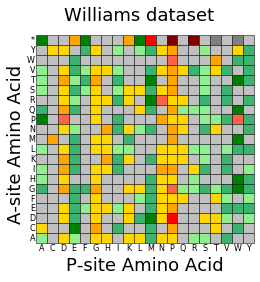

In [5]:
# Get the percent change values for all 420 pair combinations in the 6 datasets
dict_percent_change = {}
# Get the FDR corrected pvalues for all 420 pair combinations in the 6 datasets
dict_pval = {}
# Get the sample sizes for all 420 combinations in the 6 datasets
dict_sample_sizes = {}
# Get the list of norm ribo densitiy for all instances of the pair and its control for all 420 combinations in the 6 datasets
dict_instances = {}


# Running the analysis for Williams dataset
dict_percent_change['Williams'], dict_pval['Williams'], dict_sample_sizes['Williams'], dict_instances['Williams'] = psite_asite_matrix(norm_ribo_density_dict['Williams'], dict_cdn_types)
fig = plot_asite_psite_matrix(dict_percent_change['Williams'], dict_pval['Williams'], 'Williams dataset', print_stats=True)
plt.show()

### Generating the inset plot of Fig. 1a

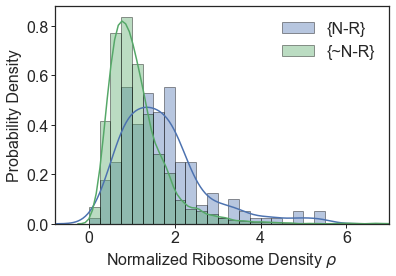

In [6]:
fig = plot_trans_distribution('R', 'N', '~N', dict_instances['Williams'])
plt.show()

### Generating Fig. S1 for one column and one row of the matrix

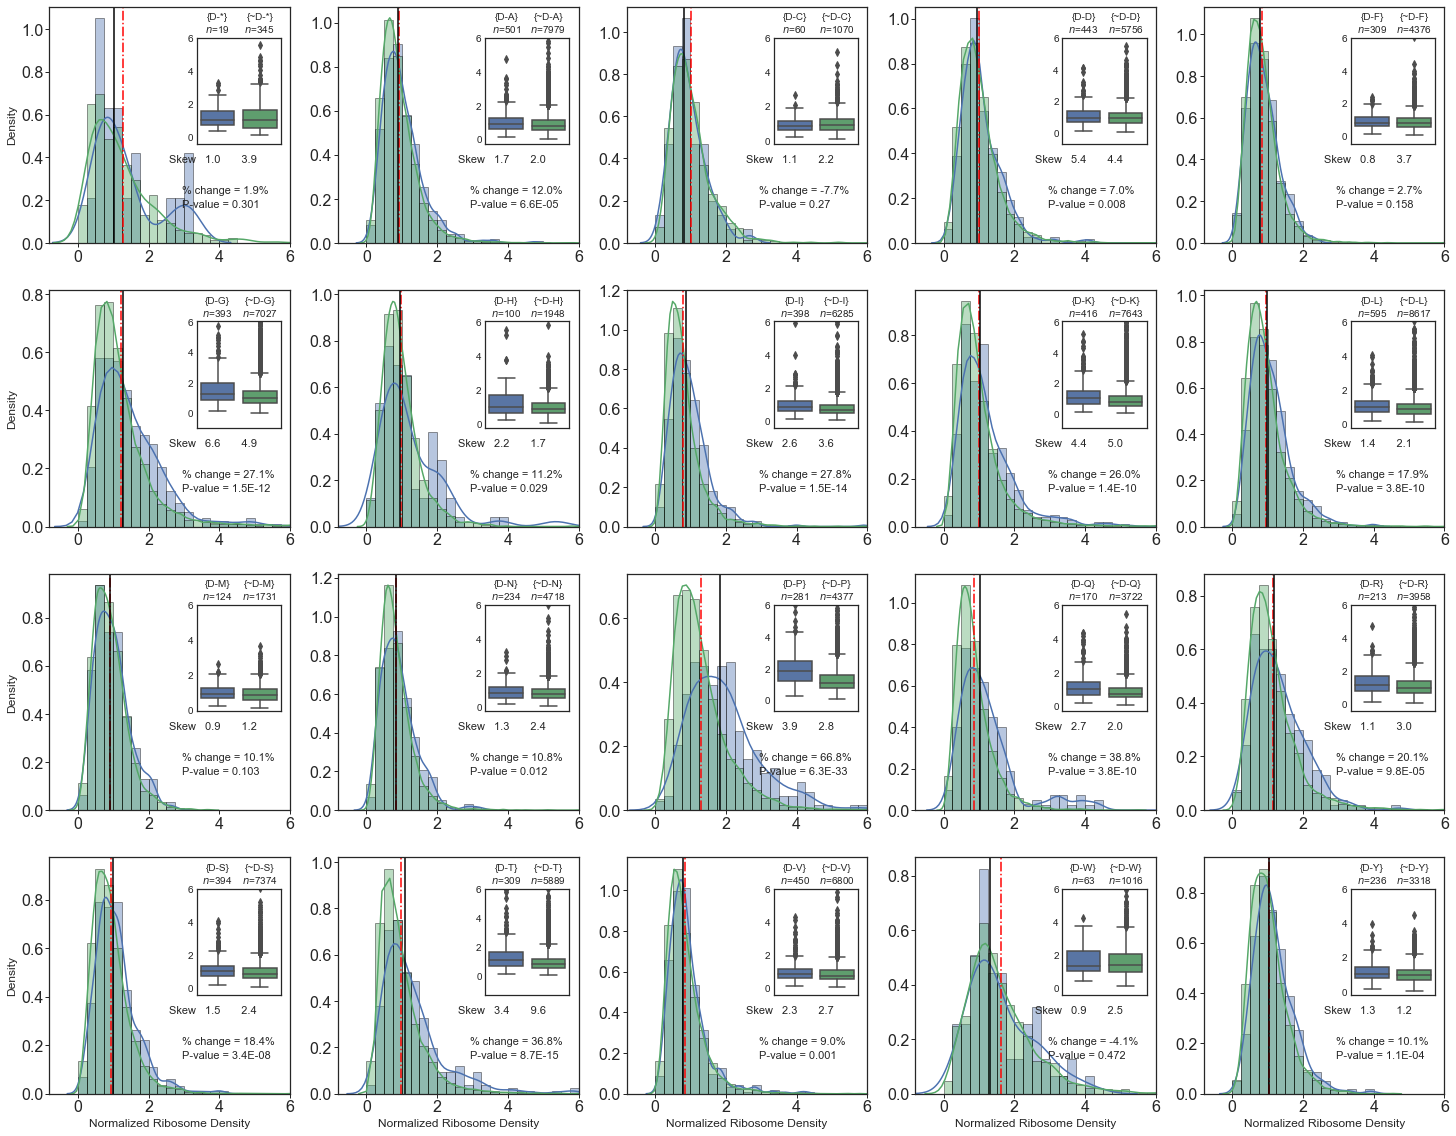

In [7]:
# Plotting Fig. S1 for a column of the above matrix 'D' and for a row of the above matrix 'E'


# Generating Fig. S1b below for the column 'D' of matrix for the Williams dataset shown above
plt.figure(figsize=(5 * 5, 20))
palette_colors = [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)]

sns.set_palette(palette_colors)
subplot_counter = 1
for as_aa in sorted(AMINO_ACIDS):
    # There are total 21 distributions possible for D in the P-site. We will show one of them (D, E) in next plot
    if as_aa == 'E':
        continue
    ax = plt.subplot(4, 5, subplot_counter)
    if subplot_counter in [1, 6, 11, 16]:
        ylabel = True
    else:
        ylabel = False
    if subplot_counter in [16, 17, 18, 19, 20]:
        xlabel = True
    else:
        xlabel = False

    perc_change = dict_percent_change['Williams'][as_aa]['D']
    pval = dict_pval['Williams'][as_aa]['D']
    if pval > 0.001:
        pval = round(pval, 3)
    else:
        pval = '%.1E' % pval

    ax = plot_trans_distribution_subplot(ax, as_aa, 'D', dict_instances['Williams'], perc_change, pval, xlabel=xlabel, ylabel=ylabel) 
    subplot_counter += 1
plt.show()

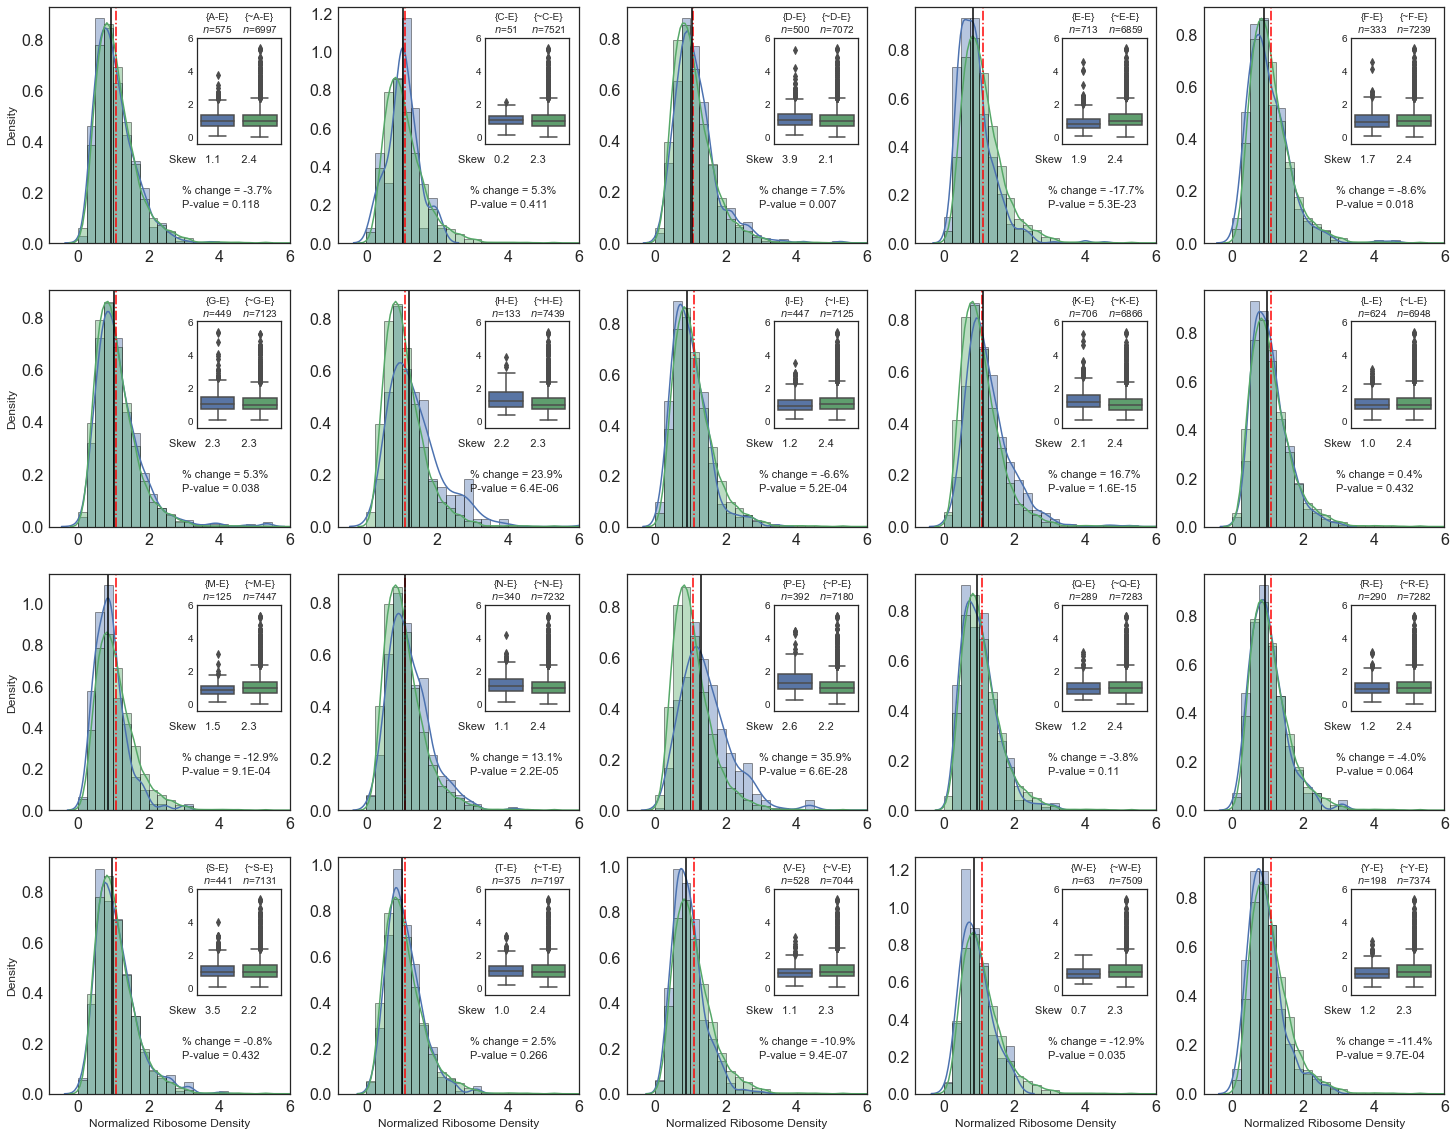

In [9]:
# Generating Fig. S1a below for the row 'E' of the matrix for the Williams dataset
plt.figure(figsize=(5 * 5, 20))
palette_colors = [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)]
sns.set_palette(palette_colors)
sns.set_style("white")

subplot_counter = 1
for ps_aa in sorted(AMINO_ACIDS):
    if ps_aa == '*':
        continue
    if subplot_counter in [1, 6, 11, 16]:
        ylabel = True
    else:
        ylabel = False
    if subplot_counter in [16, 17, 18, 19, 20]:
        xlabel = True
    else:
        xlabel = False
    perc_change = dict_percent_change['Williams']['E'][ps_aa]
    pval = dict_pval['Williams']['E'][ps_aa]
    if pval > 0.001:
        pval = round(pval, 3)
    else:
        pval = '%.1E' % pval
    ax = plt.subplot(4, 5, subplot_counter)
    ax = plot_trans_distribution_subplot(ax, 'E', ps_aa, dict_instances['Williams'], perc_change, pval, xlabel=xlabel, ylabel=ylabel)
    subplot_counter += 1

plt.show()

## Generating Fig. S2 which creates the P-site A-site matrices for the 6 datasets

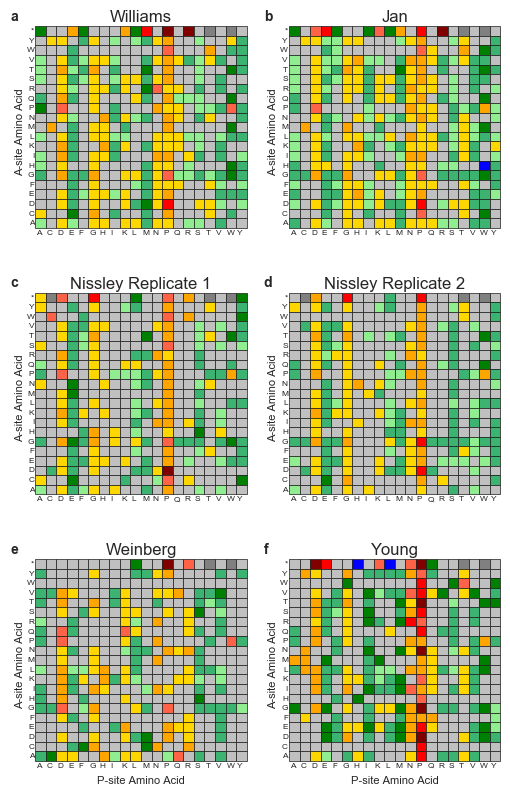

In [81]:
# Creating Fig. S2 that shows the P-site A-site matrix for the six datasets

# Creating a figure object
fig = plt.figure(figsize=(6, 10), dpi=100)

# Reducing the distance by half (default is 6) between the title and the subplot
rcParams['axes.titlepad'] = 3

counter = 1
fig_panel = {'Williams': 'a', 'Jan': 'b', 'Nissley1': 'c', 'Nissley2': 'd', 'Weinberg': 'e', 'Young': 'f'}
for dataset in datasets:
    dict_percent_change[dataset], dict_pval[dataset], dict_sample_sizes[dataset], dict_instances[dataset] = psite_asite_matrix(norm_ribo_density_dict[dataset], dict_cdn_types)
    ax = fig.add_subplot(3, 2, counter)
    ap_matrix, ap_matrix_pval = get_matrix_dataframe(dict_percent_change[dataset], dict_pval[dataset])
    if counter in [5, 6]:
        xlabel = True
    else:
        xlabel = False
    
    ax, pairs_stats = checkerboard_table_subplot(ap_matrix, ap_matrix_pval, ax=ax, xlabel=xlabel)
    ax.tick_params(width=1, length=4, axis='both', which='major', labelsize=6, pad=2)
    if dataset == "Nissley1":
        ax.set_title("Nissley Replicate 1", fontsize=12)
    elif dataset == "Nissley2":
        ax.set_title("Nissley Replicate 2", fontsize=12)
    else:
        ax.set_title(dataset, fontsize=12)
    ax.text(-0.12 * ax.get_xlim()[1], 1.025 * ax.get_ylim()[1], fig_panel[dataset], fontsize=10, fontweight='bold')
    counter += 1

# This is Fig. S2 in the study
plt.show()

## Determing robustness of pairs and plotting the robust matrix which is shown in Fig. 1b of the study

Total pairs that are robust across the datasets: 167
Total pairs that are robust and slow-translating pairs: 81
Total pairs that are robust and fast-translating pairs: 86


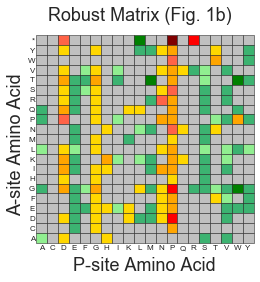

In [199]:
# Determing the robustness of the effect seen for pairs across the 6 datasets and generating a robust matrix that forms the Fig. 1b in the study

matrix_plot, pair_stats, robust_pairs_dict, robust_pairs_mean_percs_dict, robust_perc_dict, robust_pval_dict = measure_robustness_of_pairs(datasets, dict_percent_change, dict_pval)
plt.show()

### Generating Fig. 1c that compares the distribution of two individual amino acid pairs (N, R) vs (S, R)

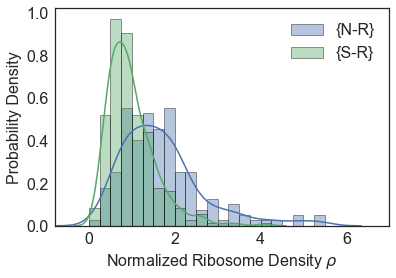

In [15]:
fig = plot_trans_distribution('R', 'N', 'S', dict_instances['Williams'])
plt.show()

### Function definitions for comparing individual amino acid pair distributions

In [16]:
def compare_individual_aa_pairs(dict_aa_psite, min_sample_size=5, print_stats=True):
    # The effect size of the diff between two dist can be measured either as a percent difference.
    # For comparing two amino acid pairs, it is not proper to choose one as a reference. Hence most likely we will measure a percent difference between them

    # Initializing a dict for metrics to store for each pair of A-site and P-site
    dict_effect_size = {}
    dict_pvalues = {}

    # Initializing the inner dict for each A-site asite_aa as key
    for asite_aa in AMINO_ACIDS:
        dict_effect_size[asite_aa] = {}
        dict_pvalues[asite_aa] = {}
        for psite in AMINO_ACIDS:
            # Stop codon cannot be in P-site
            if psite != '*':
                dict_effect_size[asite_aa][psite] = {}
                dict_pvalues[asite_aa][psite] = {}

    # Running the analysis for each amino acid in the A-site            
    for asite_aa, dict_psite in dict_aa_psite.items():
        # for P-site asite_aa and list of translation times and other details
        for psite_aa, trans_list in dict_psite.items():
            # Ignoring an impossible case
            if psite_aa == '*':
                continue
            # trans_list contains two lists: First is list of all ribo density values for each instance of pair and the second is the list of all ribo density values for each instance of the control pair
            pair_rdensity_list = trans_list[0]

            if len(pair_rdensity_list) >= min_sample_size:
                # for all other combinations of P-site asite_aa with this A-site asite_aa, we will calculate the % difference
                for psite_new, trans_list_new in dict_psite.items():
                    if psite_aa != psite_new and psite_new != '*':
                        alt_pair_rdensity_list = trans_list_new[0]
                        # Compare the distributions and calculate the percentage difference between the medians
                        if len(alt_pair_rdensity_list) >= min_sample_size:
                            u, p = stats.mannwhitneyu(pair_rdensity_list, alt_pair_rdensity_list)

                            # Choosing the effect size
                            effect_size = math.fabs(np.median(alt_pair_rdensity_list) - np.median(pair_rdensity_list))*100/((np.median(pair_rdensity_list)+np.median(alt_pair_rdensity_list))/2)

                            # The odds of getting the speed change in the same direction as the difference of the medians.
                            odds = odds_speed_change_aa(pair_rdensity_list, alt_pair_rdensity_list)

                            # This dict is storing for every pair of P-site-Asite, when P-site is mutated to new P-site, what is the perc change in trans time of the medians
                            dict_effect_size[asite_aa][psite_aa][psite_new] = [effect_size, len(pair_rdensity_list), len(alt_pair_rdensity_list), odds]
                            dict_pvalues[asite_aa][psite_aa][psite_new] = p
                        else:
                            odds = odds_speed_change_aa(pair_rdensity_list, alt_pair_rdensity_list)
                            # if odds == -1:
                            #    print('Zero division error for odds for comparison of '+psite_aa+'_'+asite_aa+' with '+psite_new+'_'+asite_aa+'. Sample size of new psite is less than 5')
                            dict_effect_size[asite_aa][psite_aa][psite_new] = [0, len(pair_rdensity_list), len(alt_pair_rdensity_list), odds]  # 'Sample_less_than_5'
                            # Giving a 'NA' pvalue for pair combinations where statistical test is not run. 
                            dict_pvalues[asite_aa][psite_aa][psite_new] = 'NA'  # 'Sample_less_than_5'
            else:
                for psite_new, trans_list_new in dict_psite.items():
                    if psite_new != psite_aa and psite_new != '*':
                        alt_pair_rdensity_list = trans_list_new[0]
                        odds = odds_speed_change_aa(pair_rdensity_list, alt_pair_rdensity_list)
                        # if odds == -1:
                        #    print('Zero division error for odds for comparison of ' + psite_aa + '_' + asite_aa + ' with ' + psite_new + '_' + asite_aa + '. Sample size of old psite is less than 5')
                        dict_effect_size[asite_aa][psite_aa][psite_new] = [0, len(pair_rdensity_list), len(alt_pair_rdensity_list), odds]  # 'Sample_less_than_5'
                        # Giving a 'NA' pvalue for pair combinations where statistical test is not run.  
                        dict_pvalues[asite_aa][psite_aa][psite_new] = 'NA'  # 'Sample_less_than_5'

    # Benjamini-Hochberg correction. We get all the p-values and pool them together in a list and adjust it
    list_of_pval = []
    for asite_aa, data in sorted(dict_effect_size.items()):
        for psite_aa, data_lower in sorted(data.items()):
            for psite_new in sorted(data_lower):
                if dict_pvalues[asite_aa][psite_aa][psite_new] == 'NA':
                    continue
                else:
                    list_of_pval.append(dict_pvalues[asite_aa][psite_aa][psite_new])

    hyp_test, pval_adj, alpsidac, alpbonf = mc.multipletests(list_of_pval, method='fdr_bh')

    dict_aa_psite_pval_adj = {}
    pairs_stats = {'total_pairs': 0, 'sig_pair_combo': 0, 'insig_pair_combo': 0, 'insufficient': 0}

    odds_list = []
    perc_diff_list = []
    adj_pval_list = []
    sig_list = []

    outf = open('Data_files/output_files/DataS2.tab', 'w')
    outf.write('(P-site AA, A-site AA)\t(Mutated P-site AA, A-site AA)\tPercent Difference in the normalized ribosome density distributions\tOdds of translation rate change\t'
               'n(P-site AA1, A-site AA)\tn(P-site AA2, A-site AA)\tMann-Whitney U test p-value\tBH multiple hypothesis corrected p-value\tSignificance\n')
    # Extract back the adjusted p-values into corresponding cells
    i = 0
    print('Writing output file for all P-site A-site pair comparisons to Data S2')
    for asite_aa, data in sorted(dict_effect_size.items()):
        dict_aa_psite_pval_adj[asite_aa] = {}
        for psite_aa, data_lower in sorted(data.items()):
            dict_aa_psite_pval_adj[asite_aa][psite_aa] = {}
            for psite_new, data_under in sorted(data_lower.items()):
                effect_size, len_orig, len_mut, odds = data_under
                pairs_stats['total_pairs'] += 1
                if dict_pvalues[asite_aa][psite_aa][psite_new] == 'NA':
                    dict_aa_psite_pval_adj[asite_aa][psite_aa][psite_new] = 'NA'
                    pairs_stats['insufficient'] += 1
                    significance = 'Insufficient sample size'
                else:
                    dict_aa_psite_pval_adj[asite_aa][psite_aa][psite_new] = pval_adj[i]
                    i += 1
                    if dict_aa_psite_pval_adj[asite_aa][psite_aa][psite_new] > 0.05:
                        pairs_stats['insig_pair_combo'] += 1
                        significance = 'Not Significant'
                    else:
                        significance = 'Significant'
                        pairs_stats['sig_pair_combo'] += 1
                        odds_list.append(odds)
                if dict_aa_psite_pval_adj[asite_aa][psite_aa][psite_new] != 'NA':
                    perc_diff_list.append(effect_size)
                    adj_pval_list.append(dict_aa_psite_pval_adj[asite_aa][psite_aa][psite_new])
                    sig_list.append(significance)
                outf.write('('+psite_aa+','+asite_aa+')\t('+psite_new+','+asite_aa+')\t'+str(effect_size)+'%\t'+str(odds)+'\t'+str(len_orig)+'\t'+str(len_mut)+'\t' +
                           str(dict_pvalues[asite_aa][psite_aa][psite_new])+'\t'+str(dict_aa_psite_pval_adj[asite_aa][psite_aa][psite_new]) + '\t' + significance + '\n')
    outf.close()

    if print_stats:
        print('\n\nSTATISTICS FOR CHANGE IN TRANSLATION SPEED BETWEEN AMINO ACIDS PAIRS\n')
        print('Total number of amino acid pair combinations: ' + str(pairs_stats['total_pairs']) + '\n')
        print('Total number of amino acid pair combinations statistically different from each other: ' + str(pairs_stats['sig_pair_combo']) + '\n')
        print('Total number of amino acid pair combinations statistically similar to each other: ' + str(pairs_stats['insig_pair_combo']) + '\n')
        print('Total number of amino acid pair combinations with less than 5 instances: ' + str(pairs_stats['insufficient']) + '\n')

    palette_colors = [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
                      (0.8666666666666667, 0.5176470588235295, 0.3215686274509804)]
    sns.set_palette(palette_colors)

    plot_perc_change_aa(perc_diff_list, adj_pval_list, sig_list)
    # Plot the odds of translation speed change for pairs of amino acids. This plot is used for Fig 1D
    fig, ax3 = plt.subplots()
    binsize = np.arange(0, 8, 0.25)
    ax3 = sns.distplot(sorted(odds_list)[:-10], ax=ax3, kde=False, label="Significant pairs", norm_hist=True, bins=binsize, hist_kws=dict(edgecolor="black", linewidth=1))
    ax3.tick_params(direction='out', axis='both', width=1, length=4, which='major', labelsize=16, pad=2, bottom=True, left=True)
    ax3.set_xlabel('Odds of translation rate change', fontsize=16)
    ax3.set_ylabel('Probability Density', fontsize=16)
    plt.show()


def plot_perc_change_aa(perc_diff_list, adj_pval_list, sig_list):
    fig, ax1 = plt.subplots()
    
    palette_colors = [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
                      (0.5490196078431373, 0.5490196078431373, 0.5490196078431373)]
    sns.set_palette(palette_colors)
    list_pvals = [-np.log(val) for val in adj_pval_list]
    order_hue = ['Significant', 'Not Significant']
    ax1 = sns.scatterplot(perc_diff_list, list_pvals, hue=sig_list, hue_order=order_hue, ax=ax1, s=5, linewidth=0.05)  # , hue_order=['Significant', 'Not-significant'])
    ax1.set_ylabel('-log (p-value)', fontsize=14)
    ax1.set_xlabel('% difference in median ' + r'$\rho$', fontsize=14)
    ax1.tick_params(width=1, length=4, axis='x', which='major', labelsize=9, pad=2, direction='out', bottom=True)
    ax1.tick_params(width=1, length=2, axis='y', which='major', labelsize=9, pad=1, direction='out', left=True)
    ax1.axhline(y=2.9957, linestyle='--', color='black')
    ax1.legend(fontsize=10, loc='upper left')
    ax1.xaxis.set_ticks(np.arange(0, 145, 10))
    ax1.yaxis.set_ticks(np.arange(0, 121, 20))
    plt.show()


def odds_speed_change_aa(densities_list1, densities_list2):
    list_diff = []
    for density1 in densities_list1:
        for density2 in densities_list2:
            diff = density2-density1
            list_diff.append(diff)
    median_diff = np.median(densities_list2) - np.median(densities_list1)
    # If the median of second list is higher, then  Density_list1 is fast and Density_list2 is slow and hence we calculate the odds of slowdown upon mutation from 1-->2
    if median_diff > 0:
        try:
            odds = float(sum(i > 0 for i in list_diff))/float(sum(i < 0 for i in list_diff))
        except ZeroDivisionError:
            odds = -1
    # If the median of second list is lower, then  Density_list1 is slow and Density_list2 is fast and hence we calculate the odds of speedup upon mutation from 1-->2
    else:
        try:
            odds = float(sum(i < 0 for i in list_diff))/float(sum(i > 0 for i in list_diff))
        except ZeroDivisionError:
            odds = -1

    return odds

### Running all possible 7980 pair comparisons and determining their statistical significance plotted in Fig. 1d, the odds plotted in Fig. 1e and the statistics for all 7980 pair combinations reported in Data S2


There are 420 possible P-site, A-site pairs of amino acids. If we mutate the P-site amino acid, there are 19 other amino acids that we can mutate it to. Hence we can have 420X19=7980 posssible pair combinations. 
We determine if the distributions of these pairs are significantly different from the ones if the P-site is different.  We show this for the pair (N, R) compared to (S, R) above. Now we do this for all 7980 possible combinations and plot their effect size (percent difference) and the statistical significance (p-value) below which is Fig. 1d of the study.

The statistics for the 7980 pair combinations are written out to a file that is available as Data S2 in the study



Writing output file for all P-site A-site pair comparisons to Data S2


STATISTICS FOR CHANGE IN TRANSLATION SPEED BETWEEN AMINO ACIDS PAIRS

Total number of amino acid pair combinations: 7980

Total number of amino acid pair combinations statistically different from each other: 4254

Total number of amino acid pair combinations statistically similar to each other: 3652

Total number of amino acid pair combinations with less than 5 instances: 74



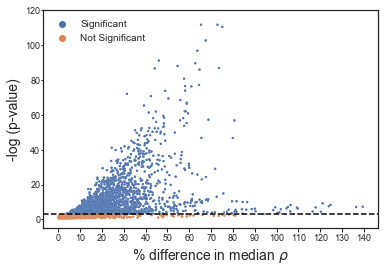

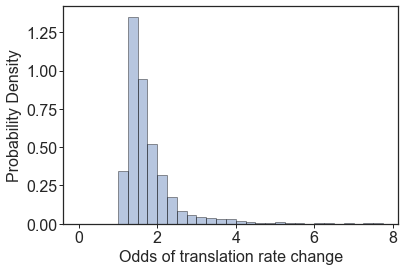

In [17]:
compare_individual_aa_pairs(dict_instances['Williams'])

### Function definitions for running the robustness tests by controlling for different molecular factors (Fig. S3-S7)

In [200]:

def control_analyses_positions(filtered_geneset, codon_type_dict, molecular_factors=('pos_charges', 'mrna_structure', 'tri-peptide_motifs', 'non-optimal_codons', 'wobble_bp', 'watson-crick_bp',  
                                                                                     'first_half', 'second_half', 'disordered_regions', 'cytosolic_proteins', 'high_exp', 'low_exp')):
    # this dict will contain all the A-site codon positions that have a confounding molecular factor present and this instance for an amino acid pair will be excluded from analysis
    positions_with_molfactor = {}

    # GETTING REFERENCE FILES FOR DIFFERENT MOLECULAR FACTORS
    dms_dict = parse_dms_codon_level('Data_files/reference_files/DMS_struc0.2_unstruc0.5_profiles.tab')
    dict_disorder = parse_disordered_regions('Data_files/reference_files//Disordered_regions.tab')
    dict_tmd, dict_loc = parse_tmd_local('Data_files/reference_files/Localization_and_predicted_TMDs.tab')
    low_exp, high_exp = parse_expression_file('Data_files/reference_files/Expression_levels_genes_364_genes_set.tab')
    excluded_localizations = ['Mito', 'ER', 'Golgi', 'Golgi,early_Golgi', 'late_Golgi', 'Mito_Innermembrane', 'Mito_Innermembrane/Mito_Intermembrane', 'Mito_Innermembrane/Mito_Matrix',
                              'Mito_Intermembrane', 'Mito_Intermembrane/Mito_Innermembrane', 'Mito_Intermembrane/Mito_Matrix', 'Mito_Intermembrane/Mito_Outermembrane',
                              'Mito_Matrix', 'Mito_Outermembrane', 'peroxisome', 'SRP-dep', 'SRP-indep', 'vacuolar_membrane', 'vacuolar_membrane,endosome', 'vacuole']
    for gene in filtered_geneset:
        positions_with_molfactor[gene] = {}
        for codon_no, codon_type in enumerate(codon_type_dict[gene]):
            try:
                # Ignoring the first two codons
                if codon_no in [0, 1]:
                    continue
                # Get the P-site codon
                psite_codon = codon_type_dict[gene][codon_no - 1]
                # Get the A-site codon
                asite_codon = codon_type

                # Get the P-site aa for that codon
                psite_aa = genetic_code[psite_codon]
                # Get the A-site aa for that codon
                asite_aa = genetic_code[asite_codon]

                # NOTING CODON POSITIONS HAVING MOLECULAR FACTORS

                for molecular_factor in molecular_factors:
                    if molecular_factor not in positions_with_molfactor[gene]:
                        positions_with_molfactor[gene][molecular_factor] = []
                    # POSITIVELY CHARGED RESIDUES
                    if molecular_factor == 'pos_charges':
                        counter = 0
                        # We are looking for positively charged residues 2-5 residues upstream of A-site
                        for offset in range(2, 6):
                            # Provided the upstream amino acid is not beyond the start codon
                            if codon_no - offset - 1 >= 0:
                                up_aa = genetic_code[codon_type_dict[gene][codon_no - offset - 1]]
                            else:
                                continue
                            if up_aa in ['K', 'R', 'H']:
                                counter += 1
                            else:
                                continue
                        if counter > 0:
                            positions_with_molfactor[gene][molecular_factor].append(codon_no)
                    elif molecular_factor == 'mrna_structure':
                        counter = 0
                        # We are looking for structure in 4 to 6 codons downstream of the A-site
                        for offset in range(4, 7):
                            # Provided the structure is within the length of the gene
                            if codon_no + offset < len(dms_dict[gene]):
                                classifier = dms_dict[gene][codon_no + offset]
                            else:
                                continue
                            # 1 is structured, 0 is unstructured
                            if classifier == 1:
                                counter += 1
                            else:
                                continue
                        if counter > 0:
                            positions_with_molfactor[gene][molecular_factor].append(codon_no)
                    elif molecular_factor == 'tri-peptide_motifs':
                        # AA MOTIFS
                        # Counter for any amino acid motif
                        motif_counter = 0
                        # We are looking to identify PPX and XPP motifs
                        # PPX motif
                        if codon_no - 3 >= 0:
                            ppx = genetic_code[codon_type_dict[gene][codon_no - 3]] + genetic_code[codon_type_dict[gene][codon_no - 2]]
                            if ppx == 'PP':
                                motif_counter += 1

                        # XPP motif
                        if codon_no - 2 >= 0:
                            xpp = genetic_code[codon_type_dict[gene][codon_no - 2]] + genetic_code[codon_type_dict[gene][codon_no - 1]]
                            if xpp == 'PP':
                                motif_counter += 1

                        # Tri-amino acid motif identified by Schuller,...., Green et al with a pause score > 3 in the WT
                        if codon_no - 3 >= 0:
                            motif = genetic_code[codon_type_dict[gene][codon_no - 3]] + genetic_code[codon_type_dict[gene][codon_no - 2]] + genetic_code[codon_type_dict[gene][codon_no - 1]]
                            # ALl motifs with pause score in WT cells > 3. Did not consider PPX and XPP motifs as they are already accounted for above
                            if motif in ['DNP', 'PDP', 'GDP', 'DDP', 'GGG', 'GGT', 'VRH', 'GDT', 'RKK', 'DPG', 'PGG', 'GPG', 'SPG', 'RDK', 'RGP', 'GPT', 'DGP', 'PDG', 'PDR', 'TGP', 'EIW', 'PGR', 'TGT',
                                         'DGG', 'PDD', 'TDP']:
                                motif_counter += 1
                        if motif_counter > 0:
                            positions_with_molfactor[gene][molecular_factor].append(codon_no)
                    elif molecular_factor == 'non-optimal_codons':
                        if asite_codon not in most_optimal_codon[asite_aa]:
                            positions_with_molfactor[gene][molecular_factor].append(codon_no)
                    elif molecular_factor == 'wobble_bp':
                        if psite_codon in base_pairing[psite_aa]['Wobble']:
                            positions_with_molfactor[gene][molecular_factor].append(codon_no)
                    elif molecular_factor == 'watson-crick_bp':
                        if psite_codon in base_pairing[psite_aa]['Watson-Crick']:
                            positions_with_molfactor[gene][molecular_factor].append(codon_no)
                    elif molecular_factor == 'first_half':
                        # Codon positions of first half of gene
                        if float(codon_no) < len(codon_type_dict[gene]) / 2:
                            positions_with_molfactor[gene][molecular_factor].append(codon_no)
                    elif molecular_factor == 'second_half':
                        # Codon positions of second half of gene
                        if float(codon_no) > len(codon_type_dict[gene]) / 2:
                            positions_with_molfactor[gene][molecular_factor].append(codon_no)
                    elif molecular_factor == 'disordered_regions':
                        if gene in dict_disorder:
                            if codon_no in dict_disorder[gene]:
                                positions_with_molfactor[gene][molecular_factor].append(codon_no)
                    elif molecular_factor == 'cytosolic_proteins':
                        if gene in excluded_localizations:
                            positions_with_molfactor[gene][molecular_factor].append(codon_no)
                        elif gene in dict_tmd:
                            if codon_no in dict_tmd[gene]:
                                positions_with_molfactor[gene][molecular_factor].append(codon_no)
                    elif molecular_factor == 'high_exp':
                        if gene in high_exp:
                            positions_with_molfactor[gene][molecular_factor].append(codon_no)
                    elif molecular_factor == 'low_exp':
                        if gene in low_exp:
                            positions_with_molfactor[gene][molecular_factor].append(codon_no)
                    else:
                        print("Molecular factor: "+molecular_factor+" not recognized")
            except KeyError:
                continue

    return positions_with_molfactor


def parse_tmd_local(infile):
    dict_loc = {}
    dict_tmd = {}
    with open(infile) as f:
        for lines in f:
            fields = lines.strip().split('\t')
            gene = fields[0]
            gene_loc = fields[-1]
            if fields[1] != 'N/A':
                if fields[2] == 'N/A':
                    continue
                if gene not in dict_tmd:
                    dict_tmd[gene] = []
                for j in range(int(fields[1]), int(fields[2])+1):
                    dict_tmd[gene].append(j)
                # dict_tmd[gene].append((int(fields[1]), int(fields[2])))
            if fields[3] != 'N/A':
                if fields[4] == 'N/A':
                    continue
                if gene not in dict_tmd:
                    dict_tmd[gene] = []
                for j in range(int(fields[3]), int(fields[4])+1):
                    dict_tmd[gene].append(j)
                # dict_tmd[gene].append((int(fields[3]), int(fields[4])))
            if fields[5] != 'N/A':
                if fields[6] == 'N/A':
                    continue
                if gene not in dict_tmd:
                    dict_tmd[gene] = []
                for j in range(int(fields[5]), int(fields[6])+1):
                    dict_tmd[gene].append(j)
                # dict_tmd[gene].append((int(fields[5]), int(fields[6])))
            dict_loc[gene] = gene_loc
    return dict_tmd, dict_loc


def parse_disordered_regions(infile):
    dict_disorder = {}
    with open(infile) as f:
        for lines in f:
            fields = lines.strip().split('\t')
            gene = fields[0]
            for i in range(1, len(fields), 2):
                start, stop = int(fields[i]), int(fields[i+1])
                if gene not in dict_disorder:
                    dict_disorder[gene] = []
                for j in range(start, stop+1):
                    dict_disorder[gene].append(j)

    return dict_disorder


def parse_expression_file(infile):
    avg_reads_dict = {}
    with open(infile) as f:
        next(f)
        for lines in f:
            fields = lines.strip().split('\t')
            gene = fields[0]
            avg_reads = float(fields[2])
            # RPKM is  N*10^9/L*T where N is no. of mapped reads to gene, L is length of the gene, T is total reads mapped in the experiment
            # since we are comparing genes within the sample, 10^9/T is constant across the sample. RPKM is approximated by N/L which is nothing but average read density
            avg_reads_dict[gene] = avg_reads

    sorted_genelist = [key for key,value in sorted(avg_reads_dict.items() ,key=lambda x : x[1])]
    high_exp = sorted_genelist[round(len(sorted_genelist)/2):]
    low_exp = sorted_genelist[:round(len(sorted_genelist)/2)]
    return low_exp, high_exp

# Parses DMS input file to determine the in vivo mRNA secondary sturcture status of indivudal nt in genes. Used when determining the prob of mol factor and controlling for it.
def parse_dms_codon_level(dms_file):
    dms_dict = {}
    # Parse the DMS tab file and populate the dictionary
    with open(dms_file) as infile:
        infile.readline()
        for lines in infile:
            fields = lines.strip().split('\t')
            gene_name = fields[0]
            classifier_list = list(map(int, fields[2].split(',')))
            dms_dict[gene_name] = classifier_list

    return dms_dict


def psite_asite_matrix_removing_instances(norm_ribo_dict, codon_type_dict, cdn_mol_factor_dict, mol_factor, exclude=True):
    dict_asite_psite_instances = {}

    for asite_aa in AMINO_ACIDS:
        dict_asite_psite_instances[asite_aa] = {}
        for psite_aa in AMINO_ACIDS:
            # Stop codon cannot be in P-site
            if psite_aa == '*':
                continue
            dict_asite_psite_instances[asite_aa][psite_aa] = []

    # Get all the asite_aa info by translating codon_type_dict codons to corresponding amino acids
    for gene, ribo_profile in norm_ribo_dict.items():
        for codon, ribo_density in enumerate(ribo_profile):
            try:
                # Ignoring the first two codons as they are influenced heavily by translation initiation
                if codon in [0, 1]:
                    continue
                # Get the P-site asite_aa for that codon.  codon_type_dict also has 0-indexed numbering for codons similar to ribo_profile and so we use the same criteria here
                psite_aa = genetic_code[codon_type_dict[gene][codon - 1]]
                # Get the A-site asite_aa for that codon
                asite_aa = genetic_code[codon_type_dict[gene][codon]]
                # Ignore instances which have zero reads.
                # This will most likely happen when we are using instances from constant set of genes for datasets other than the highest coverage Williams data for which may not have necessarily met the filtering criteria.
                if ribo_density > 0:
                    # Controlling for molecular factor by removing instances that contain them
                    if exclude:
                        if codon in cdn_mol_factor_dict[gene][mol_factor]:
                            continue
                        else:
                            dict_asite_psite_instances[asite_aa][psite_aa].append((float(ribo_density), gene, codon + 1, codon_type_dict[gene][codon - 1], codon_type_dict[gene][codon]))
                    else:
                        # If we want to include instances with this mol factor. For example, if we want to include only Watson-Crick codon instances. The codon numbers are listed here and they will be included
                        if codon in cdn_mol_factor_dict[gene][mol_factor]:
                            # dict_asite_psite_instances will have a dict of p-site and ribo densities for all a-site asite_aa. This is a dictionary initialized before for all combo of asite_aa
                            # dict_asite_psite_instances[Asite_AA][P-site_AA] = [ribo_density, gene, A-site codon number, P-site codon type, A-site codon type]
                            dict_asite_psite_instances[asite_aa][psite_aa].append((float(ribo_density), gene, codon + 1, codon_type_dict[gene][codon - 1], codon_type_dict[gene][codon]))
                        else:
                            continue
                        
            except KeyError:
                print("KeyError occuring for codon type dict for gene " + gene + " at codon position " + str(codon + 1))

    # Initializing a dict for metrics to store for each pair of a-site and p-site
    dict_asite_psite_effect_size = {}
    dict_asite_psite_pval = {}
    dict_asite_psite_sample_size = {}
    dict_pair_instances_list = {}

    # Initializing the inner dict for each a-site asite_aa as key
    for asite_aa in AMINO_ACIDS:
        dict_asite_psite_effect_size[asite_aa] = {}
        dict_asite_psite_pval[asite_aa] = {}
        dict_asite_psite_sample_size[asite_aa] = {}
        dict_pair_instances_list[asite_aa] = {}

    # For each amino acid in A-site,
    for asite_aa, dict_psite in dict_asite_psite_instances.items():
        # for all combinations of amino acids in P-site and their list of pair instances
        for psite_aa, pair_instances_list in dict_psite.items():
            pair_rdensity_list = []
            # the pair_rdensity_list will contain only float values of norm ribo densities. pair_instances_list contain many other values like gene name, codon number, codon type etc
            for pair_instance in pair_instances_list:
                pair_rdensity_list.append(pair_instance[0])
            # Create the list of ribo densities for all other amino acids in the P-site excluding the one being compared
            control_pair_rdensity_list = []
            for non_psite_aa, non_pair_instances_list in dict_psite.items():
                if non_psite_aa != psite_aa:
                    for pair_instance in non_pair_instances_list:
                        control_pair_rdensity_list.append(pair_instance[0])
                else:
                    continue

            # Running comparisons only if there are at least 5 instances of the pair.
            if len(pair_rdensity_list) >= 5:
                u, p = stats.mannwhitneyu(pair_rdensity_list, control_pair_rdensity_list)
                dict_pair_instances_list[asite_aa][psite_aa] = [pair_rdensity_list, control_pair_rdensity_list]
                perc_change = ((np.median(pair_rdensity_list) - np.median(control_pair_rdensity_list)) / np.median(control_pair_rdensity_list)) * 100
                # Using percent change as you want to know how much X in P-site causes slowdown/speedup in X-Z pair relative to when X is not present
                dict_asite_psite_effect_size[asite_aa][psite_aa] = perc_change
                dict_asite_psite_pval[asite_aa][psite_aa] = p
                dict_asite_psite_sample_size[asite_aa][psite_aa] = [len(pair_rdensity_list), len(control_pair_rdensity_list)]
            else:
                dict_asite_psite_effect_size[asite_aa][psite_aa] = 0  # 'Sample_less_than_5'
                dict_asite_psite_pval[asite_aa][psite_aa] = 1  # 'Sample_less_than_5'
                dict_asite_psite_sample_size[asite_aa][psite_aa] = [len(pair_rdensity_list), len(control_pair_rdensity_list)]
                dict_pair_instances_list[asite_aa][psite_aa] = [pair_rdensity_list, control_pair_rdensity_list]
    # Benjamini-Hochberg correction. We get all the p-values and pool them together in a list and adjust it
    list_of_pval = []
    # Sorting the data as the adjusted p-values will be reported back from the list according to index
    for asite_aa, data in sorted(dict_asite_psite_effect_size.items()):
        for p_site in sorted(data):
            list_of_pval.append(dict_asite_psite_pval[asite_aa][p_site])
    hyp_test, pval_adj, alpsidac, alpbonf = mc.multipletests(list_of_pval, method='fdr_bh')  # bonferonni

    dict_aa_psite_pval_adj = {}

    # Extract back the adjusted p-values into corresponding cells making sure that the keys are sorted according to when it was put in the list for multiple test correction
    i = 0
    for asite_aa, data in sorted(dict_asite_psite_effect_size.items()):
        dict_aa_psite_pval_adj[asite_aa] = {}
        for p_site, perc_change in sorted(data.items()):
            dict_aa_psite_pval_adj[asite_aa][p_site] = pval_adj[i]
            i += 1

    return dict_asite_psite_effect_size, dict_aa_psite_pval_adj, dict_asite_psite_sample_size, dict_pair_instances_list

def plot_mol_factors_subplots(dict_perc, dict_pval, factor_list, title_dict, orig_title='Original matrix from Fig.1b'):
    fig = plt.figure(figsize=(10, 15))

    if len(factor_list) == 4:
        no_rows = 3
    elif len(factor_list) == 2:
        no_rows = 2
    else:
        no_rows = 3
        print("Plotting for max four factors")

    # First generating the Original matrix from Fig. 1b here
    ax1 = fig.add_subplot(321)
    ap_matrix_original, ap_matrix_pval_original = get_matrix_dataframe(dict_perc['Original'], dict_pval['Original'])
    ax1, pairs_stats = checkerboard_table_subplot_mol_factor(ap_matrix_original, ap_matrix_pval_original, ap_matrix_original, ap_matrix_pval_original, ax=ax1, xlabel=False)
    ax1.tick_params(width=1, length=4, axis='both', which='major', labelsize=8, pad=2)
    ax1.set_title(orig_title, fontsize=13)
    ax1.text(-0.1 * ax1.get_xlim()[1], 1.05 * ax1.get_ylim()[1], 'a', fontsize=15, fontweight='bold')

    # Now plotting for the molecular factor after comparing is matrix with the original matrix above
    counter = 2
    panel_list = ['a', 'b', 'c', 'd', 'e']
    for factor in factor_list:
        ax = fig.add_subplot(no_rows, 2, counter)
        ap_matrix_perc_change, ap_matrix_pval = get_matrix_dataframe(dict_perc[factor], dict_pval[factor])
        if counter in [2, 4]:
            ylabel = False
        else:
            ylabel = True
        if no_rows == 3 and counter in [4, 5]:
            xlabel = True
        elif no_rows == 2 and counter == 2:
            xlabel = True
        else:
            xlabel = False
        ax, pairs_stats = checkerboard_table_subplot_mol_factor(ap_matrix_perc_change, ap_matrix_pval, ap_matrix_original, ap_matrix_pval_original, ax=ax, xlabel=xlabel, ylabel=ylabel)
        ax.tick_params(width=1, length=4, axis='both', which='major', labelsize=8, pad=2)
        ax.set_title(title_dict[factor], fontsize=13)
        ax.text(-0.1 * ax.get_xlim()[1], 1.05 * ax.get_ylim()[1], panel_list[counter-1], fontsize=15, fontweight='bold')
        counter += 1
    # Generating the legend for the figure
    ax6 = fig.add_subplot(no_rows, 2, counter)
    ax6 = generate_legend_for_matrix_subplot(ax6)
    ax6.text(-0.14 * ax6.get_xlim()[1], 0.88 * ax6.get_ylim()[1], 'After controlling for molecular factor', fontsize=12)
    ax6.text(0.08 * ax6.get_xlim()[1], 0.77 * ax6.get_ylim()[1], 'Slow translating pairs', fontsize=12)
    ax6.text(0.2 * ax6.get_xlim()[1], 0.675 * ax6.get_ylim()[1], 'Statistically significant', fontsize=11)
    ax6.text(0.2 * ax6.get_xlim()[1], 0.58 * ax6.get_ylim()[1], 'Statistically insignificant', fontsize=11)
    ax6.text(0.08 * ax6.get_xlim()[1], 0.425 * ax6.get_ylim()[1], 'Fast translating pairs', fontsize=12)
    ax6.text(0.2 * ax6.get_xlim()[1], 0.3425 * ax6.get_ylim()[1], 'Statistically significant', fontsize=11)
    ax6.text(0.2 * ax6.get_xlim()[1], 0.2425 * ax6.get_ylim()[1], 'Statistically insignificant', fontsize=11)
    ax6.text(0.08 * ax6.get_xlim()[1], 0.11 * ax6.get_ylim()[1], 'Pair that switches between fast', fontsize=11)
    ax6.text(0.08 * ax6.get_xlim()[1], 0.06 * ax6.get_ylim()[1], 'and slow', fontsize=11)


def generate_legend_for_matrix_subplot(ax):
    ax.yaxis.set_label_coords(-0.05, 0.5)
    plt.setp(ax.spines.values(), visible=False)
    ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False, direction='out', length=4, width=1)
    ax.patch.set_visible(False)
    ax.set_frame_on(False)
    ax.grid(False)
    tb = Table(ax, bbox=[0, 0, 1, 1])
    data = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, -8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, -4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

    pval = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                     [1, 1, 0.01, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                     [1, 1, 0.1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 0.01, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 0.1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                     [10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                     [3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

    nrows, ncols = data.shape
    width, height = 1.0 / ncols, 1.0 / ncols
    color = 'white'
    # Add cells
    for (i, j), val in np.ndenumerate(data):
        # Index either the first or second item of bkg_colors based on
        # a checker board pattern
        if pval[i][j] == 0.01:
            if val < 0:
                color = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)  # 'darkgreen'
            elif val > 0:
                color = 'coral'   # 'darkorange' # 'mediumblue' # 'darkred'
        elif pval[i][j] == 0.1:
            if val < 0:
                color = 'lightskyblue'  # 'palegreen'     # darkcyan
            elif val > 0:
                color = 'peachpuff'   # 'navajowhite'# 'salmon'   # cyan
        elif pval[i][j] == 10:
            color = 'darkslategrey'   # 'black'   # yellow
        else:
            color = 'white'

        if color == 'white':
            tb.add_cell(i, j, width, width, edgecolor=color, loc='center', facecolor=color)
        else:
            tb.add_cell(i, j, width, width, loc='center', facecolor=color, edgecolor=color)
    tb.set_fontsize(14)
    ax.add_table(tb)
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1 - x0) / abs(y1 - y0))
    return ax


# the following functions are for plotting matrix after controlling for a molecular factor  (FIGURE S3)
def checkerboard_table_subplot_mol_factor(perc_change, pval, perc_change_original, pval_original, ax, xlabel_txt='P-site Amino Acid', ylabel_txt='A-site Amino Acid',
                                              xlabel=True, ylabel=True):

    pairs_stats = {'total_pairs': 0, 'fast_sig_pair': 0, 'slow_sig_pair': 0, 'insig_pair': 0, 'insufficient': 0}

    plt.setp(ax.spines.values(), visible=False)
    # ax.tick_params(left=True, labelleft=True, labelbottom=True, bottom=True, direction='out', length=4, width=1)
    ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False, direction='out', length=4, width=1)
    ax.grid(False)
    tb = Table(ax, bbox=[0, 0, 1, 1])
    mpl.rcParams['grid.linewidth'] = 0.5
    nrows, ncols = perc_change.shape
    width, height = 1.0 / ncols, 1.0 / nrows

    index = ['*', 'Y', 'W', 'V', 'T', 'S', 'R', 'Q', 'P', 'N', 'M', 'L', 'K', 'I', 'H', 'G', 'F', 'E', 'D', 'C', 'A']
    columns = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

    # Add cells
    for (i, j), val in np.ndenumerate(perc_change):
        pairs_stats['total_pairs'] += 1
        # Index either the first or second item of bkg_colors based on
        # a checker board pattern
        # We will consider only those pairs which have been significant in the uncontrolled
        if pval_original[i][j] < 0.05:
            try:
                aa_asite = index[i]
                aa_psite = columns[j]
                original_perc_change = perc_change_original[aa_psite][aa_asite]
                # Opposite directions of signs possibility 1 of 2
                if val < 0 < original_perc_change:
                    color = 'darkslategrey'  # 'black'
                    pairs_stats['fast_sig_pair'] += 1
                # Opposite directions of signs possibility 2 of 2
                elif original_perc_change < 0 < val:
                    color = 'darkslategrey'  # 'black'
                    pairs_stats['slow_sig_pair'] += 1
                elif val >= 0 and original_perc_change >= 0:
                    if pval[i][j] < 0.05:
                        color = 'coral'  # 'darkorange' # 'mediumblue' # 'darkred'   #darkorange
                    else:
                        color = 'peachpuff'  # 'navajowhite'     # 'salmon'
                elif val <= 0 and original_perc_change <= 0:
                    if pval[i][j] < 0.05:
                        color = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)  # 'darkgreen'
                    else:
                        color = 'lightskyblue'  # 'palegreen'
                else:
                    color = 'white'
            except KeyError:
                continue
        else:
            color = 'white'  # lightgrey
            pairs_stats['insig_pair'] += 1

        tb.add_cell(i, j, width, width, loc='center', facecolor=color)
    for key, cell in tb.get_celld().items():
        cell.set_linewidth(0.5)
    # Row Labels...
    for i, label in enumerate(perc_change.index):
        tb.add_cell(i, -1, width, width, text=label, loc='right', edgecolor='none', facecolor='none')
    # Column Labels...
    for j, label in enumerate(perc_change.columns):
        tb.add_cell(22, j, width, width, text=label, loc='left', edgecolor='none', facecolor='none',)
    tb.set_fontsize(8)
    ax.add_table(tb)
    if xlabel:
        ax.set_xlabel(xlabel_txt, fontsize=12)
    if ylabel:
        ax.set_ylabel(ylabel_txt, fontsize=12)
    ax.yaxis.set_label_coords(-0.05, 0.5)
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))

    return ax, pairs_stats

### Generating matrix data that will be compared to original matrix in Fig. 1b and plotted as shown in Fig. S3-S7

In [202]:
positions_with_molfactor = control_analyses_positions(filtered_geneset, dict_cdn_types)

factor_list = ['pos_charges', 'mrna_structure', 'tri-peptide_motifs', 'non-optimal_codons', 'wobble_bp', 'watson-crick_bp', 'first_half', 'second_half', 'disordered_regions', 'cytosolic_proteins', 'high_exp', 'low_exp']

dict_percent_change_factor = {}
dict_pval_factor = {}
dict_sample_sizes_factor = {}
dict_instances_factor = {}
for dataset in datasets:
    for factor in factor_list:
        if factor not in dict_percent_change_factor:
            dict_percent_change_factor[factor] = {}
            dict_pval_factor[factor] = {}
            dict_sample_sizes_factor[factor] = {}
            dict_instances_factor[factor] = {}
        if factor in ['pos_charges', 'mrna_structure', 'tri-peptide_motifs', 'non-optimal_codons', 'disordered_regions', 'cytosolic_proteins']:
            exclude=True
        else:
            # For other factors, include the instances that have the factor: like first_half, second_half etc
            exclude=False
        
        dict_percent_change_factor[factor][dataset], dict_pval_factor[factor][dataset], dict_sample_sizes_factor[factor][dataset], dict_instances_factor[factor][dataset]  = psite_asite_matrix_removing_instances(norm_ribo_density_dict[dataset], dict_cdn_types, positions_with_molfactor, factor, exclude=exclude)
        

title_dict = {'pos_charges': '+ve charged residues', 'mrna_structure': 'mRNA structure', 'tri-peptide_motifs': 'Stalling motifs', 'non-optimal_codons': 'Non-optimal codons', 'wobble_bp':' Only Wobble bp codons', 'watson-crick_bp': 'Only Watson-Crick bp codons', 'first_half':' Only instances from first half', 'second_half': 'Only instances from second half', 'disordered_regions': 'Excluding disordered regions', 'cytosolic_proteins':'Only cytosolic proteins', 'high_exp': 'High expression genes (n=182)', 'low_exp': 'Low expression genes (n=182)'}
pair_stats = {}
robust_pairs_dict = {}
robust_pairs_mean_percs_dict = {}
robust_pairs_perc_dict = {}
robust_pairs_pval_dict = {}
for factor in factor_list:
    pair_stats[factor], robust_pairs_dict[factor], robust_pairs_mean_percs_dict[factor], robust_pairs_perc_dict[factor], robust_pairs_pval_dict[factor] = measure_robustness_of_pairs(datasets, dict_percent_change_factor[factor], dict_pval_factor[factor], print_stats=False, title=title_dict[factor], plot_matrix=False)
    

### Generating Fig. S3

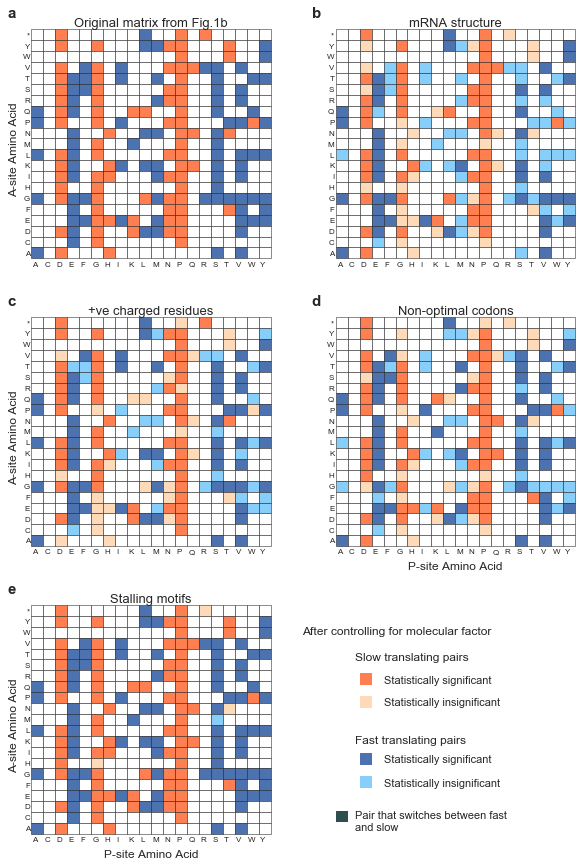

In [204]:
robust_pairs_perc_dict['Original'] = robust_perc_dict
robust_pairs_pval_dict['Original'] = robust_pval_dict
figS3_factor_list = ['mrna_structure', 'pos_charges', 'non-optimal_codons', 'tri-peptide_motifs']
plot_mol_factors_subplots(robust_pairs_perc_dict, robust_pairs_pval_dict, figS3_factor_list, title_dict)

### Generating Fig. S4

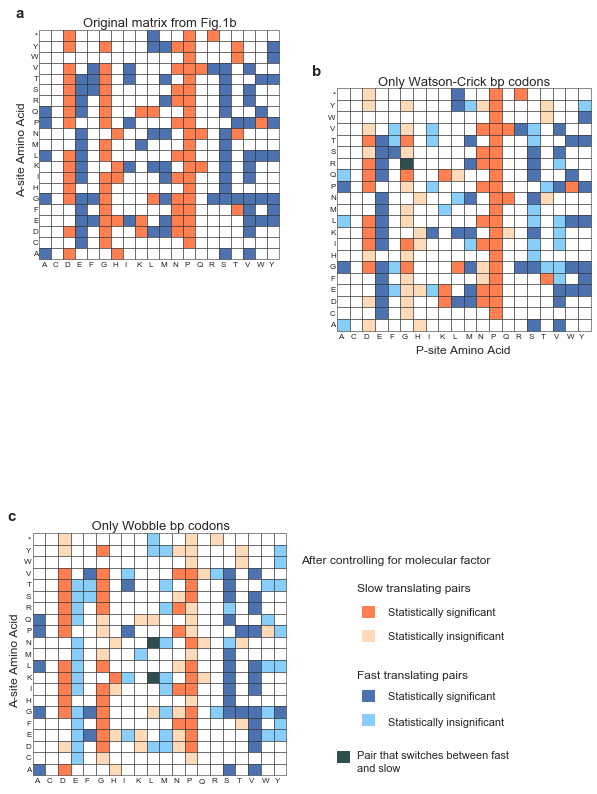

In [216]:
figS4_factor_list = ['watson-crick_bp', 'wobble_bp']
plot_mol_factors_subplots(robust_pairs_perc_dict, robust_pairs_pval_dict, figS4_factor_list, title_dict)

### Getting required data for Fig. S5

In [215]:
norm_ribo_robust_density_dict = {}


# Getting dict for relaxed threshold of min 1 read per codon. This criteria is applied to the highest coverage Williams dataset. 
thres_title = 'Min 1 read at all codons'
norm_ribo_robust_density_dict[thres_title] = {}
norm_ribo_robust_density_dict[thres_title]['Williams'] = gene_codon_filter('Data_files/Published_data/Williams/A-site_profiles.tab', 'Data_files/Published_data/Williams/Multiple_mapped_gene_read_counts_20_35.tab', strict=True, read_threshold=1, dataset='Williams', print_stats=False)

# We will use this list of genes to obtain normalized ribosome density profiles for other datasets
filtered_robust_geneset = list(norm_ribo_robust_density_dict[thres_title]['Williams'].keys())

for dataset in datasets:
# we already got the norm ribo density profiles for Williams dataset
    if dataset == 'Williams':
        continue
    norm_ribo_robust_density_dict[thres_title][dataset] = gene_codon_filter('Data_files/Published_data/'+dataset+'/A-site_profiles.tab', 'Data_files/Published_data/'+dataset+'/Multiple_mapped_gene_read_counts_20_35.tab', genelist=filtered_robust_geneset, dataset=dataset, print_stats=False, strict=False)


# Getting the dicts for three relaxed criteria: 95%, 75% and 50%
for f_thres in [0.05, 0.25, 0.5]:
    thres_title = str(int((1.0-f_thres)*100))+'% codon positions with non-zero reads'
    norm_ribo_robust_density_dict[thres_title] = {}
    # Using relaxed criteria for different thresholds. This criteria is applied to the highest coverage Williams dataset. 
    norm_ribo_robust_density_dict[thres_title]['Williams'] = gene_codon_filter('Data_files/Published_data/Williams/A-site_profiles.tab', 'Data_files/Published_data/Williams/Multiple_mapped_gene_read_counts_20_35.tab', strict=False, relaxed=True, filter_threshold=f_thres, dataset='Williams', print_stats=False)

    # We will use this list of genes to obtain normalized ribosome density profiles for other datasets
    filtered_robust_geneset = list(norm_ribo_robust_density_dict[thres_title]['Williams'].keys())

    for dataset in datasets:
        # we already got the norm ribo density profiles for Williams dataset
        if dataset == 'Williams':
            continue
        norm_ribo_robust_density_dict[thres_title][dataset] = gene_codon_filter('Data_files/Published_data/'+dataset+'/A-site_profiles.tab', 'Data_files/Published_data/'+dataset+'/Multiple_mapped_gene_read_counts_20_35.tab', genelist=filtered_robust_geneset, dataset=dataset, print_stats=False, strict=False)

dict_percent_change_thres = {}
dict_pval_thres = {}
dict_sample_sizes_thres = {}
dict_instances_thres = {}
thres_list = ['Min 1 read at all codons', '95% codon positions with non-zero reads', '75% codon positions with non-zero reads', '50% codon positions with non-zero reads']
for dataset in datasets:
    for thres in thres_list:
        if thres not in dict_percent_change_thres:
            dict_percent_change_thres[thres] = {}
            dict_pval_thres[thres] = {}
            dict_sample_sizes_thres[thres] = {}
            dict_instances_thres[thres] = {}

        dict_percent_change_thres[thres][dataset], dict_pval_thres[thres][dataset], dict_sample_sizes_thres[thres][dataset], dict_instances_thres[thres][dataset]  = psite_asite_matrix(norm_ribo_robust_density_dict[thres][dataset], dict_cdn_types)
        



matrix_plot_thres = {}
pair_stats = {}
robust_pairs_thres = {}
robust_thres_mean_percs_dict = {}
robust_thres_perc_dict = {}
robust_thres_pval_dict = {}
for thres in thres_list:
    pair_stats[thres], robust_pairs_thres[thres], robust_thres_mean_percs_dict[thres], robust_thres_perc_dict[thres], robust_thres_pval_dict[thres] = measure_robustness_of_pairs(datasets, dict_percent_change_thres[thres], dict_pval_thres[thres], print_stats=False, title=thres, plot_matrix=False)

robust_thres_perc_dict['Original'] = robust_perc_dict
robust_thres_pval_dict['Original'] = robust_pval_dict

Parsed the A-site file for Williams dataset
No. of genes with atleast 1 reads in each codon position for Williams dataset is: 688
Parsed the A-site file for Jan dataset
Getting the norm ribo density profiles for a constant set of 688 genes in Jan dataset
Parsed the A-site file for Nissley1 dataset
Getting the norm ribo density profiles for a constant set of 688 genes in Nissley1 dataset
Parsed the A-site file for Nissley2 dataset
Getting the norm ribo density profiles for a constant set of 688 genes in Nissley2 dataset
Parsed the A-site file for Weinberg dataset
Getting the norm ribo density profiles for a constant set of 688 genes in Weinberg dataset
Parsed the A-site file for Young dataset
Getting the norm ribo density profiles for a constant set of 688 genes in Young dataset
Parsed the A-site file for Williams dataset
No. of genes that have non-zero reads at greater than 95.0% of positions for Williams dataset: 1746
Parsed the A-site file for Jan dataset
Getting the norm ribo densit

### Generating Fig. S5

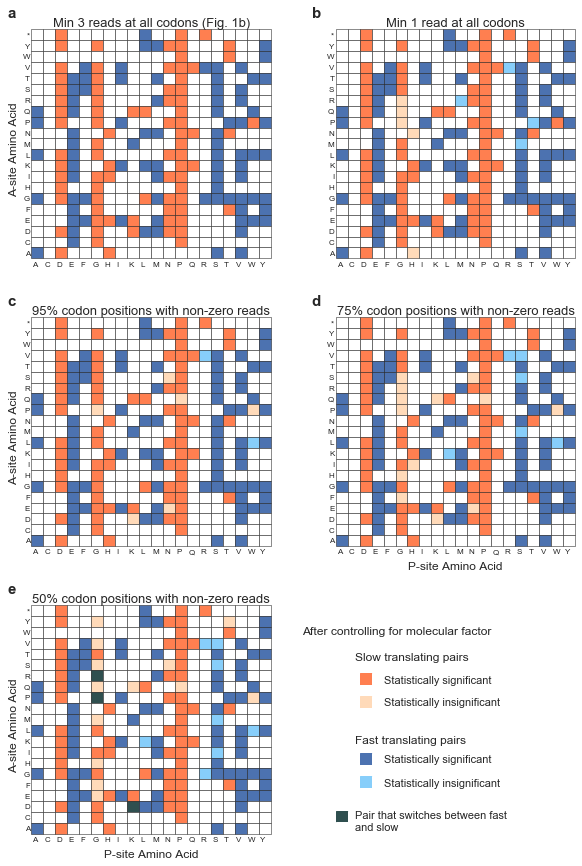

In [208]:
# Putting the list as title dict to fit the format of the plotting function
thres_dict = {thres:thres for thres in thres_list}
plot_mol_factors_subplots(robust_thres_perc_dict, robust_thres_pval_dict, thres_list, thres_dict, orig_title='Min 3 reads at all codons (Fig. 1b)')

### Generating Fig. S6

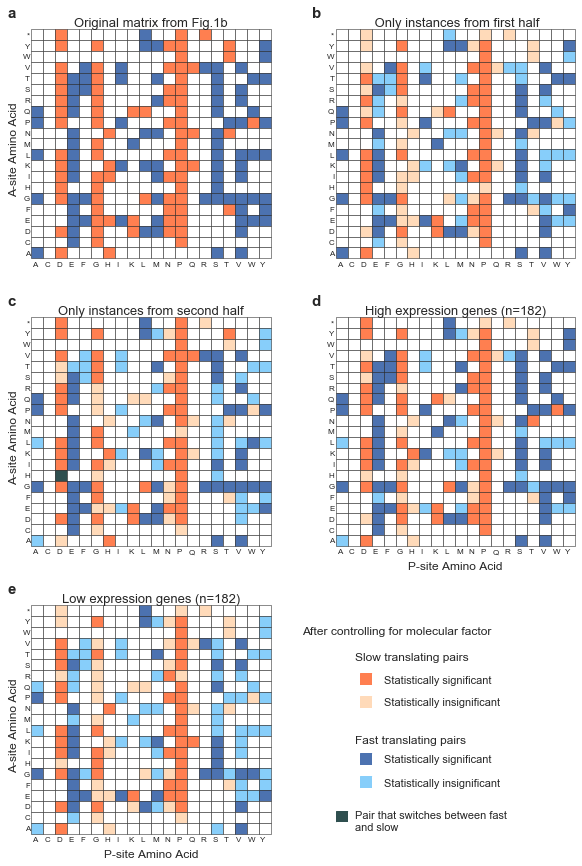

In [209]:
figS6_factor_list = ['first_half', 'second_half', 'high_exp', 'low_exp']
plot_mol_factors_subplots(robust_pairs_perc_dict, robust_pairs_pval_dict, figS6_factor_list, title_dict)

### Generating Fig. S7

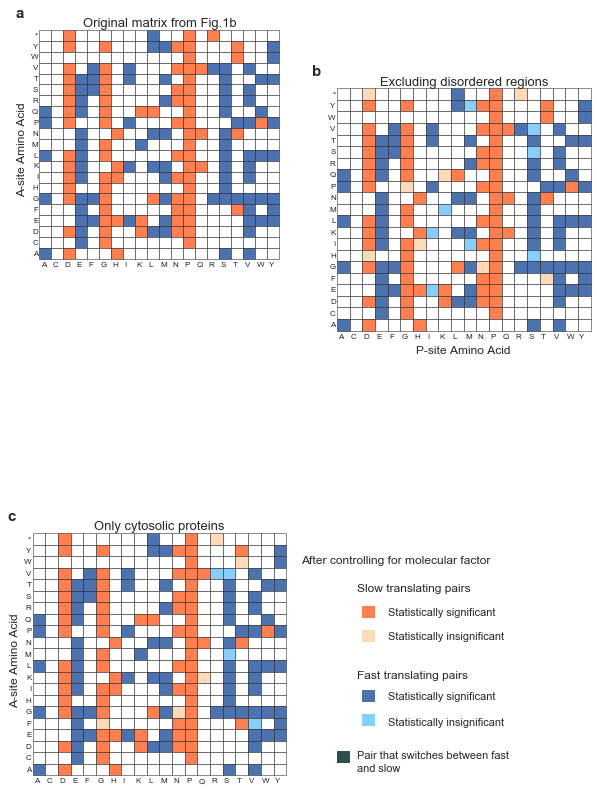

In [210]:
figS7_factor_list = ['disordered_regions', 'cytosolic_proteins']
plot_mol_factors_subplots(robust_pairs_perc_dict, robust_pairs_pval_dict, figS7_factor_list, title_dict)

### Function definitions for generating the matrix at the codon level (64X61 matrix)

In [211]:
def psite_asite_matrix_codon_level(norm_ribo_dict, codon_type_dict):
    dict_asite_psite_instances = {}

    for codon in CODON_TYPES:
        dict_asite_psite_instances[codon] = {}
        for psite_codon in CODON_TYPES:
            # Stop codons cannot be in P-site
            if psite_codon in ['UGA', 'UAG', 'UAA']:
                continue
            dict_asite_psite_instances[codon][psite_codon] = []

    # Get all the instances with asite codon as primary key and psite codon as secondary key
    for gene, ribo_profile in norm_ribo_dict.items():
        for codon, ribo_density in enumerate(ribo_profile):
            # Ignoring the first two codons as they are influenced heavily by translation initiation
            if codon in [0, 1]:
                continue
            # Get the P-site codon
            try:
                psite_codon = codon_type_dict[gene][codon - 1]
            except KeyError:
                print('KeyError in codon type dict for gene ' + gene + ' at codon ' + str(codon))
                psite_codon = ''
            psite_aa = genetic_code[psite_codon]
            # Get the A-site codon
            try:
                asite = codon_type_dict[gene][codon]
            except KeyError:
                print('KeyError in codon type dict for gene ' + gene + ' at codon ' + str(codon + 1))
                asite = ''
            asite_aa = genetic_code[asite]

            # dict_asite_psite_instances will have a dict of p-site and t-times for all a-site asite. This is a dictionary initialized before for all combo of asite
            # dict_asite_psite_instances[Asite_codon][P-site_codon] = [ribo_density, gene, codon number, P-site AA, A-site AA]
            dict_asite_psite_instances[asite][psite_codon].append((float(ribo_density), gene, codon, psite_aa, asite_aa))

    # Initializing a dict for metrics to store for each pair of a-site and p-site
    dict_asite_psite_perc_change = {}
    dict_asite_psite_pval = {}
    dict_asite_psite_sample_size = {}

    # Initializing the inner dict for each a-site asite as key
    for codon in CODON_TYPES:
        dict_asite_psite_perc_change[codon] = {}
        dict_asite_psite_pval[codon] = {}
        dict_asite_psite_sample_size[codon] = {}
    # outfile = open("Nissley2_debugging_control_pair_instances.tab", "w")
    # For each codon in A-site
    for aa_codon, dict_psite in dict_asite_psite_instances.items():
        # for all combinations of codons in P-site and their list of pair instances
        for psite_codon, pairs_instances_list in dict_psite.items():
            pairs_rdensity_list = []
            # the pairs_rdensity_list will contain only float values of norm ribo densities. pairs_instances_list contain many other values like gene name, codon number, codon type etc
            for pair_instance in pairs_instances_list:
                pairs_rdensity_list.append(pair_instance[0])
            # Create the list of trans time for all other codons in the P-site excluding the one being compared
            control_pair_rdensity_list = []
            for non_psite_codon, non_pair_instances_list in dict_psite.items():
                if non_psite_codon != psite_codon:
                    for pair_instance in non_pair_instances_list:
                        # if aa_codon=="GGU" and psite_codon == "GCG":
                        #    outfile.write('\t'.join(map(str, pair_instance)))   
                        #    if pair_instance[0] < 0.0 or pair_instance[0] > 5.0:
                        #        print(pair_instance)
                        if not math.isnan(pair_instance[0]):  
                            control_pair_rdensity_list.append(pair_instance[0])
                else:
                    continue
            # Running comparisons only if there are at least 5 instances of the pair.
            if len(pairs_rdensity_list) >= 5:
                u, p = stats.mannwhitneyu(pairs_rdensity_list, control_pair_rdensity_list)
                # Using percent change as you want to know how much X in P-site causes slowdown/speedup in X-Z pair relative to when X is not present
                perc_change = ((np.median(pairs_rdensity_list) - np.nanmedian(control_pair_rdensity_list)) / np.nanmedian(control_pair_rdensity_list)) * 100
                dict_asite_psite_perc_change[aa_codon][psite_codon] = perc_change
                dict_asite_psite_pval[aa_codon][psite_codon] = p
                dict_asite_psite_sample_size[aa_codon][psite_codon] = [len(pairs_rdensity_list), len(control_pair_rdensity_list)]
            else:
                dict_asite_psite_perc_change[aa_codon][psite_codon] = 0  # 'Sample_less_than_5'
                dict_asite_psite_pval[aa_codon][psite_codon] = 1  # 'Sample_less_than_5'
                dict_asite_psite_sample_size[aa_codon][psite_codon] = [len(pairs_rdensity_list), len(control_pair_rdensity_list)]

    # Benjamini-Hochberg correction. We get all the p-values and pool them together in a list and adjust it
    list_of_pval = []
    for asite, data in sorted(dict_asite_psite_perc_change.items()):
        for p_site in sorted(data):
            list_of_pval.append(dict_asite_psite_pval[asite][p_site])
    hyp_test, pval_adj, alpsidac, alpbonf = mc.multipletests(list_of_pval, method='fdr_bh')

    dict_aa_psite_pval_adj = {}
    # Extract back the adjusted p-values into corresponding cells making sure that the keys are sorted according to when it was put in the list for multiple test correction
    i = 0
    for asite, data in sorted(dict_asite_psite_perc_change.items()):
        dict_aa_psite_pval_adj[asite] = {}
        for p_site, perc_change in sorted(data.items()):
            dict_aa_psite_pval_adj[asite][p_site] = pval_adj[i]
            i += 1
          
    return dict_asite_psite_perc_change, dict_aa_psite_pval_adj, dict_asite_psite_sample_size, dict_asite_psite_instances


def plot_asite_psite_codon_matrix(dict_asite_psite_metric, dict_asite_psite_adj_pval, dict_aa_psite_sample_size, title, txt=False, get_codon_stats=False, print_stats=False):
    # Converting the dict of dicts into list of lists to be converted to a numpy matrix
    # Three empty lists are added for the '*' codons which needs to appear in the first row before Y, W etc
    list_of_lists = [[], [], []]
    list_of_pval_adj = [[], [], []]
    row_labels = ['UAA', 'UAG', 'UGA']
    col_labels = []
    if get_codon_stats:
        outf = open("Inconsistent_two_box_codons.tab", "w")
        outfc = open("Consistent_two_box_codons.tab", "w")
    # Grouping the codons togehter based on the alphabetical order of their amino acids
    for aa in sorted(AMINO_ACIDS):
        for syn_list in synonymous[aa]:
            for codon in syn_list:
                if codon not in ['UAA', 'UAG', 'UGA']:
                    col_labels.append(codon)
    for aa in sorted(AMINO_ACIDS, reverse=True):
        for syn_list in synonymous[aa]:
            for asite_codon in syn_list:
                if asite_codon not in ['UAA', 'UAG', 'UGA']:
                    row_labels.append(asite_codon)
                psite_list = []
                psite_pval_adj_list = []
                for p_site_aa in sorted(AMINO_ACIDS):
                    for psite_syn_list in synonymous[p_site_aa]:
                        syn_perc_change = []
                        syn_pval = []
                        syn_sample_size = []
                        for psite_codon in psite_syn_list:
                            try:
                                # No stop codons in P-site
                                if psite_codon in ['UAA', 'UAG', 'UGA']:
                                    continue
                                psite_list.append(dict_asite_psite_metric[asite_codon][psite_codon])
                                psite_pval_adj_list.append(dict_asite_psite_adj_pval[asite_codon][psite_codon])
                                if get_codon_stats:
                                    syn_perc_change.append(dict_asite_psite_metric[asite_codon][psite_codon])
                                    syn_pval.append(dict_asite_psite_adj_pval[asite_codon][psite_codon])
                                    try:
                                        syn_sample_size.append(dict_aa_psite_sample_size[asite_codon][psite_codon][0])
                                    except KeyError:
                                        # print 'KeyError for syn_sample_size for asite codon ' + asite_codon + ' and psite codon ' + psite_codon
                                        syn_sample_size.append('NA')
                            except KeyError:
                                psite_list.append(0)
                                psite_pval_adj_list.append(1)
                                if get_codon_stats:
                                    syn_perc_change.append(0)
                                    syn_pval.append(1)
                                    try:
                                        syn_sample_size.append(dict_aa_psite_sample_size[asite_codon][psite_codon])
                                    except KeyError:
                                        syn_sample_size.append('NA')
                        if get_codon_stats:
                            if len(syn_perc_change) > 1:
                                if all(i < 0.05 for i in syn_pval):
                                    outfc.write(aa + '\t' + p_site_aa + '\t' + str(asite_codon) + '\t' + '\t'.join(psite_syn_list) + '\t' + '\t'.join(map(str, syn_perc_change)) + '\t' + '\t'.join(map(str, syn_pval)) + '\t' + '\t'.join(
                                        map(str, syn_sample_size)) + '\n')
                                else:
                                    outf.write(aa + '\t' + p_site_aa + '\t' + str(asite_codon) + '\t' + '\t'.join(psite_syn_list) + '\t' + '\t'.join(map(str, syn_perc_change)) + '\t' + '\t'.join(map(str, syn_pval)) + '\t' +
                                               '\t'.join(map(str, syn_sample_size)) + '\n')
                if asite_codon == 'UAA':
                    list_of_lists[0] = psite_list
                    list_of_pval_adj[0] = psite_pval_adj_list
                elif asite_codon == 'UAG':
                    list_of_lists[1] = psite_list
                    list_of_pval_adj[1] = psite_pval_adj_list
                elif asite_codon == 'UGA':
                    list_of_lists[2] = psite_list
                    list_of_pval_adj[2] = psite_pval_adj_list
                else:
                    list_of_lists.append(psite_list)
                    list_of_pval_adj.append(psite_pval_adj_list)

    ap_matrix = np.array(list_of_lists)
    ap_matrix_pval = np.array(list_of_pval_adj)

    ap_matrix_new = pd.DataFrame(ap_matrix, index=row_labels, columns=col_labels)
    
    # col label row is the row where the P-site labels will be placed, 22 for amino acids, 42 for trna and 65 for codons
    figure, pairs_stats = checkerboard_table(ap_matrix_new, ap_matrix_pval, txt=txt, xlabel='P-site Codon', ylabel='A-site Codon', col_label_row=65, figsize=(20, 10), fontsize=16)
    figure.suptitle(title, fontsize=18)

    if print_stats:
        print('\n\nSTATISTICS FOR AMINO ACIDS PAIRS at codon level\n')
        print('Total number of codon pairs: ' + str(pairs_stats['total_pairs']) + '\n')
        print('Total number of fast codon pairs: ' + str(pairs_stats['fast_sig_pair']) + '\n')
        print('Total number of slow codon pairs: ' + str(pairs_stats['slow_sig_pair']) + '\n')
        print('Total number of insignificant codon pairs: ' + str(pairs_stats['insig_pair']) + '\n')
        print('Total number of codon pairs with less than 5 instances: ' + str(pairs_stats['insufficient']) + '\n')
    return figure


### The codon level matrix will be run at relaxed criteria of 95% codon positions with non-zero reads. Getting the norm ribo density profiles for genes that meet this criteria

In [212]:
norm_ribo_codon_density_dict = {}

# For the expanded 64X61 matrix, we are using a relaxed criteria of at least 95% of codon positions having non-zero reads. This criteria is applied to the highest coverage Williams dataset. 
norm_ribo_codon_density_dict['Williams'] = gene_codon_filter('Data_files/Published_data/Williams/A-site_profiles.tab', 'Data_files/Published_data/Williams/Multiple_mapped_gene_read_counts_20_35.tab', strict=False, relaxed=True, filter_threshold=0.05, dataset='Williams', print_stats=True)

# We obtain 1746 genes and we will use this list of genes to obtain normalized ribosome density profiles for other datasets
filtered_codon_geneset = list(norm_ribo_codon_density_dict['Williams'].keys())

datasets = ['Williams', 'Jan', 'Nissley1', 'Nissley2', 'Weinberg', 'Young']
for dataset in datasets:
    # we already got the norm ribo density profiles for Williams dataset
    if dataset == 'Williams':
        continue
    norm_ribo_codon_density_dict[dataset] = gene_codon_filter('Data_files/Published_data/'+dataset+'/A-site_profiles.tab', 'Data_files/Published_data/'+dataset+'/Multiple_mapped_gene_read_counts_20_35.tab', genelist=filtered_codon_geneset, dataset=dataset, print_stats=False, strict=False)

Parsed the A-site file for Williams dataset

Gene mapping statistics for Williams dataset

Number of genes with A-site profiles: 6376
Number of genes containing introns: 281
Number of genes containing overlaps: 297
Number of genes containing multiple aligned reads: 776
Number of reads mapped to the yeast transcriptome: 40369014
No. of genes that have non-zero reads at greater than 95.0% of positions for Williams dataset: 1746
Parsed the A-site file for Jan dataset
Getting the norm ribo density profiles for a constant set of 1746 genes in Jan dataset
Parsed the A-site file for Nissley1 dataset
Getting the norm ribo density profiles for a constant set of 1746 genes in Nissley1 dataset
Parsed the A-site file for Nissley2 dataset
Getting the norm ribo density profiles for a constant set of 1746 genes in Nissley2 dataset
Parsed the A-site file for Weinberg dataset
Getting the norm ribo density profiles for a constant set of 1746 genes in Weinberg dataset
Parsed the A-site file for Young dat

### Getting the codon level 64X61 matrix for Williams dataset



STATISTICS FOR AMINO ACIDS PAIRS at codon level

Total number of codon pairs: 3904

Total number of fast codon pairs: 914

Total number of slow codon pairs: 846

Total number of insignificant codon pairs: 2016

Total number of codon pairs with less than 5 instances: 128



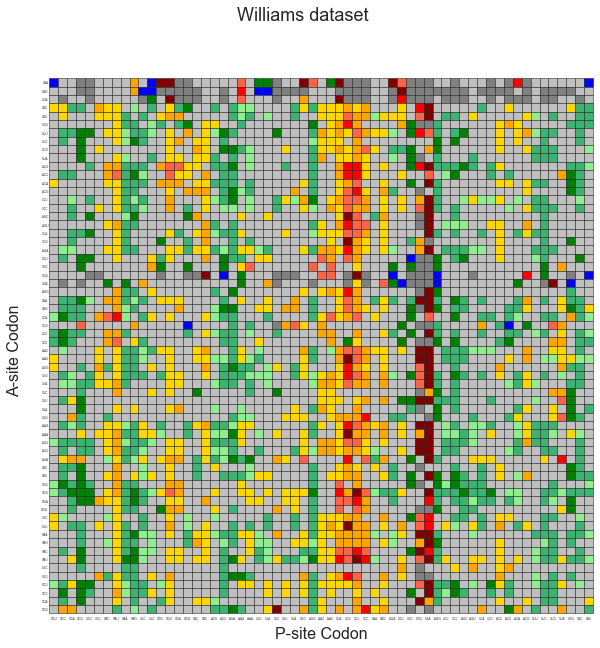

In [213]:
# Get the percent change values for all 3904(64X61) pair combinations in the 6 datasets
dict_codon_percent_change = {}
# Get the FDR corrected pvalues for all 3904 pair combinations in the 6 datasets
dict_codon_pval = {}
# Get the sample sizes for all 3904 combinations in the 6 datasets
dict_codon_sample_sizes = {}
# Get the list of norm ribo densitiy for all instances of the pair and its control for all 3904 combinations in the 6 datasets
dict_codon_instances = {}


# Running the analysis for Williams dataset
dict_codon_percent_change['Williams'], dict_codon_pval['Williams'], dict_codon_sample_sizes['Williams'], dict_codon_instances['Williams'] = psite_asite_matrix_codon_level(norm_ribo_codon_density_dict['Williams'], dict_cdn_types)
fig = plot_asite_psite_codon_matrix(dict_codon_percent_change['Williams'], dict_codon_pval['Williams'], dict_codon_sample_sizes['Williams'], 'Williams dataset', print_stats=True)
plt.show()

# The axes tick labels were formatted separately. Please review Fig. S10 for legible axes tick labels as well as the amino acid groupings

### Plotting the robust codon 64X61 matrix (presented in Fig. S10) that is robust across 6 datasets

Total pairs that are robust across the datasets: 997
Total pairs that are robust and slow-translating pairs: 505
Total pairs that are robust and fast-translating pairs: 492


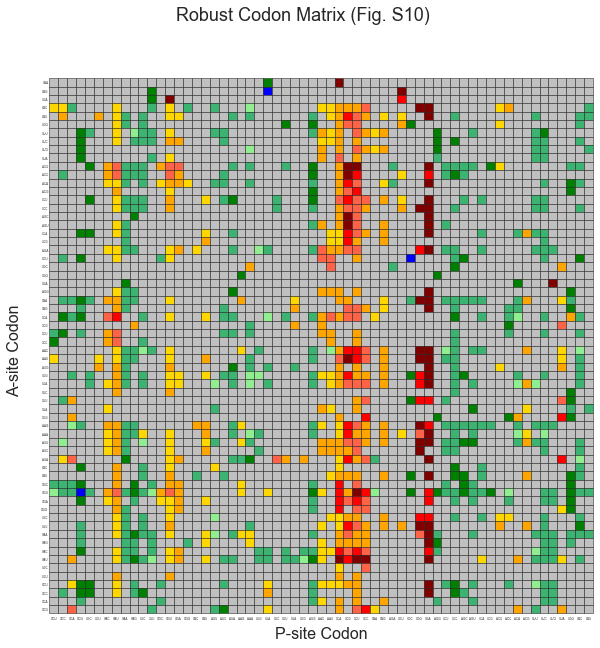

In [214]:
for dataset in datasets:
    dict_codon_percent_change[dataset], dict_codon_pval[dataset], dict_codon_sample_sizes[dataset], dict_codon_instances[dataset] = psite_asite_matrix_codon_level(norm_ribo_codon_density_dict[dataset], dict_cdn_types)

matrix_codon_plot, codon_pair_stats, robust_pairs_codon_dict, robust_pairs_codon_percs_dict, robust_pairs_codon_mean_perc_dict, robust_pairs_codon_pval_dict = measure_robustness_of_pairs(datasets, dict_codon_percent_change, dict_codon_pval, threshold=4, codon_level=True)
plt.show()
# The axes tick labels were formatted separately. Please review Fig. S10 for legible axes tick labels as well as the amino acid groupings

## Loading the datasets for the Ribosome profiling samples carried out on mutated strains (See Methods section in SI for details)

In [68]:
phaseI_list_samples = ['YMR_rep1', 'YMR_rep2', 'YKL_rep1', 'YKL_rep2', 'YLR_rep1', 'YLR_rep2', 'YOL_rep1', 'YOL_rep2']
phaseII_list_samples = ['YHR_rep1', 'YHR_rep2', 'YHR_rep3', 'YHR_rep4', 'YOL-A_rep1', 'YOL-A_rep2', 'YOL-A_rep3', 'YOL-A_rep4',
                            'YOL-B_rep1', 'YOL-B_rep2', 'YOL-B_rep3', 'YOL-B_rep4']

dict_norm_ribo_density = {'PhaseI': {}, 'PhaseII': {}}
for sample in phaseI_list_samples:
    dict_norm_ribo_density['PhaseI'][sample] = gene_codon_filter('Data_files/Mutant_data/'+sample+'/A-site_profiles.tab', 'Data_files/Mutant_data/'+sample+'/Multiple_mapped_gene_read_counts_20_35.tab', dataset=sample, all_genes=True)
for sample in phaseII_list_samples:
    dict_norm_ribo_density['PhaseII'][sample] = gene_codon_filter('Data_files/Mutant_data/'+sample+'/A-site_profiles.tab', 'Data_files/Mutant_data/'+sample+'/Multiple_mapped_gene_read_counts_20_35.tab', dataset=sample, all_genes=True)


Parsed the A-site file for YMR_rep1 dataset


/Users/nabeelahmed/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in double_scalars


Getting the norm ribo density profiles for all 6376 genes in YMR_rep1 dataset
Parsed the A-site file for YMR_rep2 dataset
Getting the norm ribo density profiles for all 6376 genes in YMR_rep2 dataset
Parsed the A-site file for YKL_rep1 dataset
Getting the norm ribo density profiles for all 6376 genes in YKL_rep1 dataset
Parsed the A-site file for YKL_rep2 dataset
Getting the norm ribo density profiles for all 6376 genes in YKL_rep2 dataset
Parsed the A-site file for YLR_rep1 dataset
Getting the norm ribo density profiles for all 6376 genes in YLR_rep1 dataset
Parsed the A-site file for YLR_rep2 dataset
Getting the norm ribo density profiles for all 6376 genes in YLR_rep2 dataset
Parsed the A-site file for YOL_rep1 dataset
Getting the norm ribo density profiles for all 6376 genes in YOL_rep1 dataset
Parsed the A-site file for YOL_rep2 dataset
Getting the norm ribo density profiles for all 6376 genes in YOL_rep2 dataset
Parsed the A-site file for YHR_rep1 dataset
Getting the norm ribo de

### Function definitions for running analysis for the mutational experiments and correlating norm ribo density profiles across different samples

In [69]:
def mutant_gene_correlations(dict_norm_ribo_density, mutant_gene_list, dict_mut_pos):    
    dict_reps_corr = {}
    dict_avg_values = {}
    
    for gene in mutant_gene_list:
        # This dict will contain the Pearson r values from all replicate comparisons to confidently portray that replicates are highly correlated
        dict_reps_corr[gene] = {'Mutant': [], 'Wild-type': []}
        # This dict will contain the averaged ribosome desnities at each position for all replicates of mutant and wild-type
        dict_avg_values[gene] = {'Mutant': [], 'Wild-type': []}

        sample_type_dict = {'Mutant': [], 'Wild-type': []}

        if gene == 'YHR179W':
            phase = 'PhaseII'
        else:
            phase = 'PhaseI'

        for sample in dict_norm_ribo_density[phase]:
            if gene[:3] == sample[:3]:
                sample_type_dict['Mutant'].append(sample)
            else:
                sample_type_dict['Wild-type'].append(sample)

        for samp_type in sample_type_dict:
            for rep1, rep2 in itertools.combinations(sample_type_dict[samp_type], 2):
                r, pval = stats.pearsonr(dict_norm_ribo_density[phase][rep1][gene], dict_norm_ribo_density[phase][rep2][gene])
                if pval > 0.05:
                    print('WARNING: Correlation between reps ' + rep1 + ' and ' + rep2 + ' is not significant. r = ' + str(r) + ' and p-value = ' + str(pval))
                dict_reps_corr[gene][samp_type].append(r)
            dict_vals = {}
            for sample in sample_type_dict[samp_type]:
                dict_vals[sample] = dict_norm_ribo_density[phase][sample][gene]
            rep_values = dict_vals.values()
            dict_avg_values[gene][samp_type] = [sum(elem)/len(elem) for elem in zip(*rep_values)] 
    rep_corr_list = []
    for gene in dict_reps_corr:
        for samp_type in dict_reps_corr[gene]:
            rep_corr_list += dict_reps_corr[gene][samp_type]
    print("All replicates have Pearson correlation between them > "+str(min(rep_corr_list)))
    print("Averaging all replicates to form a single mutant profile and single wild-type profile for each gene")
    # We will mark the mutated positions and the positions following it with different colors than from the rest of the codon positions
    dict_selected = {}
    dict_color = {}
    dict_color_edge = {}
    
    for gene in dict_mut_pos:
        if gene not in dict_selected:
            dict_selected[gene] = {}
            dict_color[gene] = {}
            dict_color_edge[gene] = {}
        for mut_type in ['Mutant', 'Wild-type']:
            for i in dict_mut_pos[gene]:
                if mut_type not in dict_selected[gene]:
                    dict_selected[gene][mut_type] = []
                    dict_color[gene][mut_type] = []
                    dict_color_edge[gene][mut_type] = []
                dict_selected[gene][mut_type].append(dict_avg_values[gene][mut_type][i-1])
                dict_color[gene][mut_type].append('r')
                dict_color_edge[gene][mut_type].append('k')
                dict_selected[gene][mut_type].append(dict_avg_values[gene][mut_type][i-2])
                dict_color[gene][mut_type].append('g')
                dict_color_edge[gene][mut_type].append('k')

    print("\n\nGene\tSlope\tIntercept\tPearson R\tP-value")            
    plt.figure(figsize=(10, 10))
    plt.style.use('seaborn-white')

    ax1 = plt.subplot2grid(shape=(2, 6), loc=(0, 0), colspan=2, aspect='equal')
    ax1 = subplot_gene_correlation(ax1, dict_avg_values, dict_selected, dict_color, dict_color_edge, 'YMR122W-A', panel='a', yticks=[0, 2, 4, 6, 8])
    
    ax2 = plt.subplot2grid((2, 6), (0, 2), colspan=2, aspect='equal')
    ax2 = subplot_gene_correlation(ax2, dict_avg_values, dict_selected, dict_color, dict_color_edge, 'YKL096W-A', panel='b', yticks=[0, 2, 4, 6, 8, 10], ylabel=False)
      
    ax3 = plt.subplot2grid((2, 6), (0, 4), colspan=2, aspect='equal')
    ax3 = subplot_gene_correlation(ax3, dict_avg_values, dict_selected, dict_color, dict_color_edge, 'YOL109W', panel='c', yticks=[0, 2, 4, 6], ylabel=False)
    
    ax4 = plt.subplot2grid(shape=(2, 6), loc=(1, 1), colspan=2, aspect='equal')
    ax4 = subplot_gene_correlation(ax4, dict_avg_values, dict_selected, dict_color, dict_color_edge, 'YLR109W', panel='d', yticks=[0, 2, 4, 6], ylabel=True)
    
    ax5 = plt.subplot2grid((2, 6), (1, 3), colspan=2, aspect='equal')
    ax5 = subplot_gene_correlation(ax5, dict_avg_values, dict_selected, dict_color, dict_color_edge, 'YHR179W', panel='e', yticks=[0, 2, 4, 6, 8], ylabel=False)
    
    plt.tight_layout()
    plt.show()


def subplot_gene_correlation(ax, dict_avg_values, dict_selected, dict_color, dict_color_edge, gene, yticks=(0, 2, 4, 6, 8), panel='a', ylabel=True):
    color_list = []
    for i in range(0, len(dict_avg_values[gene]['Mutant'])):
        color_list.append((0.12156862745098039, 0.4666666666666667, 0.7058823529411765))
    # All the codon positions norm ribo densities are plotted first
    ax = sns.regplot(dict_avg_values[gene]['Mutant'], dict_avg_values[gene]['Wild-type'], ci=None, scatter_kws={'s': 28, 'facecolors': color_list, 'edgecolor': color_list}, line_kws={'linewidth': 1}, ax=ax)
    # The mutated position's data point is plotted in red and the position following it(when the mutated position is in P-site) is plotted in green
    ax = sns.regplot(dict_selected[gene]['Mutant'], dict_selected[gene]['Wild-type'], ci=None, scatter_kws={'s': 45, 'facecolors': dict_color[gene]['Wild-type'], 'edgecolor': dict_color_edge[gene]['Wild-type']}, line_kws={'linewidth': 1}, fit_reg=False, ax=ax)
    ax.set_ylim(ax.get_ylim()[0], 1.2 * ax.get_ylim()[1])
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_prop_cycle(color=['blue', 'green'])
    slope, intercept, pearsonr, p_val, stderr = stats.linregress(dict_avg_values[gene]['Mutant'], dict_avg_values[gene]['Wild-type'])
    # slope, intercept, pearsonr, p_val, stderr = stats.linregress(dict_avg_values[gene]['Wild-type'], dict_avg_values[gene]['Mutant'])
    
    print(gene+'\t'+str(round(slope, 3))+'\t'+str(round(intercept, 3))+'\t'+str(round(pearsonr, 3))+'\t'+str(p_val)+'\n')
    ax.text(0.05 * ax.get_xlim()[1], 0.9 * ax.get_ylim()[1], 'r = ' + str(np.round(pearsonr, 2)), fontsize=12)
    ax.text(0.05 * ax.get_xlim()[1], 0.82 * ax.get_ylim()[1], 'slope = ' + str(np.round(slope, 2)), fontsize=12)
    # ax.set(adjustable='box')
    # ax.set_aspect('equal')
    ax.set_title(gene, fontsize=16)
    if ylabel:
        ax.set_ylabel(r'$\rho$ (Wild-type)', fontsize=14)
    else:
        ax.yaxis.label.set_visible(False)
    ax.set_xlabel(r'$\rho$  (Mutant)', fontsize=14)
    ax.tick_params(width=1, length=4, axis='both', which='major', bottom=True, left=True, direction='out', labelsize=10, pad=2)
    ax.text(-0.25 * ax.get_xlim()[1], 1.05 * ax.get_ylim()[1], panel, fontsize=14, weight='extra bold')
#     ax.set_yticks(yticks)
#     ax.set_yticklabels(yticks, ha="right")

    return ax

def subplot_gene_correlation_two_mutants(ax, x, y, dict_avg_values, dict_selected, dict_color, dict_color_edge, title, gene, yticks=(0, 2, 4, 6, 8), panel='a', ylabel=True):
    color_list = []
    for i in range(0, len(dict_avg_values[gene][x])):
        color_list.append((0.12156862745098039, 0.4666666666666667, 0.7058823529411765))
    # All the codon positions norm ribo densities are plotted first
    ax = sns.regplot(dict_avg_values[gene][x], dict_avg_values[gene][y], ci=None, scatter_kws={'s': 28, 'facecolors': color_list, 'edgecolor': color_list}, line_kws={'linewidth': 1}, ax=ax)
    # The mutated position's data point is plotted in red and the position following it(when the mutated position is in P-site) is plotted in green
    ax = sns.regplot(dict_selected[gene][x], dict_selected[gene][y], ci=None, scatter_kws={'s': 45, 'facecolors': dict_color[gene][y], 'edgecolor': dict_color_edge[gene][y]}, fit_reg=False, line_kws={'linewidth': 1},ax=ax)
    ax.set_ylim(ax.get_ylim()[0], 1.2 * ax.get_ylim()[1])
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_prop_cycle(color=['blue', 'green'])
    slope, intercept, pearsonr, p_val, stderr = stats.linregress(dict_avg_values[gene][x], dict_avg_values[gene][y])
    # slope, intercept, pearsonr, p_val, stderr = stats.linregress(dict_avg_values[gene]['Wild-type'], dict_avg_values[gene]['Mutant'])

    print(title + '\t' + str(round(slope, 3)) + '\t' + str(round(intercept, 3)) + '\t' + str(round(pearsonr, 3)) + '\t' + str(p_val) + '\n')
    ax.text(0.05 * ax.get_xlim()[1], 0.9 * ax.get_ylim()[1], 'r = ' + str(np.round(pearsonr, 2)), fontsize=10)
    ax.text(0.05 * ax.get_xlim()[1], 0.78 * ax.get_ylim()[1], 'slope = ' + str(np.round(slope, 2)), fontsize=10)
    # ax.set(adjustable='box')
    # ax.set_aspect('equal')
    ax.set_title(title, fontsize=14)
    if ylabel:
        ax.set_ylabel(r'$\rho$ ('+y+')', fontsize=14)
    else:
        ax.yaxis.label.set_visible(False)
    ax.set_xlabel(r'$\rho$  ('+x+')', fontsize=14)
    ax.tick_params(width=1, length=4, axis='both', which='major', bottom=True, left=True, direction='out', labelsize=10, pad=2)
    ax.text(-0.25 * ax.get_xlim()[1], 1.05 * ax.get_ylim()[1], panel, fontsize=14, weight='extra bold')
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, ha="right")

    return ax


def plot_barplot_norm_ribo_profile(data_plot, ax, title=u'YOL109W (Q,D) \u2196 (P,D)', panel='d', ylabel=False, legend=False):
    ax = sns.barplot(x=data_plot['Position'], y=data_plot['Density'], hue=data_plot['Sample_type'], hue_order=['Wild-type', 'Mutant1', 'Mutant2'], ax=ax, palette='deep')  # ['E-2','E-1', 'E', 'P', 'A', 'A+1', 'A+2']
    ax.tick_params(width=1, length=4, axis='x', which='major', labelsize=7, left=True, bottom=True)
    ax.tick_params(width=1, length=4, axis='y', which='major', labelsize=7, pad=2)
    ax.set_xlabel('Codon Position', fontsize=9)
    if ylabel:
        ax.set_ylabel(r'$\rho$', fontsize=9)
    else:
        ax.yaxis.label.set_visible(False)
    if legend:
        ax.legend().set_visible(True)
    else:
        ax.legend().set_visible(False)
    ax.tick_params(width=1, length=4, axis='both', which='major', bottom=True, left=True, direction='out', labelsize=10, pad=2)
    ax.text(-0.25 * ax.get_xlim()[1], 1.05 * ax.get_ylim()[1], panel, fontsize=16, weight='extra bold')
    ax.set_title(title, fontsize=14)
    return ax


def mutant_gene_correlations_two_mutants(dict_norm_ribo_density, dict_mut_pos, dict_mutations, gene='YOL109W'):
    # We have only one gene YOL109W that has 3 mutations that are done through two different synonymous mutations creating two mutant strains Mutant1 and Mutant2
    # This dict will contain the Pearson r values from all replicate comparisons to confidently portray that replicates are highly correlated
    dict_reps_corr = {'Mutant1': [], 'Wild-type': [], 'Mutant2': []}
    dict_avg_values = {}
    
    # This dict will contain the averaged ribosome desnities at each position for all replicates of mutant and wildtype
    dict_avg_values[gene] = {'Mutant1': [], 'Wild-type': [], 'Mutant2': []}
    sample_type_dict = {'Mutant1': [], 'Mutant2': [], 'Wild-type': []}
    phase = 'PhaseII'
    for sample in dict_norm_ribo_density[phase]:
        if sample.split('_')[0] == 'YHR':
            sample_type_dict['Wild-type'].append(sample)
        elif sample.split('_')[0] == 'YOL-A':
            sample_type_dict['Mutant1'].append(sample)
        elif sample.split('_')[0] == 'YOL-B':
            sample_type_dict['Mutant2'].append(sample)
    for samp_type in sample_type_dict:
        for rep1, rep2 in itertools.combinations(sample_type_dict[samp_type], 2):
            r, pval = stats.pearsonr(dict_norm_ribo_density[phase][rep1][gene], dict_norm_ribo_density[phase][rep2][gene])
            if pval > 0.05:
                print('WARNING: Correlation between reps ' + rep1 + ' and ' + rep2 + ' is not significant. r = ' + str(r) + ' and p-value = ' + str(pval))
            dict_reps_corr[samp_type].append(r)
        dict_vals = {}
        for sample in sample_type_dict[samp_type]:
            dict_vals[sample] = dict_norm_ribo_density[phase][sample][gene]
        rep_values = dict_vals.values()
        dict_avg_values[gene][samp_type] = [sum(elem) / len(elem) for elem in zip(*rep_values)]
    rep_corr_list = []
    for samp_type in dict_reps_corr:
        rep_corr_list += dict_reps_corr[samp_type]
    print("All replicates have Pearson correlation between them > " + str(min(rep_corr_list)))
    print("Averaging all replicates to form a single mutant profile and single wild-type profile for each gene")
    
    # We will mark the mutated positions and the positions following it with different colors than from the rest of the codon positions
    dict_selected = {}
    dict_color = {}
    dict_color_edge = {}

    if gene not in dict_selected:
        dict_selected[gene] = {}
        dict_color[gene] = {}
        dict_color_edge[gene] = {}
    for mut_type in ['Mutant1', 'Mutant2', 'Wild-type']:
        for i in dict_mut_pos[gene]:
            if mut_type not in dict_selected[gene]:
                dict_selected[gene][mut_type] = []
                dict_color[gene][mut_type] = []
                dict_color_edge[gene][mut_type] = []
            dict_selected[gene][mut_type].append(dict_avg_values[gene][mut_type][i - 1])
            dict_color[gene][mut_type].append('r')
            dict_color_edge[gene][mut_type].append('k')
            dict_selected[gene][mut_type].append(dict_avg_values[gene][mut_type][i - 2])
            dict_color[gene][mut_type].append('g')
            dict_color_edge[gene][mut_type].append('k')
    
    print("\n\nGene\tSlope\tIntercept\tPearson R\tP-value") 
    plt.figure(figsize=(3 * 3, 6))
    plt.style.use('seaborn-white')
    
    ax1 = plt.subplot(231, adjustable='box')
    ax1 = subplot_gene_correlation_two_mutants(ax1, 'Mutant1', 'Wild-type', dict_avg_values, dict_selected, dict_color, dict_color_edge, 'Wild-type vs Mutant1', panel='a', gene=gene, yticks=[-1, 0, 1, 2, 3, 4, 5, 6])

    ax2 = plt.subplot(232, adjustable='box')
    ax2 = subplot_gene_correlation_two_mutants(ax2, 'Mutant2', 'Wild-type', dict_avg_values, dict_selected, dict_color, dict_color_edge, 'Wild-type vs Mutant2', panel='b', gene=gene, yticks=[-1, 0, 1, 2, 3, 4, 5, 6])

    ax3 = plt.subplot(233, adjustable='box')
    ax3 = subplot_gene_correlation_two_mutants(ax3, 'Mutant2', 'Mutant1', dict_avg_values, dict_selected, dict_color, dict_color_edge, 'Mutant2 vs Mutant1', panel='c', gene=gene, yticks=[-1, 0, 1, 2, 3, 4, 5, 6])

    barplot_data = {}
    for mut, asite_mut_pos in dict_mutations.items():
        if gene in mut:
            barplot_data[mut] = {'Position': [], 'Density': [], 'Sample_type': []}
            for j in range(asite_mut_pos-5, asite_mut_pos+2):
                if j == asite_mut_pos:
                    k = 'A+1'
                elif j == asite_mut_pos-1:
                    k = 'A'
                elif j == asite_mut_pos-2:
                    k = 'P'
                elif j == asite_mut_pos-3:
                    k = 'E'
                elif j == asite_mut_pos-4:
                    k = 'E-1'
                elif j == asite_mut_pos-5:
                    k = 'E-2'
                elif j == asite_mut_pos+1:
                    k = 'A+2'
                else:
                    k = 'NA'
                for sample_type in dict_avg_values[gene]:
                    barplot_data[mut]['Sample_type'].append(sample_type)
                    barplot_data[mut]['Density'].append(dict_avg_values[gene][sample_type][j])
                    barplot_data[mut]['Position'].append(k)

    ax4 = plt.subplot(234, adjustable='box')
    ax4 = plot_barplot_norm_ribo_profile(barplot_data['YOL109W Q-D-->P-D'], ax4, u'YOL109W (Q,D) \u2192 (P,D)', panel='d', ylabel=True)

    ax5 = plt.subplot(235, adjustable='box')
    ax5 = plot_barplot_norm_ribo_profile(barplot_data['YOL109W G-G-->S-G'], ax5, u'YOL109W (G,G) \u2192 (S,G)', panel='e')

    ax6 = plt.subplot(236, adjustable='box')
    ax6 = plot_barplot_norm_ribo_profile(barplot_data['YOL109W N-R-->S-R'], ax6, u'YOL109W (N,R) \u2192 (S,R)', panel='f', legend=True)
    
    plt.tight_layout()
    plt.show()

### Plotting the norm ribo density profiles for the mutated genes (shown in Fig. S9 of the study)

All replicates have Pearson correlation between them > 0.8269863728454203
Averaging all replicates to form a single mutant profile and single wild-type profile for each gene


Gene	Slope	Intercept	Pearson R	P-value
YMR122W-A	0.927	0.073	0.865	1.3370625103403146e-26

YKL096W-A	0.895	0.105	0.95	8.85407956108515e-48

YOL109W	0.807	0.193	0.873	1.1902692869898062e-36

YLR109W	0.834	0.166	0.853	3.331912014808702e-51

YHR179W	0.96	0.04	0.962	6.965782165980752e-228



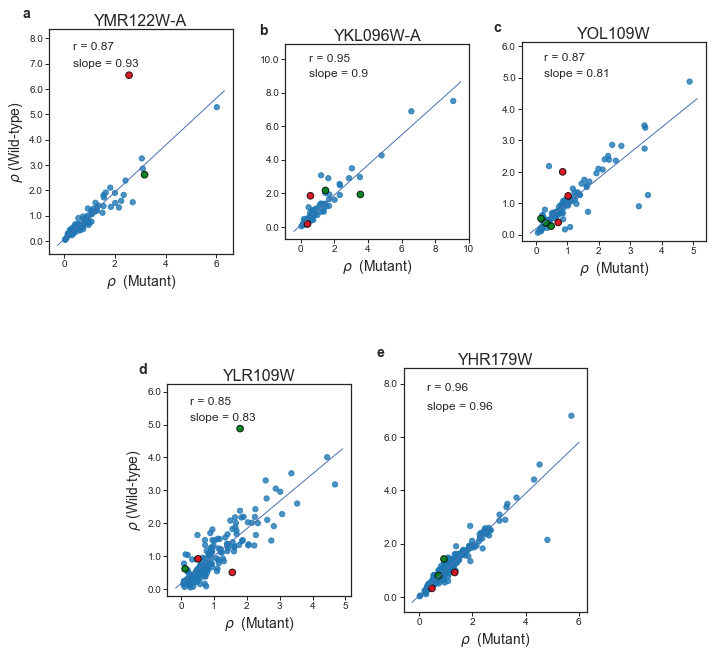

In [70]:
mutant_gene_list = ['YMR122W-A', 'YKL096W-A', 'YOL109W', 'YLR109W', 'YHR179W']
dict_mut_pos = {'YMR122W-A': [56], 'YKL096W-A': [32, 62], 'YOL109W': [14, 99, 106], 'YLR109W': [140, 162], 'YHR179W': [150, 339]}

mutant_gene_correlations(dict_norm_ribo_density, mutant_gene_list, dict_mut_pos)

### Function definitions for plotting normalized ribosome densities for the A-sites when the mutated amino acid is in P-site

In [71]:
def get_mutant_densities(dict_norm_ribo_density, dict_mut_pos, phaseI_list_samples, phaseII_list_samples):
    plot_data = {}
    plot_avg = {}
    for mut in dict_mut_pos:
        plot_data[mut] = {'Type': [], 'Density': []}
        density_list = {'Mutant': [], 'Wild-type': []}
        gene = mut.split(' ')[0]
        if gene == 'YHR179W':
            phase = 'PhaseII'
            phase_samples = phaseII_list_samples
        else:
            phase = 'PhaseI'
            phase_samples = phaseI_list_samples
        for sample in phase_samples:
            density = dict_norm_ribo_density[phase][sample][gene][dict_mut_pos[mut]-1]
            plot_data[mut]['Density'].append(density)
            if gene[:3] in sample:
                plot_data[mut]['Type'].append('Mutant')
                density_list['Mutant'].append(density)
            else:
                plot_data[mut]['Type'].append('Wild-type')
                density_list['Wild-type'].append(density)
        plot_avg[mut] = {'Type': [], 'Density': []}
        for samp_type in density_list:
            plot_avg[mut]['Type'].append(samp_type)
            plot_avg[mut]['Density'].append(np.mean(density_list[samp_type]))
    
    return plot_data, plot_avg


def subplot_mut_vs_wt(ax, plot_data, plot_avg, title, ytype='Density', xtype='Type', jitter=True, set_xlabel=False, set_ylabel=True, xlabel='',
                      ylabel='Normalized Ribo Density', yticks=None, dec=1, set_ylimits=False, ylim1=0, ylim2=3, 
                     palette_colors=((0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804))):
    sns.set_palette(palette_colors)
    ax = sns.stripplot(plot_data[xtype], plot_data[ytype], ax=ax, size=10, linewidth=1, jitter=jitter, order=['Wild-type', 'Mutant'])
    if set_ylimits:
        ax.set_ylim(ylim1, ylim2)
    else:
        ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
    if dec == 1:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    else:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#     if colors:
#         ax.set_prop_cycle(color=colors) # ['blue', 'green', 'orange'])

    ax = sns.boxplot(plot_avg[xtype], plot_avg[ytype], width=0.6, linewidth=3, ax=ax, order=['Wild-type', 'Mutant'])
    for i, col in enumerate(palette_colors):
        mybox = ax.artists[i]
        mybox.set_edgecolor(col)
        for j in range(i * 6, i * 6 + 6):
            wline = ax.lines[j]
            wline.set_color(col)
            wline.set_mfc(col)
            wline.set_mec(col)
    ax.set(adjustable='box')
    # ax.set_aspect('equal')
    ax.set_title(title, fontsize=18)
    if set_ylabel:
        ax.set_ylabel(ylabel, fontsize=18)
    else:
        ax.yaxis.label.set_visible(False)
    if set_xlabel:
        ax.set_xlabel(xlabel, fontsize=16)
    else:
        ax.xaxis.label.set_visible(False)
    ax.tick_params(labelsize=20)
    ax.tick_params(width=1, length=4, axis='y', which='major', labelsize=16, pad=2)
    if yticks:
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticks)
    return ax


def plot_mutant_ribo_density_Fig2(plot_data, plot_avg):
#     for mut in plot_data:
#         for idx, val in enumerate(plot_data[mut]['Type']):
#             print(mut+'\t'+str(idx)+'\t'+str(val)+'\t'+str(plot_data[mut]['Density'][idx]))
#         print('\n')
    plt.figure(figsize=(5 * 5, 10))
    sns.set()
    # plt.style.use('seaborn-white')
    
    ax1 = plt.subplot(251)
    ax1 = subplot_mut_vs_wt(ax1, plot_data['YMR122W-A P-G-->E-G'], plot_avg['YMR122W-A P-G-->E-G'], title=u'YMR122W-A (P,G) \u2192 (E,G)', set_ylimits=True, ylim2=8)

    ax2 = plt.subplot(252)
    ax2 = subplot_mut_vs_wt(ax2, plot_data['YOL109W N-R-->S-R'], plot_avg['YOL109W N-R-->S-R'], title=u'YOL109W (N,R) \u2192(S,R)', set_ylabel=False, set_ylimits=True)

    ax3 = plt.subplot(253)
    ax3 = subplot_mut_vs_wt(ax3, plot_data['YKL096W-A D-G-->F-G'], plot_avg['YKL096W-A D-G-->F-G'], title=u'YKL096W-A (D,G) \u2192 (F,G)', set_ylabel=False, set_ylimits=True)

    ax4 = plt.subplot(254)
    ax4 = subplot_mut_vs_wt(ax4, plot_data['YLR109W G-T-->S-T'], plot_avg['YLR109W G-T-->S-T'], title=u'YLR109W (G,T) \u2192 (S,T)', set_ylabel=False, set_ylimits=True)

    ax5 = plt.subplot(255)
    ax5 = subplot_mut_vs_wt(ax5, plot_data['YOL109W G-G-->S-G'], plot_avg['YOL109W G-G-->S-G'], title=u'YOL109W (G,G) \u2192 (S,G)', set_ylabel=False, set_ylimits=True)

    ax6 = plt.subplot(256)
    ax6 = subplot_mut_vs_wt(ax6, plot_data['YOL109W Q-D-->P-D'], plot_avg['YOL109W Q-D-->P-D'], title=u'YOL109W (Q,D) \u2192 (P,D)', set_ylimits=True)

    ax7 = plt.subplot(257)
    ax7 = subplot_mut_vs_wt(ax7, plot_data['YHR179W V-K-->H-K'], plot_avg['YHR179W V-K-->H-K'], title=u'YHR179W (V,K) \u2192 (H,K)', set_ylabel=False, set_ylimits=True)

    ax8 = plt.subplot(258)
    ax8 = subplot_mut_vs_wt(ax8, plot_data['YHR179W E-E-->K-E'], plot_avg['YHR179W E-E-->K-E'], title=u'YHR179W (E,E) \u2192 (K,E)', set_ylabel=False, set_ylimits=True)

    ax9 = plt.subplot(259)
    ax9 = subplot_mut_vs_wt(ax9, plot_data['YKL096W-A S-T-->G-T'], plot_avg['YKL096W-A S-T-->G-T'], title=u'YKL096W-A (S,T) \u2192 (G,T)', set_ylabel=False, set_ylimits=True)

    ax10 = plt.subplot(2, 5, 10)
    ax10 = subplot_mut_vs_wt(ax10, plot_data['YLR109W S-G-->G-G'], plot_avg['YLR109W S-G-->G-G'], title=u'YLR109W (S,G) \u2192 (G,G)', set_ylabel=False, set_ylimits=True)

    plt.subplots_adjust(hspace=0.4)

    return fig, [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]

## Generating results for the mutational experiments (shown in Fig. 2a and 2b in the study)

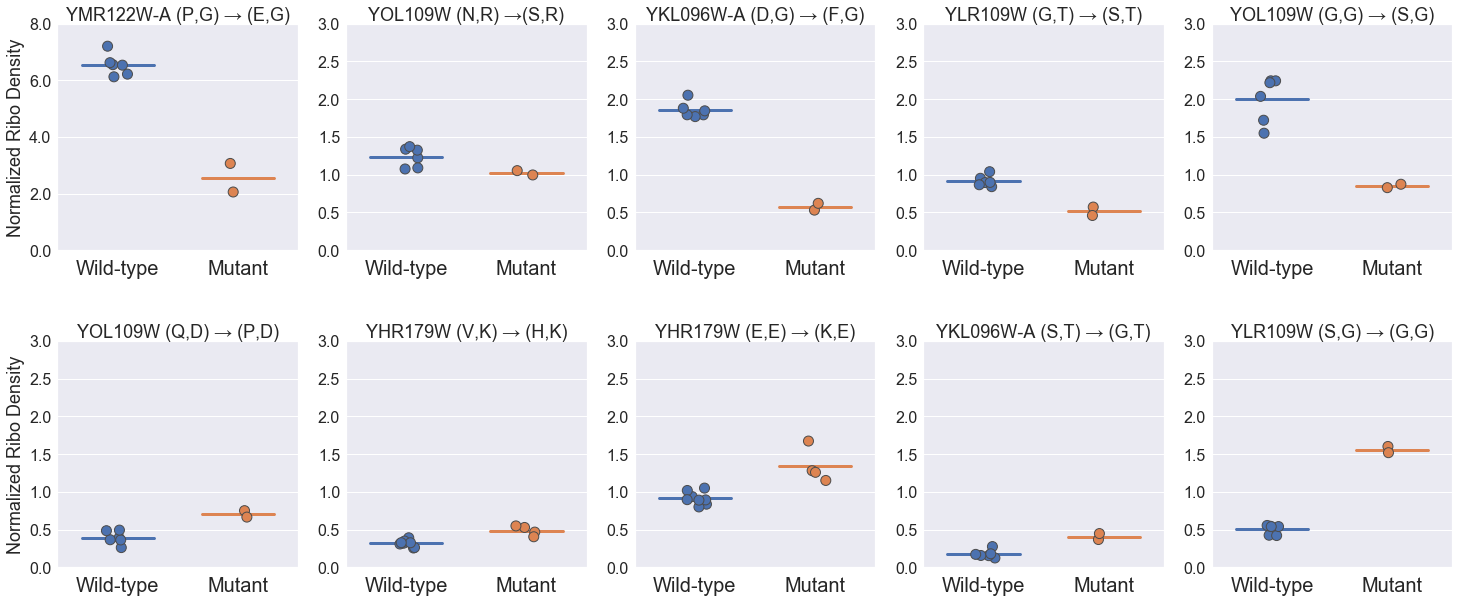

In [72]:
dict_mutations = {'YMR122W-A P-G-->E-G': 56, 'YKL096W-A D-G-->F-G': 32,  'YKL096W-A S-T-->G-T': 62, 'YOL109W Q-D-->P-D':14, 'YOL109W G-G-->S-G': 99, 'YOL109W N-R-->S-R':106,
                'YLR109W S-G-->G-G': 140, 'YLR109W G-T-->S-T': 162, 'YHR179W E-E-->K-E': 150, 'YHR179W V-K-->H-K': 339}

plot_data, plot_avg = get_mutant_densities(dict_norm_ribo_density, dict_mutations, phaseI_list_samples, phaseII_list_samples)
fig, ax_list = plot_mutant_ribo_density_Fig2(plot_data, plot_avg)
plt.show()

### Function definitions utilized for generating Figs. 2c,d and Figs. 3b,c,d

In [73]:
def plot_neg_control_Fig2c(dict_norm_ribo_density, dict_control_mut_pos, phaseI_list_samples, phaseII_list_samples):
    
    plot_data, plot_avg = get_mutant_densities(dict_norm_ribo_density, dict_control_mut_pos, phaseI_list_samples, phaseII_list_samples)
    plt.figure(figsize=(5 * 5, 10))
    sns.set()
    ax1 = plt.subplot(252)
    ax1 = subplot_mut_vs_wt(ax1, plot_data['YHR179W V-F-->Y-F'], plot_avg['YHR179W V-F-->Y-F'], title=u'YHR179W (V,F) \u2192 (Y,F)', dec=2)
    ax1.set_ylim(bottom=0.0, top=1.5)

    ax2 = plt.subplot(253)
    ax2 = subplot_mut_vs_wt(ax2, plot_data['YHR179W L-A-->N-A'], plot_avg['YHR179W L-A-->N-A'], title=u'YHR179W (L,A) \u2192 (N,A)', set_ylabel=False)
    ax2.set_ylim(bottom=0.0, top=1.5)

    for i in [1, 4, 5, 6, 7, 8, 9, 10]:
        ax = plt.subplot(2, 5, i)
        ax.set_axis_off()

    plt.show()
    
# Aim is to statistically test the difference between the effect size of change in translation speed between the mutations for which we predict change in speed to the negative control mutations
def stat_test_mutants_vs_control(plot_data):
    dict_densities = {}

    for mut in plot_data:
        dict_densities[mut] = {'Mutant': [], 'Wild-type': []}
        for idx, val in enumerate(plot_data[mut]['Type']):
            dict_densities[mut][val].append(plot_data[mut]['Density'][idx])

    list_mut_perc = []
    list_control_perc = []
    for mutation in dict_densities:
        for val in dict_densities[mutation]['Mutant']:
            for ref_val in dict_densities[mutation]['Wild-type']:
                perc_diff = math.fabs(val-ref_val)*100/((val+ref_val)/2)
                if mutation in ['YHR179W V-F-->Y-F', 'YHR179W L-A-->N-A']:
                    list_control_perc.append(perc_diff)
                else:
                    list_mut_perc.append(perc_diff)

    u, p = stats.mannwhitneyu(list_mut_perc, list_control_perc)
    
    print('Mann-Whitney U test')
    print('U = ' + str(u) + ' p-value = ' + str(p))
    print(len(list_mut_perc), len(list_control_perc), np.median(list_mut_perc), np.median(list_control_perc))

    add_to_axis_label = r' x $10^{%d}$' % (int(str(p).split('e')[1]))
    pval = "{0:.2f}".format(float(str(p).split('e')[0])) + add_to_axis_label

    dict_compare = {'Type':[], 'perc_diff':[]}
    for val in list_mut_perc:
        dict_compare['Type'].append('Mutants with predicted change in rate')
        dict_compare['perc_diff'].append(val)
    for val2 in list_control_perc:
        dict_compare['Type'].append('Negative control mutants')
        dict_compare['perc_diff'].append(val2)

    plt.figure()
    plt.figure(figsize=(5 * 5, 10))
    sns.set()
    ax = plt.subplot(132)
    ax = sns.boxplot(x=dict_compare['Type'], y=dict_compare['perc_diff'], order=['Mutants with predicted change in rate', 'Negative control mutants'], linewidth=1, ax=ax)
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + 30)
    ax.set_prop_cycle(color=['blue', 'green'])
    ax.set(adjustable='box')
    ax.set_ylabel('Percent difference in\n median' + r'$\rho$', fontsize=20)
    ax.xaxis.label.set_visible(False)
    ax.tick_params(labelsize=6.5)
    ax.tick_params(width=1, length=4, axis='y', which='major', labelsize=14, pad=2)
    ax.tick_params(width=1, length=4, axis='x', which='major', labelsize=16, pad=2)

    x1, x2 = 0, 1  # columns of mutant and control
    y, h, col = max(dict_compare['perc_diff']) + 5, 10, 'k'
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
    plt.text((x1 + x2) * .5, y + h + 2, "p = " + str(pval), ha="center", va="bottom", color=col, fontsize=16)
    
    ax.set_xticklabels(['Mutants with predicted\n change in rate', 'Negative control\n mutants'])
    
    for i in [1, 3]:
        ax = plt.subplot(1, 3, i)
        ax.set_axis_off()
    
    plt.show()
    
def get_mutant_densities_two_mutants(dict_norm_ribo_density, dict_mut_pos, phaseII_list_samples):
    plot_data = {}
    plot_avg = {}
    for mut in dict_mut_pos:
        plot_data[mut] = {'Type': [], 'Density': []}
        density_list = {'Mutant1': [], 'Mutant2': [], 'Wild-type': []}
        gene = mut.split(' ')[0]
        phase = 'PhaseII'
        phase_samples = phaseII_list_samples

        for sample in phase_samples:
            density = dict_norm_ribo_density[phase][sample][gene][dict_mut_pos[mut]-1]
            plot_data[mut]['Density'].append(density)
            if sample[:5] == 'YOL-A':
                plot_data[mut]['Type'].append('Mutant1')
                density_list['Mutant1'].append(density)
            elif sample[:5] == 'YOL-B':
                plot_data[mut]['Type'].append('Mutant2')
                density_list['Mutant2'].append(density)
            else:
                plot_data[mut]['Type'].append('Wild-type')
                density_list['Wild-type'].append(density)
        plot_avg[mut] = {'Type': [], 'Density': []}
        for samp_type in density_list:
            plot_avg[mut]['Type'].append(samp_type)
            plot_avg[mut]['Density'].append(np.mean(density_list[samp_type]))

    return plot_data, plot_avg

def subplot_two_mut_vs_wt(ax, plot_data, plot_avg, title, ytype='Density', xtype='Type', jitter=True, set_xlabel=False, set_ylabel=True, xlabel='',
                      ylabel='Normalized Ribo Density', yticks=None, dec=1, set_ylimits=False, ylim1=0.5, ylim2=1.6, 
                     palette_colors=((0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804))):
    sns.set_palette(palette_colors)
    ax = sns.stripplot(plot_data[xtype], plot_data[ytype], ax=ax, size=10, linewidth=1, jitter=jitter, order=['Wild-type', 'Mutant1', 'Mutant2'])
    if set_ylimits:
        ax.set_ylim(ylim1, ylim2)
    else:
        ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
    if dec == 1:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    else:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    ax = sns.boxplot(plot_avg[xtype], plot_avg[ytype], width=0.6, linewidth=3, ax=ax, order=['Wild-type', 'Mutant1', 'Mutant2'])
    for i, col in enumerate(palette_colors):
        mybox = ax.artists[i]
        mybox.set_edgecolor(col)
        for j in range(i * 6, i * 6 + 6):
            wline = ax.lines[j]
            wline.set_color(col)
            wline.set_mfc(col)
            wline.set_mec(col)
    ax.set(adjustable='box')
    # ax.set_aspect('equal')
    ax.set_title(title, fontsize=14)
    if set_ylabel:
        ax.set_ylabel(ylabel, fontsize=12)
    else:
        ax.yaxis.label.set_visible(False)
    if set_xlabel:
        ax.set_xlabel(xlabel, fontsize=12)
    else:
        ax.xaxis.label.set_visible(False)
    ax.tick_params(labelsize=12)
    ax.tick_params(width=1, length=4, axis='y', which='major', labelsize=12, pad=2)
    if yticks:
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticks)
    return ax


def plot_mutant_ribo_density_Fig3(dict_norm_ribo_density, dict_mutations, phaseII_list_samples):
    plot_data, plot_avg = get_mutant_densities_two_mutants(dict_norm_ribo_density, dict_mutations, phaseII_list_samples)

    palette_colors = [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)]
    plt.figure()
    plt.figure(figsize=(3 * 3, 6))

    sns.set()
    ax1 = plt.subplot(231)
    ax1 = subplot_two_mut_vs_wt(ax1, plot_data['YOL109W G-G-->S-G'], plot_avg['YOL109W G-G-->S-G'], title=u'YOL109W (G,G) \u2192 (S,G)', set_ylimits=True, palette_colors=palette_colors)

    ax2 = plt.subplot(232)
    ax2 = subplot_two_mut_vs_wt(ax2, plot_data['YOL109W Q-D-->P-D'], plot_avg['YOL109W Q-D-->P-D'], title=u'YOL109W (Q,D) \u2192 (P,D)', set_ylabel=False, set_ylimits=True, palette_colors=palette_colors)
    
    ax3 = plt.subplot(233)
    ax3 = subplot_two_mut_vs_wt(ax3, plot_data['YOL109W N-R-->S-R'], plot_avg['YOL109W N-R-->S-R'], title=u'YOL109W (N,R) \u2192 (S,R)', set_ylabel=False, set_ylimits=True, palette_colors=palette_colors)
    
    for i in [4, 5, 6]:
        ax = plt.subplot(2, 3, i)
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

### Running the analysis on negative control mutations (Fig. 2c in the study)

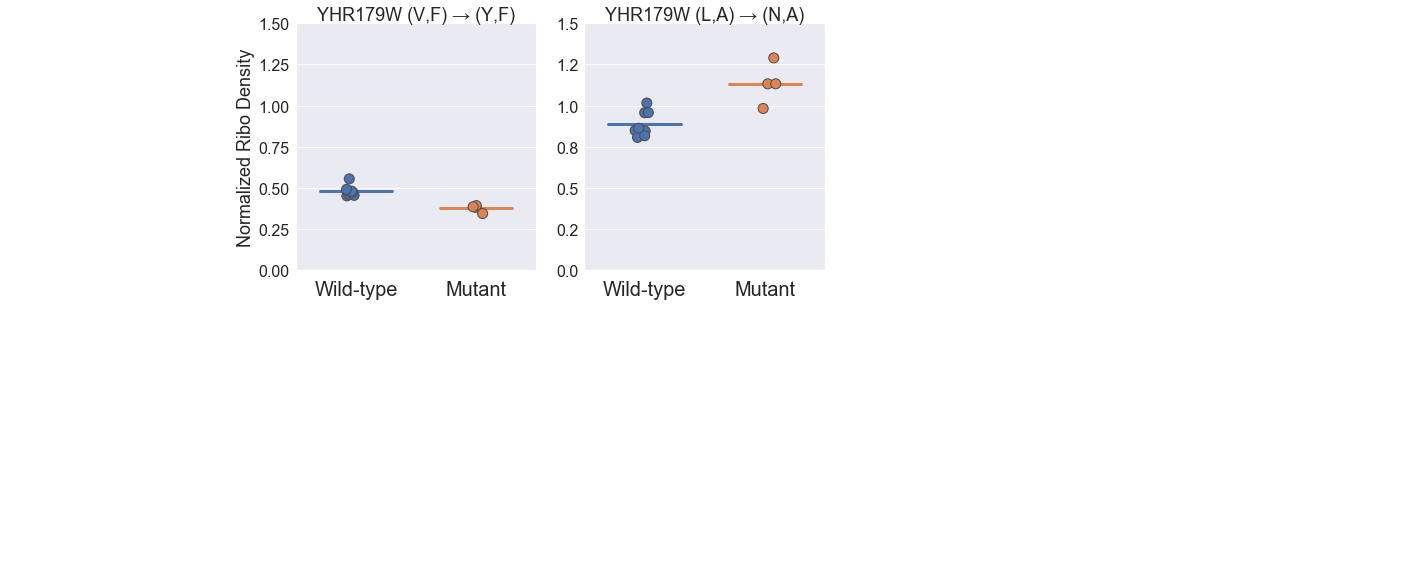

In [74]:
dict_control_mut_pos = {'YHR179W V-F-->Y-F': 251, 'YHR179W L-A-->N-A': 129}
plot_neg_control_Fig2c(dict_norm_ribo_density, dict_control_mut_pos, phaseI_list_samples, phaseII_list_samples)

### Comparing the effect size for negative control mutations versus other mutations (Fig. 2d in the study)

Mann-Whitney U test
U = 1473.0 p-value = 4.3260398838601007e-17
160 64 58.181789605025756 23.00567409901165


<Figure size 432x288 with 0 Axes>

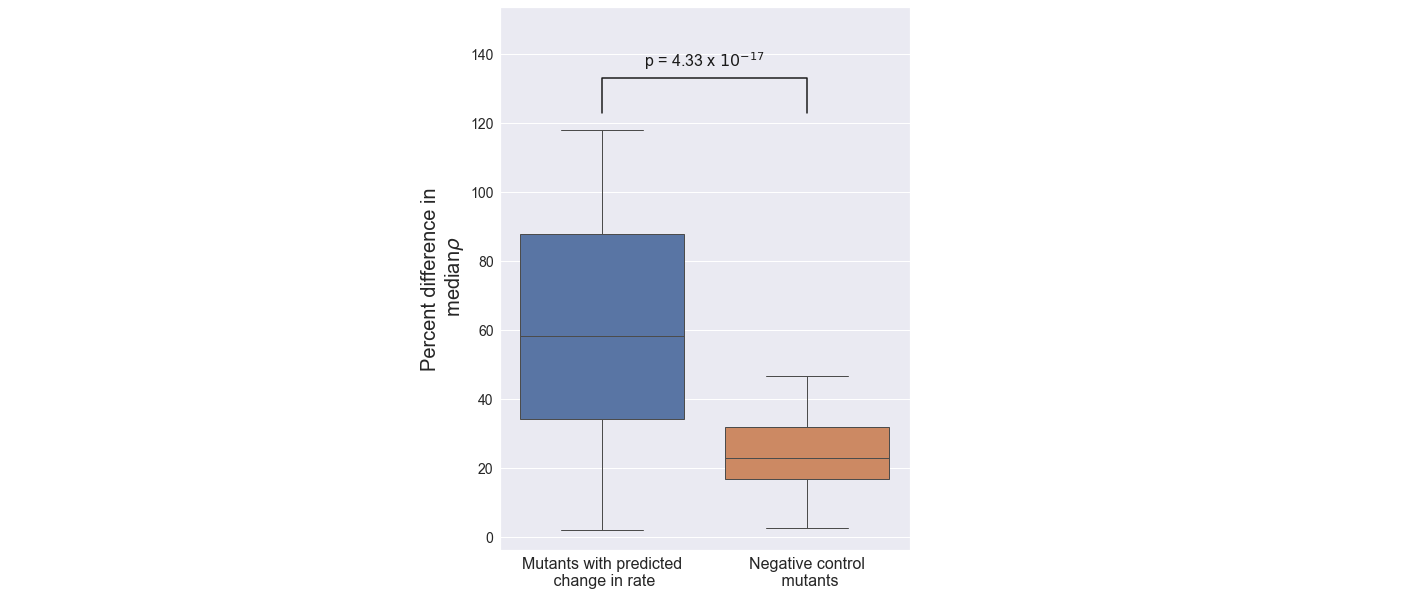

In [75]:
dict_mutations = {'YMR122W-A P-G-->E-G': 56, 'YKL096W-A D-G-->F-G': 32,  'YKL096W-A S-T-->G-T': 62, 'YOL109W Q-D-->P-D':14, 'YOL109W G-G-->S-G': 99, 'YOL109W N-R-->S-R':106,
                'YLR109W S-G-->G-G': 140, 'YLR109W G-T-->S-T': 162, 'YHR179W E-E-->K-E': 150, 'YHR179W V-K-->H-K': 339, 'YHR179W V-F-->Y-F': 251, 'YHR179W L-A-->N-A': 129}

plot_data, plot_avg = get_mutant_densities(dict_norm_ribo_density, dict_mutations, phaseI_list_samples, phaseII_list_samples)

stat_test_mutants_vs_control(plot_data)

### Generating results for the experiment where two different synonymous mutations are made to generate the same amino acid change (Results shown n Fig. 3b,c,d of the study)

<Figure size 432x288 with 0 Axes>

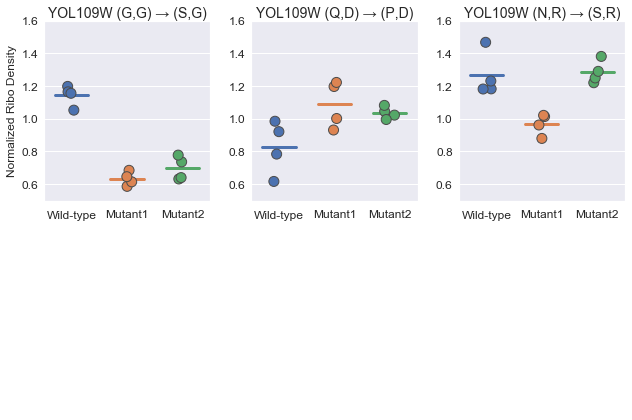

In [76]:
dict_two_syn_mutations = {'YOL109W Q-D-->P-D':14,'YOL109W G-G-->S-G': 99, 'YOL109W N-R-->S-R':106}

plot_mutant_ribo_density_Fig3(dict_norm_ribo_density, dict_two_syn_mutations, phaseII_list_samples)

### Generating the correlations for the above two mutant strains in comparison to wild-type and the norm ribo density profiles around the three mutations (shown in Fig. S11 in the study)

All replicates have Pearson correlation between them > 0.9414898455152165
Averaging all replicates to form a single mutant profile and single wild-type profile for each gene


Gene	Slope	Intercept	Pearson R	P-value
Wild-type vs Mutant1	0.904	0.096	0.88	4.756801925533709e-38

Wild-type vs Mutant2	0.946	0.054	0.91	1.0151007574988973e-44

Mutant2 vs Mutant1	0.977	0.023	0.966	5.824998016716163e-68



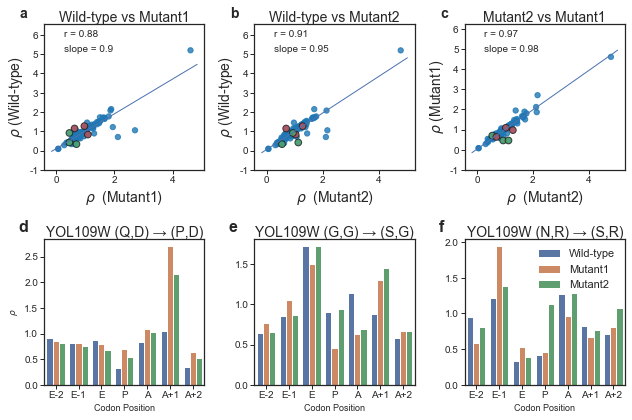

In [77]:
mutant_gene_correlations_two_mutants(dict_norm_ribo_density, dict_mut_pos, dict_mutations)

### Function defintions for the proteome enrichment/depletion analysis (results shown in Fig. 4a)

In [78]:
from Bio import SeqIO
def get_proteome_for_enr_dep_analysis(fsa_file):
    combined_seq = ''

    # Load the protein sequences
    for record in SeqIO.parse(fsa_file, "fasta"):
        id_line = record.id
        # seq_name = id_line.split('_')[4]
        # seq_name = id_line.strip().split(' ')[0]
        seq = str(record.seq)
        combined_seq += seq

    perm_prob, perm_count = get_prob_megaseq(combined_seq, True)
    dict_ratio_prob = {}

    for aa_asite in AMINO_ACIDS:
        if aa_asite == '*':
            continue
        for aa_psite in AMINO_ACIDS:
            if aa_psite == '*':
                continue
            aa_pair = aa_psite + aa_asite
            dict_ratio_prob[aa_pair] = perm_prob[aa_pair]/(perm_prob[aa_psite]*perm_prob[aa_asite])
    print("Getting the ratios for total "+str(len(dict_ratio_prob))+ " pairs")
    return dict_ratio_prob

def enr_dep_of_pairs(dict_ratio_prob, dict_sig_pairs, enr_dep_threshold=0.2):
    sorted_dict_ratio_prob = [k for k, v in sorted(dict_ratio_prob.items(), key=lambda item: item[1])]

    enriched_pairs = sorted_dict_ratio_prob[int(len(sorted_dict_ratio_prob)*(1-enr_dep_threshold)):]
    depleted_pairs = sorted_dict_ratio_prob[:int(len(sorted_dict_ratio_prob)*enr_dep_threshold)]

    dict_stats = {}
    dict_enr_dep_pairs = {}
    for pair_type in dict_sig_pairs:
        dict_stats[pair_type] = {'enriched': 0, 'depleted': 0}
        dict_enr_dep_pairs[pair_type] = {'enriched': [], 'depleted': []}
        for pair in dict_sig_pairs[pair_type]:
            if pair in enriched_pairs:
                dict_stats[pair_type]['enriched'] += 1
                dict_enr_dep_pairs[pair_type]['enriched'].append(pair)
            elif pair in depleted_pairs:
                dict_stats[pair_type]['depleted'] += 1
                dict_enr_dep_pairs[pair_type]['depleted'].append(pair)

    odds_ratio, pval = stats.fisher_exact([[dict_stats['Fast']['enriched'], dict_stats['Slow']['enriched']], [dict_stats['Fast']['depleted'], dict_stats['Slow']['depleted']]])
    print("Fisher's exact test - Are Fast pairs enriched and slow pairs depleted across the proteome?")
    print("Odds ratio: "+str(odds_ratio)+ " p-value = "+str(pval))
    return dict_enr_dep_pairs

def get_prob_megaseq(megaseq, count_ind_pairs=False):
    dict_count = {}
    # Initialize the pairs as keys for the dict_count
    for aa_asite in AMINO_ACIDS:
        if aa_asite == '*':
            continue
        # If we are also counting the probabilities of finding individual amino acids across the sequence
        if count_ind_pairs:
            dict_count[aa_asite] = 0
        for aa_psite in AMINO_ACIDS:
            if aa_psite == '*':
                continue
            aa_pair = aa_psite + aa_asite
            if aa_pair not in dict_count:
                dict_count[aa_pair] = 0

    total_count = 0
    seq_count = 0
    # for gene, seq in dict_aa_seq.iteritems():
    # Sanitary check
    # if len(seq) != dict_len[gene] / 3:
    # if len(seq) != dict_len[gene]:
    #     print 'AA sequence length is '+str(len(seq))+' for ' + gene + ' is not equal to length of gene which is '+str(dict_len[gene])+'. The Sequence is '+str(seq)

    seq_count += len(megaseq) - 1
    # get all pairs in the protein sequence
    for val in range(0, len(megaseq) - 1):
        pair = megaseq[val] + megaseq[val + 1]
        if '*' in pair or 'X' in pair:
            seq_count -= 1
            continue
        try:
            # Count the pairs
            dict_count[pair] += 1
            total_count += 1
        except KeyError:
            print(' KeyError at pos ' + str(val) + ' for pair ' + pair + ' with megaseq entry ' + str(megaseq[val]))

    if total_count != seq_count:
        print(' Total count ' + str(total_count) + ' different from seq count ' + str(seq_count))

    if count_ind_pairs:
        for val in range(0, len(megaseq)):
            if megaseq[val] in ['*', 'X']:
                continue
            try:
                dict_count[megaseq[val]] += 1
            except KeyError:
                print('KeyError for dict count for amino acid '+megaseq[val])
    dict_prob = {}
    # Probability of the pair occuring in the nucleo/cytoplasmic transcriptome
    for pair, count in dict_count.items():
        dict_prob[pair] = float(count) / total_count

    return dict_prob, dict_count

def plot_enr_perc_change(dict_ratio_prob, dict_enr_dep_pairs, robust_pairs_percs):
    stat_file=open('Data_files/output_files/Fig4a_data.tab', 'w')
    plot_data = {'fold_enrichment': [], 'percent_change': [], 'category': []}
    print("Running analysis for "+str(len(dict_ratio_prob))+ ' pairs')
    for pair in dict_ratio_prob:
        plot_data['fold_enrichment'].append(dict_ratio_prob[pair])
        plot_data['percent_change'].append(robust_pairs_percs[pair])
        if pair in dict_enr_dep_pairs['Fast']['enriched']+dict_enr_dep_pairs['Fast']['depleted']:
            plot_data['category'].append('Fast Pairs')
            stat_file.write(pair+'\t'+str(dict_ratio_prob[pair])+'\t'+str(robust_pairs_percs[pair])+'\tFast Pairs\n')
        elif pair in dict_enr_dep_pairs['Slow']['enriched']+dict_enr_dep_pairs['Slow']['depleted']:
            plot_data['category'].append('Slow Pairs')
            stat_file.write(pair+'\t'+str(dict_ratio_prob[pair])+'\t'+str(robust_pairs_percs[pair])+'\tSlow Pairs\n')
        else:
            plot_data['category'].append('Insignificant Pairs')
            stat_file.write(pair+'\t'+str(dict_ratio_prob[pair])+'\t'+str(robust_pairs_percs[pair])+'\tInsignificant Pairs\n')
    fig, ax1 = plt.subplots()
    plt.style.use('seaborn-white')
    palette_colors = ['grey', 'blue', 'red']
    ax1 = sns.scatterplot(plot_data['fold_enrichment'], plot_data['percent_change'], hue=plot_data['category'], hue_order=['Insignificant Pairs', 'Fast Pairs', 'Slow Pairs'], ax=ax1, s=10, linewidth=0.5, palette=palette_colors)
    ax1.set_xlabel('Fold enrichment of amino acid pair relative to\n random chance (log2 scale)', fontsize=14)

    #  % difference in translation rate
    ax1.set_ylabel('% change in median ' + r'$\rho$', fontsize=14)
    ax1.tick_params(width=1, length=4, axis='x', which='major', labelsize=9, pad=2, direction='out', bottom=True)
    ax1.tick_params(width=1, length=2, axis='y', which='major', labelsize=9, pad=1, direction='out', left=True)
    ax1.set_xscale('log', basex=2)
    ax1.set_xticks([0.25, 0.5, 1, 2, 4])
    ax1.axhline(y=0, linestyle='--', color='black')
    ax1.axvline(x=1, linestyle='--', color='black')
    ax1.legend(fontsize=12, loc='upper right')
    
    plt.show()

## Generating Fig 4a that plots the fold enrichment for amino acid pairs across the proteome against their % change calculated according to Eq. 1

The % change in median $\rho$ is averaged across the six datasets

Getting the ratios for total 400 pairs
Fisher's exact test - Are Fast pairs enriched and slow pairs depleted across the proteome?
Odds ratio: 4.3125 p-value = 0.009812592888057085
Running analysis for 400 pairs


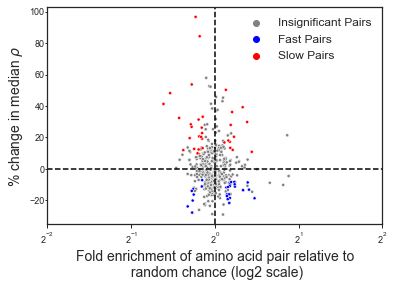

In [85]:
dict_ratio_prob = get_proteome_for_enr_dep_analysis("Data_files/reference_files/orf_trans.fasta")
dict_enr_dep_pairs = enr_dep_of_pairs(dict_ratio_prob, robust_pairs_dict)
plot_enr_perc_change(dict_ratio_prob, dict_enr_dep_pairs, robust_pairs_mean_percs_dict)

### Function definitions for the Linker vs Domain analysis whose result is shown in Fig. 4b

In [86]:
def parse_domain_info_no_exit_tunnel_for_domain_start(domain_file, exit_tunnel_gap=30, window=30, only_cyto=True, print_stats=True):
    # NOT CONSIDERING THE EXIT TUNNEL GAP OF 30 RESIDUES AT BOTH THE START AND END OF DOMAIN REGIONS
    df = open(domain_file, 'r')
    # Proteins will be keys and each domain will be key for each protein
    dict_domains = {}
    dict_no_domains = {}
    dict_local = {}
    dict_len = {}
    dict_status = {}
    counter = 0
    dict_protein = {}
    codon_type_dict = {}
    protein = ''
    for lines in df:
        # Get the protein name
        if lines.startswith("##Unibegin"):
            fields = lines.strip().split('\t')
            protein = fields[1]
            dict_domains[protein] = {}
            dict_status[protein] = {}
        if lines.startswith("ND:"):
            fields = lines.strip().split('\t')
            no_domains = int(fields[1])
            dict_no_domains[protein] = no_domains
            # dict_domain_counter[protein] = [0]*no_domains*4
        if lines.startswith("mRNA:"):
            fields = lines.strip().split('\t')
            mrna_seq = fields[1]
            codon_type_dict[protein] = []
            for i in range(0, len(mrna_seq), 3):
                codon_type_dict[protein].append(mrna_seq[i:i + 3])
        if lines.startswith("TAA:"):
            fields = lines.strip().split('\t')

            aa_seq = fields[1]
            dict_len[protein] = len(aa_seq)
            dict_protein[protein] = aa_seq
            for lx in range(1, dict_len[protein] + 1):
                dict_status[protein][lx] = 'L'
        if lines.startswith('SCL:'):
            fields = lines.strip().split('\t')
            if len(fields) > 1:
                localization = fields[1]
            else:
                localization = 'NA'
            dict_local[protein] = localization
        if lines.startswith('#Dombegin'):
            fields = lines.strip().split('\t')
            counter = int(fields[1])
            # dict_domains[protein][counter] = {}
        if lines.startswith('D' + str(counter) + '_DRC'):
            try:
                fields = lines.strip().split('\t')[1].split('/')
            except IndexError:
                print('IndexError for protein ' + str(protein))
                fields = [0, 0]
            start = int(fields[0])
            stop = int(fields[1])
            dict_domains[protein][counter] = (start, stop)

    # Quality control for correcting the sequence of domains
    for gene in dict_domains:
        for dom in sorted(dict_domains[gene]):
            start, stop = dict_domains[gene][dom]
            if dom + 1 in dict_domains[gene]:
                start_next, stop_next = dict_domains[gene][dom + 1]
                if stop < start_next:
                    continue
                elif start_next < start:
                    dict_domains[gene][dom] = (start_next, stop_next)
                    dict_domains[gene][dom + 1] = (start, stop)

    # print dict_domains['AIP1_YEAST']

    domain_seq = []
    linker_seq = []
    domain_codons = []
    linker_codons = []
    test_d = []
    test_l = []
    no_proteins = 0
    no_total_doms = 0
    total_dom_aa = 0
    total_linker_aa = 0
    no_total_linkers = 0
    avoid_local = ['Secreted', 'membrane', 'mitochondrion', 'Mitochondrion', 'bud', 'spindle pole', 'Golgi', 'ER', 'vacuole', 'actin', 'peroxisome', 'Peroxisome', 'endosome', 'Endoplasmic']
    for gene, domains in dict_domains.items():
        if only_cyto and any(local in dict_local[gene] for local in avoid_local):
            continue
        no_proteins += 1

        for dom in sorted(domains):
            start, stop = dict_domains[gene][dom]
            # By default, do not include a domain. Include it only if the following linker is include din linker sequence.
            include_domain = False
            # Linker sequence
            if dom != 1:
                # One residue after the end of last domain
                linker_start = dict_domains[gene][dom - 1][1] + 1
                # One residue before the start of current domain
                linker_end = start - 1
                # window -1 would mean whole linker
                if window == -1:
                    linker_range_end = linker_end
                # The case where we are trying to check the enrichment within the 30 residues of exit tunnel as compared to domain
                elif window == -2:
                    linker_range_end = linker_start + 30
                else:
                    linker_range_end = linker_start + exit_tunnel_gap + window
                if linker_range_end <= linker_end:
                    # print 'Writing linker sequence of length '+str(linker_end-linker_start-window)
                    for z in range(linker_start + exit_tunnel_gap, linker_range_end + 1):  # linker_end + 1):
                        # for z in range(stop, stop+window):
                        try:
                            # Quality check
                            if genetic_code[codon_type_dict[gene][z]] != dict_protein[gene][z]:
                                print('Codon/AA mismatch for gene ' + gene + ' at codon ' + str(z + 1))
                                continue
                            linker_seq.append(dict_protein[gene][z])
                            linker_codons.append(codon_type_dict[gene][z])
                            total_linker_aa += 1

                        except IndexError:
                            continue
                    no_total_linkers += 1
                    include_domain = True
                    linker_seq.append('X')
                    linker_codons.append('X')

                if include_domain:
                    start_dom_before_linker, stop_dom_before_linker = dict_domains[gene][dom - 1]
                    for lx in range(start_dom_before_linker, stop_dom_before_linker + 1):
                        dict_status[gene][lx] = 'D'
                    no_total_doms += 1
                    # Adding the domain sequence to domain seq. Not including the first 30 codons which are likely to be inside the exit tunnel. Protein seq is 0-index list. So -1 included
                    for y in range(start_dom_before_linker - 1, stop_dom_before_linker):  # + exit_tunnel_gap):
                        # for y in range(start + window - 1, stop):
                        try:
                            # Quality check
                            if genetic_code[codon_type_dict[gene][y]] != dict_protein[gene][y]:
                                print('Codon/AA mismatch for gene ' + gene + ' at codon ' + str(y + 1))
                                continue
                            domain_seq.append(dict_protein[gene][y])
                            domain_codons.append(codon_type_dict[gene][y])
                            total_dom_aa += 1
                        except IndexError:
                            continue
                    # Adding a X at end of every domain so that aa pairs do not mix up from different domain regions.
                    domain_seq.append('X')
                    domain_codons.append('X')

        include_domain = False
        # IF there are more residues left out after end of last domain
        if dict_domains[gene][dict_no_domains[gene]][1] != dict_len[gene]:
            linker_start = dict_domains[gene][dict_no_domains[gene]][1] + 1
            linker_end = dict_len[gene]
            if window == -1:
                linker_range_end = linker_end
            elif window == -2:
                linker_range_end = linker_start + 30
            else:
                linker_range_end = linker_start + exit_tunnel_gap + window
            if linker_start + exit_tunnel_gap + window < linker_end:
                # print 'Writing linker sequence of length ' + str(linker_end - linker_start - window)
                for z in range(linker_start + exit_tunnel_gap, linker_range_end + 1):  # linker_end + 1):
                    # for z in range(stop, stop+window):
                    try:
                        linker_seq.append(dict_protein[gene][z])
                        linker_codons.append(codon_type_dict[gene][z])
                        total_linker_aa += 1
                    except IndexError:
                        continue
                no_total_linkers += 1
                include_domain = True
                linker_seq.append('X')
                linker_codons.append('X')

            if include_domain:
                start_dom_before_linker, stop_dom_before_linker = dict_domains[gene][dict_no_domains[gene]]
                for lx in range(start_dom_before_linker, stop_dom_before_linker + 1):
                    dict_status[gene][lx] = 'D'
                no_total_doms += 1

                # Adding the domain sequence to domain seq. Not including the first 30 codons which are likely to be inside the exit tunnel. Protein seq is 0-index list. So -1 included
                for y in range(start_dom_before_linker - 1, stop_dom_before_linker):
                    # for y in range(start + window - 1, stop):
                    try:
                        # Quality check
                        if genetic_code[codon_type_dict[gene][y]] != dict_protein[gene][y]:
                            print('Codon/AA mismatch for gene ' + gene + ' at codon ' + str(y + 1))
                            continue
                        domain_seq.append(dict_protein[gene][y])
                        domain_codons.append(codon_type_dict[gene][y])
                        total_dom_aa += 1
                    except IndexError:
                        continue
                # Adding an X at end of every domain so that aa pairs do not mix up from different domain regions.
                domain_seq.append('X')
                domain_codons.append('X')

    d_mega_seq = ''.join(domain_seq)
    l_mega_seq = ''.join(linker_seq)

    if print_stats:
        print("\nLinker Size: "+str(window))
        print("Total proteins analyzed: " + str(no_proteins))
        print("Total number of domains: " + str(no_total_doms))
        print("Total number of linker regions: " + str(no_total_linkers))
        print("Total residues in domains: " + str(total_dom_aa))
        print("Total residues in linkers: " + str(total_linker_aa))
     
    return d_mega_seq, l_mega_seq, domain_codons, linker_codons

import statsmodels.stats.contingency_tables as contingency

# REGULAR L VS D ENRICHMENT ANALYSIS.
def enr_domain_vs_linker_fishers_test(d_mega_seq, l_mega_seq, sig_pairs):
    dict_pairs = {'domain': [], 'linker': []}

    # d_mega_seq is a concatenated sequence of all domain values and similarly for l_mega_seq
    for idx, val in enumerate(d_mega_seq):
        try:
            pair = val + d_mega_seq[idx + 1]
            # X was added to represent stop codon so that artificial pairs are not formed by last residue of a protein and first residue of the next protein concatenated together
            if 'X' not in pair:
                dict_pairs['domain'].append(pair)
        except IndexError:
            continue

    for idx, val in enumerate(l_mega_seq):
        try:
            pair = val + l_mega_seq[idx + 1]
            if 'X' not in pair:
                dict_pairs['linker'].append(pair)
        except IndexError:
            continue

    # Getting the original probabilities of finding Fast/Slow pairs
    dcount_control = 0
    lcount_control = 0
    dcount_sig_pairs = 0
    lcount_sig_pairs = 0

    for pair in sig_pairs:
        dcount_sig_pairs += dict_pairs['domain'].count(pair)
        lcount_sig_pairs += dict_pairs['linker'].count(pair)

    # Control group
    for as_aa in AMINO_ACIDS:
        for ps_aa in AMINO_ACIDS:
            if ps_aa == '*':
                continue
            pair = ps_aa+as_aa
            if pair not in sig_pairs:
                dcount_control += dict_pairs['domain'].count(pair)
                lcount_control += dict_pairs['linker'].count(pair)

    fish_or, fish_pval = stats.fisher_exact([[lcount_sig_pairs, lcount_control], [dcount_sig_pairs, dcount_control]])
    fish_pval_formatted = '{:0.2g}'.format(fish_pval)
    or_low, or_high = contingency.Table2x2(np.asarray([np.asarray([lcount_sig_pairs, lcount_control]), np.asarray([dcount_sig_pairs, dcount_control])])).oddsratio_confint()

    return fish_or, fish_pval_formatted, or_low, or_high


def do_domain_vs_linker_analysis(protein_data_file, robust_pairs):
    plot_data = {'linker_size': [], 'odds_ratio': [], 'high_err': [], 'low_err': [], 'pval': [], 'hue': []}
    for pair_type in ['Slow', 'Fast']:
        for linker_size in [10, 20, 30, 40, 50, 60, 70, 80]:
            dseq, lseq, d_cdns, l_cdns = parse_domain_info_no_exit_tunnel_for_domain_start(protein_data_file, window=linker_size, exit_tunnel_gap=30, print_stats=False)
            fish_or, fish_pval_formatted, or_low, or_high = enr_domain_vs_linker_fishers_test(dseq, lseq, robust_pairs[pair_type])
            plot_data['linker_size'].append(linker_size)
            # Subtracting 1 to make the barplot with reference to 1
            plot_data['odds_ratio'].append(fish_or-1)
            plot_data['high_err'].append(or_high)
            plot_data['low_err'].append(or_low)
            if pair_type == 'Slow':
                plot_data['hue'].append('Slow Pairs')
            elif pair_type == 'Fast':
                plot_data['hue'].append('Fast Pairs')

    fig, ax = plt.subplots()
    plt.style.use('seaborn-white')
    palette_colors = ['red', 'blue', 'red']
    ax = sns.barplot(plot_data['linker_size'], plot_data['odds_ratio'], hue=plot_data['hue'], hue_order=['Slow Pairs', 'Fast Pairs'], ax=ax, palette=palette_colors)
    ax.set_xlabel('Window Size of Linker region', fontsize=14)

    #  % difference in translation rate
    ax.set_ylabel('Odds ratio showing enrichment in L\n versus D region', fontsize=14)
    #  ax.spines['bottom'].set_position(('data', 1))
    ax.tick_params(width=1, length=4, axis='x', which='major', labelsize=9, pad=2, direction='out', bottom=True)
    ax.tick_params(width=1, length=2, axis='y', which='major', labelsize=9, pad=1, direction='out', left=True)
    ax.set_yticks([-0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35])
    ax.set_yticklabels([0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35])
    ax.legend(fontsize=12, loc='upper right')
    plt.show()
    
   

## Generating Fig. 4b that demonstrates that slow pairs are enriched in linker regions with respect to domain regions.

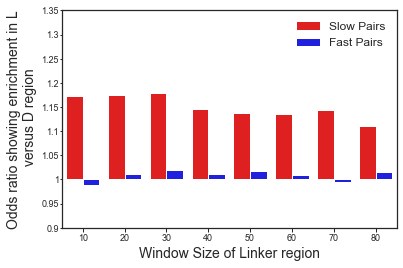

In [87]:
do_domain_vs_linker_analysis('Data_files/reference_files/protein_domain_db.dat', robust_pairs_dict)
 # Not easy to plot the custom errors bar for the odds ratio 95% CI. Used Excel to plot the above odds ratio and its 95% CI for Fig. 4b in the study